# Phase 4 Project Notebook
- Author: Jonathan Holt
- Data Science Flex

## <b> Summary and Overview </b>

###  Business Problem
- What are the top 5 best zip codes for us to invest in?

### Criteria:
<b>In my meeting with the Company, I was given the following directions by the lead investors:</b>

1. The Company is is looking to <b>invest 500,000 per home per zip code</b>.
2. They want to diversify by investing in <b>5 different zip codes, in 5 different states</b>.
3. The Company would like to <b> maximize their ROI</b> per home. 
4. The Company would like to <b> minimize risk</b>. They want "sure thing" investments.
5. The Company is ready to invest now, and <b>wants forecasts for the next 3 years,</b>.

<b> Therefore, I classify the "best" zip codes as:</b>
1. median house prices around 500,000.
2. highest forecasted ROI over the next 3 years (2018-2020)
3. lowest chance of loss. (confidence index lower value)

<b>The Process:</b>
- I will search the data provided for zip codes which have median housing prices around 500,000 at the end of the data (early 2018).
- I will then analyze the performance of those zipcodes over the last 3 years.
- I will rank my findings based on ROI generated over those last 3 years.
- I will then turn each of those zip codes into a time series for modeling.
- I will withhold the last few years of data as a test set to validate my model.
- I will then run a model on each zip code to get a 3-year forecast and analyze the predicted mean and confidence intervals to determine how safe each zipcode would be to invest in over a three year period.
- I will make sure that my primary findings are each in distinct states so that I can provide 5 zip codes in 5 states as requested.

### Questions to Answer

1. What is the average (mean) home price for zip codes?
    a. also by: State, Metro Region, etc.
2. Which zip codes performed above expectations?
3. Do the top performing zip codes have any identifiers?


###  What Models & Metrics I plan on using
- I will use AIC to judge model fit, specifically when doing parameter searches for my SARIMA models.
- 
- I wil using a one-step forecast to judge the predictions against the test data.
- 

### Helper Functions
- Functions provided by Flatiron

In [1]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    #melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted = pd.melt(df, id_vars=['ZipCode', 'RegionID', 'SizeRank', 'City', 'State', 'Metro', 'CountyName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [2]:
#function for displaying money in millions.
def display_millions(x, pos):
    return '${:1.1f}M'.format(x*1e-6)

## <b>PreProcessing</b>

### Loading Data

In [419]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.ticker as mtick
from matplotlib.pylab import rcParams
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
#from sklearn.metrics import mean_squared_error

plt.style.use('fivethirtyeight')
#plt.style.use('ggplot')
pd.set_option('display.max_rows', 1500) #change the amount of rows displayed

pd.options.display.float_format = '{:,.2f}'.format 

In [4]:
ts = pd.read_csv("zillow_data.csv")
ts.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank    1996-04    1996-05    1996-06  ...  2017-07  2017-08  2017-09  \
0         1 334,200.00 335,400.00 336,500.00  ...  1005500  1007500  1007800   
1         2 235,700.00 236,900.00 236,700.00  ...   308000   310000   312500   
2         3 210,400.00 212,200.00 212,200.00  ...   321000   320600   320200   
3         4 498,100.00 500,900.00 503,100.00  ...  1289800  1287700  1287400   
4         5  77,300.00  77,300.00  77,300.00  ...   119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

###  Changing RegionName to ZipCode
A google search shows that RegionName is the ZipCode for each Region. However, upon sorting, I discovered that any ZipCode beginning with a 0 was ignoring it and displaying as a 4 digit number. I will use the .str().zfill() method to ensure that all RegionNames are displaying the as 5 digits.

In [5]:
ts['RegionName'] = ts['RegionName'].astype(str).str.zfill(5)
ts.rename(columns={'RegionName': 'ZipCode'}, inplace=True)

### Checking for Null Values

In [6]:
ts.isnull().sum()

RegionID         0
ZipCode          0
City             0
State            0
Metro         1043
CountyName       0
SizeRank         0
1996-04       1039
1996-05       1039
1996-06       1039
1996-07       1039
1996-08       1039
1996-09       1039
1996-10       1039
1996-11       1039
1996-12       1039
1997-01       1039
1997-02       1039
1997-03       1039
1997-04       1039
1997-05       1039
1997-06       1039
1997-07       1038
1997-08       1038
1997-09       1038
1997-10       1038
1997-11       1038
1997-12       1038
1998-01       1036
1998-02       1036
1998-03       1036
1998-04       1036
1998-05       1036
1998-06       1036
1998-07       1036
1998-08       1036
1998-09       1036
1998-10       1036
1998-11       1036
1998-12       1036
1999-01       1036
1999-02       1036
1999-03       1036
1999-04       1036
1999-05       1036
1999-06       1036
1999-07       1036
1999-08       1036
1999-09       1036
1999-10       1036
1999-11       1036
1999-12       1036
2000-01     

### Analysis
There are many Null Values. 
- For categorical data, 7% of Metro are null (1043 of 14,723).
- Dates from 1996 - mid 2003, also have 7% null values.
- Then it starts to get better. 6% null and decreasing.

<b> Decision: I will keep all of the nulls for now. I will likely care the most about the most recent data, and that is where the records are most complete.  </b>

### Metro
- The null values for Metro are because of rural zip codes that aren't close enough to a metro area to be classified as such. I will create a new value for Metro of 'no_metro' to represent these rural zip codes. 
- NOTE: for any analysis of Metro areas, 'no_metro' should be excluded as these zip codes are NOT part of the same area.

In [7]:
ts['Metro'].value_counts().head()

New York                          779
Los Angeles-Long Beach-Anaheim    347
Chicago                           325
Philadelphia                      281
Washington                        249
Name: Metro, dtype: int64

In [8]:
ts['Metro'].fillna('no_metro', inplace=True)

In [9]:
ts['Metro'].value_counts().head()

no_metro                          1043
New York                           779
Los Angeles-Long Beach-Anaheim     347
Chicago                            325
Philadelphia                       281
Name: Metro, dtype: int64

In [10]:
ts.isna().sum()

RegionID         0
ZipCode          0
City             0
State            0
Metro            0
CountyName       0
SizeRank         0
1996-04       1039
1996-05       1039
1996-06       1039
1996-07       1039
1996-08       1039
1996-09       1039
1996-10       1039
1996-11       1039
1996-12       1039
1997-01       1039
1997-02       1039
1997-03       1039
1997-04       1039
1997-05       1039
1997-06       1039
1997-07       1038
1997-08       1038
1997-09       1038
1997-10       1038
1997-11       1038
1997-12       1038
1998-01       1036
1998-02       1036
1998-03       1036
1998-04       1036
1998-05       1036
1998-06       1036
1998-07       1036
1998-08       1036
1998-09       1036
1998-10       1036
1998-11       1036
1998-12       1036
1999-01       1036
1999-02       1036
1999-03       1036
1999-04       1036
1999-05       1036
1999-06       1036
1999-07       1036
1999-08       1036
1999-09       1036
1999-10       1036
1999-11       1036
1999-12       1036
2000-01     

- All remaining null values are for the time series data. I will leave them as is for now, and deal with them later on as it will likely depend on how I am grouping the data, etc.

### Changing dtype for all housing data to float.

In [11]:
ts[ts.columns[7:]] = ts[ts.columns[7:]].astype(float)

## <b>Exploratory Data Analysis</b>

### Creating avg_home_df
- Create Dataset that is just the mean values to do analysis of trends, etc for baseline.
- then I can look for zip codes that have the best performance above and beyond baseline.

In [12]:
data_values = ts.iloc[:, 7:]
data_values['2018-04'].dtype

dtype('float64')

In [13]:
avg_home_df = pd.DataFrame(data_values.mean())
avg_home_df = avg_home_df.reset_index()
avg_home_df['time'] = pd.to_datetime(avg_home_df['index'])
avg_home_df.set_index('time', inplace=True)
avg_home_df.drop(columns=('index'), inplace=True)
avg_home_df.rename(columns={0: 'home_value'}, inplace=True)

In [14]:
avg_home_df.head()

home_value
time                  
1996-04-01  118,299.12
1996-05-01  118,419.04
1996-06-01  118,537.42
1996-07-01  118,653.07
1996-08-01  118,780.25

### Analysis of Avg_Home_DF

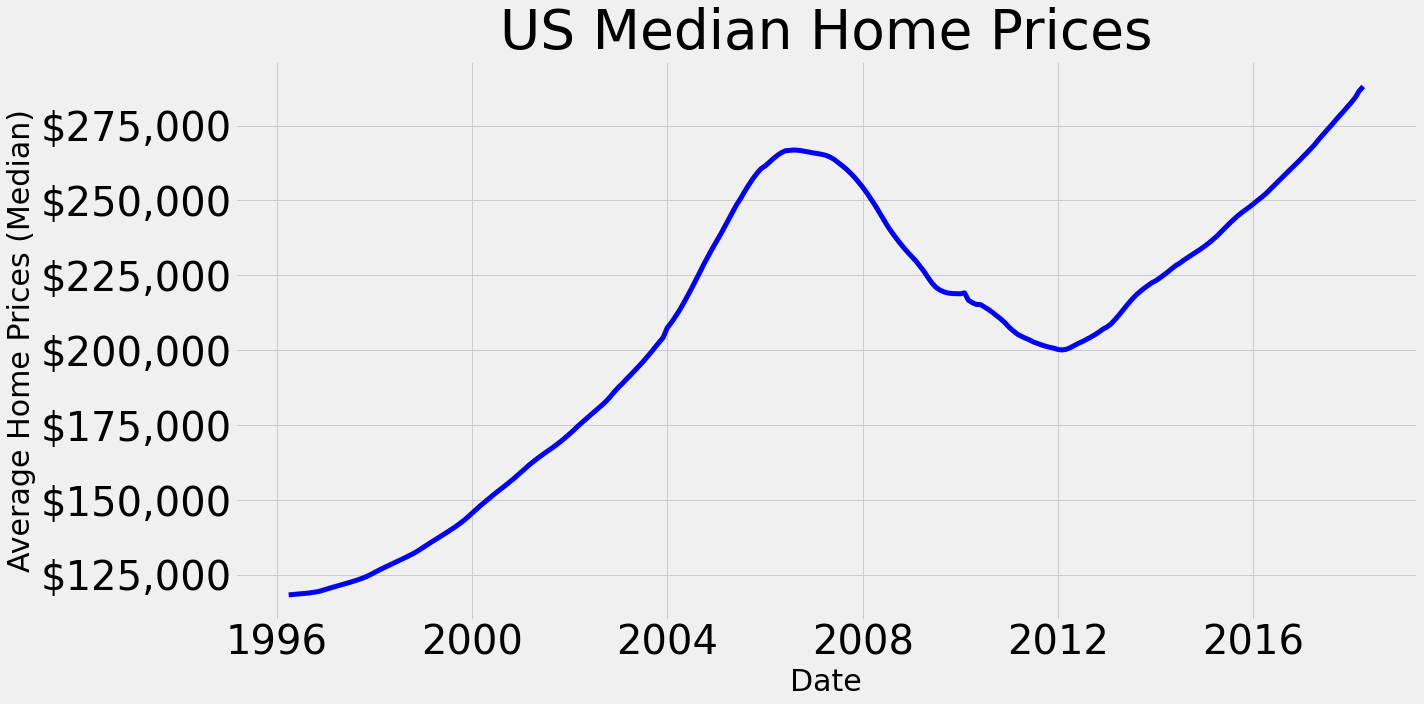

In [15]:
fig, ax = plt.subplots(figsize=(20, 10))

p = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='blue', linewidth=5);


p.set_xlabel("Date", fontsize = 30)
p.set_ylabel("Average Home Prices (Median)", fontsize = 30)

#y1 = p.axvline('2008-01', color='red') #housing market crash begins
#y2 = p.axvline('2012-01', color='red') #housing market crash ends
#ax.fill_between(y1, y2, color='yellow')

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

p.set_title("US Median Home Prices", fontsize = 55)
plt.figsize=(50,25)
#plt.grid(color='black', linestyle='--', linewidth=2)
plt.tight_layout()

plt.show();

### Analysis:
- Home Sales Values are on an upward trend, however there was a significant dip from aprox 2006 - 2012, before recovering and trending upward again.
- The dip was due to the US Housing Market Crash of 2008. (https://en.wikipedia.org/wiki/United_States_housing_bubble)
- The current trend seems to be at a lower and more stable rate than it was before the crash.

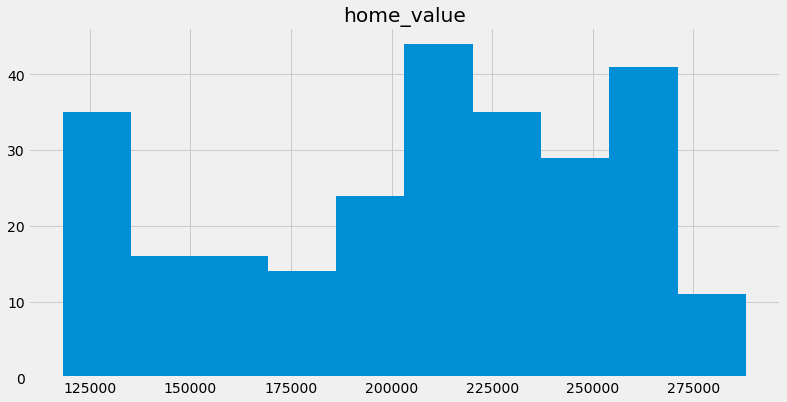

In [16]:
avg_home_df.hist(figsize = (12,6))
plt.show()

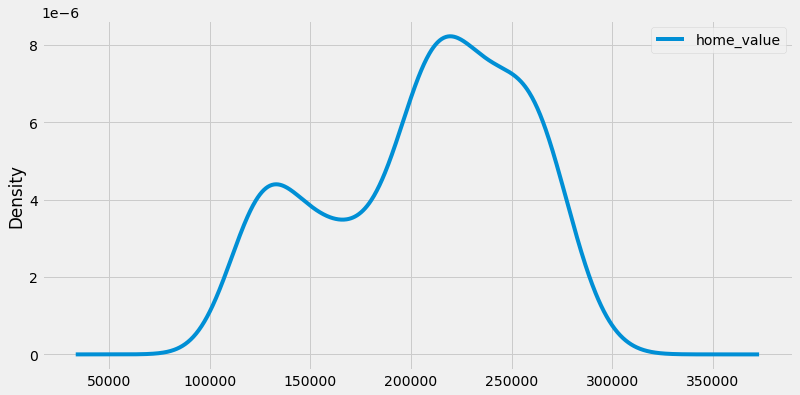

In [17]:
avg_home_df.plot(kind='kde', figsize = (12,6))
plt.show()

### Testing for Stationarity: Dickey Fuller Test

In [18]:
# Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test: \n')
#dftest = adfuller(data['#Passengers'])
dftest = adfuller(avg_home_df)

# Extract and display test results in a user friendly manner
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test: 

Test Statistic                 -1.89
p-value                         0.34
#Lags Used                      2.00
Number of Observations Used   262.00
Critical Value (1%)            -3.46
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64


### Analysis:
- The p-value is above .05, therefore I do NOT reject the null hypothesis, and therefore this data is NOT stationary.

## <b> Feature Engineering </b>

- I want to add additional features to the DataSet so that I can determine what data I want to analyze further and ultimately model.
- add: Region Mean, Region Growth, etc
- THE POINT IS TO IDENTIFY WHICH ZIPS ARE THE BEST PERFORMING SO I CAN NARROW DOWN THE DATA TO CAPTURE!!!!

In [19]:
new_df = ts.copy()

In [20]:
#making sure that all the data fields were changed to floats
new_df['2018-04'].dtype

dtype('float64')

In [21]:
new_df['mean'] = data_values.apply(lambda x: x.mean(), axis=1)
new_df.head(1)

RegionID ZipCode     City State    Metro CountyName  SizeRank    1996-04  \
0     84654   60657  Chicago    IL  Chicago       Cook         1 334,200.00   

     1996-05    1996-06  ...      2017-08      2017-09      2017-10  \
0 335,400.00 336,500.00  ... 1,007,500.00 1,007,800.00 1,009,600.00   

       2017-11      2017-12      2018-01      2018-02      2018-03  \
0 1,013,300.00 1,018,700.00 1,024,400.00 1,030,700.00 1,033,800.00   

       2018-04       mean  
0 1,030,600.00 743,978.87  

[1 rows x 273 columns]

In [22]:
#new_df.head(1)

# Recent Data (last 3 Years) DataFrame

<b> First, I will slice out the top quartile (75%) of mean home values. The top Quartile of avg US home values starts at 245,934. I will only be interested in Zip Codes that have a mean value of more than 246,000.</b>

In [23]:
avg_home_df.describe()

home_value
count      265.00
mean   206,661.51
std     47,809.38
min    118,299.12
25%    168,653.36
50%    215,113.13
75%    245,934.66
max    288,039.94

In [24]:
#recent_df = new_df[new_df['mean'] >= 246000]

In [25]:
#this is irrelevant and too easy to mistake for the ZipCode, so I will drop it.
new_df.drop(columns=['RegionID'], inplace=True)

In [26]:
new_df.describe()

SizeRank      1996-04      1996-05      1996-06      1996-07  \
count 14,723.00    13,684.00    13,684.00    13,684.00    13,684.00   
mean   7,362.00   118,299.12   118,419.04   118,537.42   118,653.07   
std    4,250.31    86,002.51    86,155.67    86,309.23    86,467.95   
min        1.00    11,300.00    11,500.00    11,600.00    11,800.00   
25%    3,681.50    68,800.00    68,900.00    69,100.00    69,200.00   
50%    7,362.00    99,500.00    99,500.00    99,700.00    99,700.00   
75%   11,042.50   143,200.00   143,300.00   143,225.00   143,225.00   
max   14,723.00 3,676,700.00 3,704,200.00 3,729,600.00 3,754,600.00   

           1996-08      1996-09      1996-10      1996-11      1996-12  ...  \
count    13,684.00    13,684.00    13,684.00    13,684.00    13,684.00  ...   
mean    118,780.25   118,927.53   119,120.52   119,345.35   119,685.08  ...   
std      86,650.94    86,872.08    87,151.85    87,479.81    87,912.69  ...   
min      11,800.00    12,000.00    12,100.00    12,200.00    12,300.00  ...   
25%      69,375.00    69,500.00    69,600.00    69,800.00    70,000.00  ...   
50%      99,800.00    99,900.00    99,950.00   100,100.00   100,300.00  ...   
75%     143,500.00   143,700.00   143,900.00   144,125.00   144,300.00  ...   
max   3,781,800.00 3,813,500.00 3,849,600.00 3,888,900.00 3,928,800.00  ...   

            2017-08       2017-09       2017-10       2017-11       2017-12  \
count     14,723.00     14,723.00     14,723.00     14,723.00     14,723.00   
mean     274,865.77    276,464.62    278,033.19    279,520.86    281,095.32   
std      361,467.76    362,756.27    364,460.95    365,600.33    367,045.39   
min       14,500.00     14,700.00     14,800.00     14,500.00     14,300.00   
25%      127,500.00    128,200.00    128,700.00    129,250.00    129,900.00   
50%      189,600.00    190,500.00    191,400.00    192,500.00    193,400.00   
75%      306,650.00    308,500.00    309,800.00    311,700.00    313,400.00   
max   18,703,500.00 18,605,300.00 18,569,400.00 18,428,800.00 18,307,100.00   

            2018-01       2018-02       2018-03       2018-04          mean  
count     14,723.00     14,723.00     14,723.00     14,723.00     14,723.00  
mean     282,657.06    284,368.69    286,511.38    288,039.94    205,653.02  
std      369,572.74    371,773.91    372,461.23    372,054.40    233,945.10  
min       14,100.00     13,900.00     13,800.00     13,800.00     18,660.20  
25%      130,600.00    131,050.00    131,950.00    132,400.00    102,711.70  
50%      194,100.00    195,000.00    196,700.00    198,100.00    150,634.72  
75%      315,100.00    316,850.00    318,850.00    321,100.00    235,686.04  
max   18,365,900.00 18,530,400.00 18,337,700.00 17,894,900.00 12,854,267.44  

[8 rows x 267 columns]

<b> Next, I will filter this df so that it only shows the data from the last 3 years. My plan is to analyze this historical data to narrow my search in order to minimize the number of zipcodes that I will have to model.</b>

In [27]:
new_df.iloc[:, 6:-41]

1996-04    1996-05    1996-06    1996-07    1996-08    1996-09  \
0     334,200.00 335,400.00 336,500.00 337,600.00 338,500.00 339,500.00   
1     235,700.00 236,900.00 236,700.00 235,400.00 233,300.00 230,600.00   
2     210,400.00 212,200.00 212,200.00 210,700.00 208,300.00 205,500.00   
3     498,100.00 500,900.00 503,100.00 504,600.00 505,500.00 505,700.00   
4      77,300.00  77,300.00  77,300.00  77,300.00  77,400.00  77,500.00   
...          ...        ...        ...        ...        ...        ...   
14718  94,600.00  94,300.00  94,000.00  93,700.00  93,400.00  93,200.00   
14719  92,700.00  92,500.00  92,400.00  92,200.00  92,100.00  91,900.00   
14720  57,100.00  57,300.00  57,500.00  57,700.00  58,000.00  58,200.00   
14721 191,100.00 192,400.00 193,700.00 195,000.00 196,300.00 197,700.00   
14722 176,400.00 176,300.00 176,100.00 176,000.00 175,900.00 175,800.00   

         1996-10    1996-11    1996-12    1997-01  ...      2014-03  \
0     340,400.00 341,300.00 342,600.00 344,400.00  ...   863,900.00   
1     227,300.00 223,400.00 219,600.00 215,800.00  ...   234,200.00   
2     202,500.00 199,800.00 198,300.00 197,300.00  ...   282,100.00   
3     505,300.00 504,200.00 503,600.00 503,400.00  ... 1,149,900.00   
4      77,600.00  77,700.00  77,700.00  77,800.00  ...   112,000.00   
...          ...        ...        ...        ...  ...          ...   
14718  93,000.00  92,900.00  92,700.00  92,600.00  ...   187,600.00   
14719  91,700.00  91,300.00  90,900.00  90,500.00  ...   180,000.00   
14720  58,400.00  58,700.00  59,100.00  59,500.00  ...   105,100.00   
14721 199,100.00 200,700.00 202,600.00 204,900.00  ...   528,900.00   
14722 175,800.00 176,000.00 176,200.00 176,500.00  ...   266,800.00   

           2014-04      2014-05      2014-06      2014-07      2014-08  \
0       872,900.00   883,300.00   889,500.00   892,800.00   893,600.00   
1       235,400.00   236,600.00   238,500.00   240,500.00   242,600.00   
2       284,200.00   286,000.00   288,300.00   290,700.00   293,300.00   
3     1,155,200.00 1,160,100.00 1,163,300.00 1,167,700.00 1,173,900.00   
4       112,500.00   112,700.00   113,100.00   113,900.00   114,400.00   
...            ...          ...          ...          ...          ...   
14718   187,300.00   187,300.00   188,100.00   189,600.00   190,800.00   
14719   180,000.00   181,400.00   181,900.00   182,200.00   183,300.00   
14720   105,200.00   104,800.00   104,200.00   104,200.00   104,700.00   
14721   532,000.00   535,200.00   538,500.00   538,300.00   543,700.00   
14722   269,200.00   271,500.00   273,800.00   276,200.00   278,600.00   

           2014-09      2014-10      2014-11      2014-12  
0       891,300.00   889,900.00   891,500.00   893,000.00  
1       244,700.00   246,300.00   247,600.00   249,600.00  
2       295,900.00   298,300.00   300,200.00   301,300.00  
3     1,175,100.00 1,173,500.00 1,175,500.00 1,178,500.00  
4       114,500.00   114,400.00   114,300.00   114,400.00  
...            ...          ...          ...          ...  
14718   189,800.00   188,500.00   189,400.00   191,100.00  
14719   185,800.00   187,700.00   187,500.00   184,900.00  
14720   104,600.00   104,600.00   104,800.00   104,800.00  
14721   551,400.00   552,800.00   547,100.00   537,900.00  
14722   280,400.00   282,000.00   283,600.00   285,900.00  

[14723 rows x 225 columns]

In [28]:
recent_df= new_df.drop(new_df.iloc[:, 6:-41], axis=1)

In [29]:
recent_df.describe()

SizeRank       2015-01       2015-02       2015-03       2015-04  \
count 14,723.00     14,723.00     14,723.00     14,723.00     14,723.00   
mean   7,362.00    234,691.19    235,760.28    236,836.43    238,009.76   
std    4,250.31    307,979.07    312,430.39    316,062.13    317,997.85   
min        1.00     13,600.00     13,600.00     13,400.00     13,300.00   
25%    3,681.50    110,000.00    110,300.00    111,000.00    111,500.00   
50%    7,362.00    162,900.00    163,300.00    163,700.00    164,200.00   
75%   11,042.50    260,250.00    261,200.00    262,000.00    263,450.00   
max   14,723.00 15,663,600.00 16,271,900.00 16,684,700.00 16,644,000.00   

            2015-05       2015-06       2015-07       2015-08       2015-09  \
count     14,723.00     14,723.00     14,723.00     14,723.00     14,723.00   
mean     239,354.21    240,744.12    242,103.53    243,424.44    244,658.27   
std      319,992.45    323,438.78    327,255.34    330,084.81    331,903.68   
min       13,300.00     13,500.00     13,800.00     14,000.00     14,200.00   
25%      112,150.00    112,600.00    113,100.00    113,500.00    114,000.00   
50%      165,100.00    165,800.00    166,500.00    167,100.00    167,800.00   
75%      264,950.00    266,600.00    268,200.00    269,900.00    271,400.00   
max   16,659,500.00 17,149,200.00 17,775,200.00 17,965,800.00 17,853,100.00   

       ...       2017-08       2017-09       2017-10       2017-11  \
count  ...     14,723.00     14,723.00     14,723.00     14,723.00   
mean   ...    274,865.77    276,464.62    278,033.19    279,520.86   
std    ...    361,467.76    362,756.27    364,460.95    365,600.33   
min    ...     14,500.00     14,700.00     14,800.00     14,500.00   
25%    ...    127,500.00    128,200.00    128,700.00    129,250.00   
50%    ...    189,600.00    190,500.00    191,400.00    192,500.00   
75%    ...    306,650.00    308,500.00    309,800.00    311,700.00   
max    ... 18,703,500.00 18,605,300.00 18,569,400.00 18,428,800.00   

            2017-12       2018-01       2018-02       2018-03       2018-04  \
count     14,723.00     14,723.00     14,723.00     14,723.00     14,723.00   
mean     281,095.32    282,657.06    284,368.69    286,511.38    288,039.94   
std      367,045.39    369,572.74    371,773.91    372,461.23    372,054.40   
min       14,300.00     14,100.00     13,900.00     13,800.00     13,800.00   
25%      129,900.00    130,600.00    131,050.00    131,950.00    132,400.00   
50%      193,400.00    194,100.00    195,000.00    196,700.00    198,100.00   
75%      313,400.00    315,100.00    316,850.00    318,850.00    321,100.00   
max   18,307,100.00 18,365,900.00 18,530,400.00 18,337,700.00 17,894,900.00   

               mean  
count     14,723.00  
mean     205,653.02  
std      233,945.10  
min       18,660.20  
25%      102,711.70  
50%      150,634.72  
75%      235,686.04  
max   12,854,267.44  

[8 rows x 42 columns]

In [30]:
recent_df.drop(columns = ['mean'], inplace=True)
recent_df.head(1)

ZipCode     City State    Metro CountyName  SizeRank    2015-01    2015-02  \
0   60657  Chicago    IL  Chicago       Cook         1 893,000.00 895,000.00   

     2015-03    2015-04  ...      2017-07      2017-08      2017-09  \
0 901,200.00 909,400.00  ... 1,005,500.00 1,007,500.00 1,007,800.00   

       2017-10      2017-11      2017-12      2018-01      2018-02  \
0 1,009,600.00 1,013,300.00 1,018,700.00 1,024,400.00 1,030,700.00   

       2018-03      2018-04  
0 1,033,800.00 1,030,600.00  

[1 rows x 46 columns]

In [31]:
 recent_df.iloc[:, 6:]

2015-01      2015-02      2015-03      2015-04      2015-05  \
0       893,000.00   895,000.00   901,200.00   909,400.00   915,000.00   
1       251,400.00   253,000.00   255,200.00   258,000.00   261,200.00   
2       301,700.00   302,400.00   303,600.00   306,200.00   309,100.00   
3     1,176,400.00 1,174,600.00 1,178,500.00 1,185,700.00 1,192,900.00   
4       114,700.00   115,000.00   115,000.00   115,200.00   115,600.00   
...            ...          ...          ...          ...          ...   
14718   192,400.00   193,300.00   193,400.00   192,000.00   191,200.00   
14719   183,000.00   181,900.00   182,300.00   184,400.00   186,300.00   
14720   104,600.00   104,400.00   104,400.00   105,000.00   105,900.00   
14721   520,700.00   517,500.00   538,300.00   552,700.00   545,800.00   
14722   287,500.00   288,300.00   289,100.00   291,000.00   293,300.00   

           2015-06      2015-07      2015-08      2015-09      2015-10  ...  \
0       916,700.00   917,700.00   919,800.00   925,800.00   937,100.00  ...   
1       264,700.00   268,400.00   271,400.00   273,600.00   275,200.00  ...   
2       311,900.00   314,100.00   316,300.00   319,000.00   322,000.00  ...   
3     1,198,800.00 1,200,400.00 1,198,900.00 1,200,200.00 1,207,400.00  ...   
4       115,900.00   115,600.00   115,400.00   115,400.00   115,500.00  ...   
...            ...          ...          ...          ...          ...  ...   
14718   190,900.00   190,900.00   191,100.00   191,900.00   191,400.00  ...   
14719   188,300.00   190,800.00   191,800.00   189,500.00   187,700.00  ...   
14720   106,800.00   107,500.00   107,700.00   107,800.00   108,300.00  ...   
14721   536,100.00   538,300.00   537,800.00   539,000.00   543,500.00  ...   
14722   295,200.00   296,900.00   298,400.00   299,200.00   299,500.00  ...   

           2017-07      2017-08      2017-09      2017-10      2017-11  \
0     1,005,500.00 1,007,500.00 1,007,800.00 1,009,600.00 1,013,300.00   
1       308,000.00   310,000.00   312,500.00   314,100.00   315,000.00   
2       321,000.00   320,600.00   320,200.00   320,400.00   320,800.00   
3     1,289,800.00 1,287,700.00 1,287,400.00 1,291,500.00 1,296,600.00   
4       119,100.00   119,400.00   120,000.00   120,300.00   120,300.00   
...            ...          ...          ...          ...          ...   
14718   216,800.00   217,700.00   218,600.00   218,500.00   218,100.00   
14719   202,100.00   208,400.00   212,200.00   215,200.00   214,300.00   
14720   121,800.00   122,800.00   124,600.00   126,700.00   128,800.00   
14721   662,800.00   671,200.00   682,400.00   695,600.00   695,500.00   
14722   333,800.00   336,400.00   339,700.00   343,800.00   346,800.00   

           2017-12      2018-01      2018-02      2018-03      2018-04  
0     1,018,700.00 1,024,400.00 1,030,700.00 1,033,800.00 1,030,600.00  
1       316,600.00   318,100.00   319,600.00   321,100.00   321,800.00  
2       321,200.00   321,200.00   323,000.00   326,900.00   329,900.00  
3     1,299,000.00 1,302,700.00 1,306,400.00 1,308,500.00 1,307,000.00  
4       120,300.00   120,300.00   120,500.00   121,000.00   121,500.00  
...            ...          ...          ...          ...          ...  
14718   216,400.00   213,100.00   209,800.00   209,200.00   209,300.00  
14719   213,100.00   213,700.00   218,300.00   222,700.00   225,800.00  
14720   130,600.00   131,700.00   132,500.00   133,000.00   133,400.00  
14721   694,700.00   706,400.00   705,300.00   681,500.00   664,400.00  
14722   348,900.00   350,400.00   353,000.00   356,000.00   357,200.00  

[14723 rows x 40 columns]

In [32]:
recent_df['3yr_Mean'] = recent_df.iloc[:, 6:].apply(lambda x: x.mean(), axis=1)
recent_df['ROI'] = recent_df.iloc[:, 6:].apply(lambda x: x['2018-04'] - x['2015-01'], axis=1)
recent_df['ROI%'] = recent_df.iloc[:, 6:].apply(lambda x: x['ROI'] / x['2015-01'], axis=1)

In [33]:
recent_df.head(1)

ZipCode     City State    Metro CountyName  SizeRank    2015-01    2015-02  \
0   60657  Chicago    IL  Chicago       Cook         1 893,000.00 895,000.00   

     2015-03    2015-04  ...      2017-10      2017-11      2017-12  \
0 901,200.00 909,400.00  ... 1,009,600.00 1,013,300.00 1,018,700.00   

       2018-01      2018-02      2018-03      2018-04   3yr_Mean        ROI  \
0 1,024,400.00 1,030,700.00 1,033,800.00 1,030,600.00 971,970.00 137,600.00   

   ROI%  
0  0.15  

[1 rows x 49 columns]

<b> Recent_df now contains all data from the last 3 years t. I will now sort the data by ROI Percentage Gain </b>

In [34]:
recent_df.sort_values('2018-04', ascending=False).head()

ZipCode      City State          Metro CountyName  SizeRank  \
272     10021  New York    NY       New York   New York       273   
20      10011  New York    NY       New York   New York        21   
508     10014  New York    NY       New York   New York       509   
21      10128  New York    NY       New York   New York        22   
10237   94027  Atherton    CA  San Francisco  San Mateo     10238   

            2015-01       2015-02       2015-03       2015-04  ...  \
272   15,663,600.00 16,271,900.00 16,684,700.00 16,644,000.00  ...   
20    10,476,500.00 10,544,400.00 10,569,300.00 10,572,500.00  ...   
508   10,078,900.00 10,143,700.00 10,075,800.00  9,938,600.00  ...   
21     7,384,300.00  7,618,100.00  7,914,200.00  8,244,000.00  ...   
10237  4,846,700.00  4,950,900.00  5,053,600.00  5,140,300.00  ...   

            2017-10       2017-11       2017-12       2018-01       2018-02  \
272   18,569,400.00 18,428,800.00 18,307,100.00 18,365,900.00 18,530,400.00   
20    12,050,100.00 12,016,300.00 11,946,500.00 11,978,100.00 11,849,300.00   
508    9,631,000.00  9,515,800.00  9,492,800.00  9,524,900.00  9,373,400.00   
21     7,427,300.00  7,371,400.00  7,342,700.00  7,353,300.00  7,350,300.00   
10237  6,315,400.00  6,429,100.00  6,581,800.00  6,705,000.00  6,764,600.00   

            2018-03       2018-04      3yr_Mean           ROI  ROI%  
272   18,337,700.00 17,894,900.00 18,272,682.50  2,231,300.00  0.14  
20    11,563,000.00 11,478,300.00 11,546,380.00  1,001,800.00  0.10  
508    9,119,600.00  8,959,300.00  9,493,907.50 -1,119,600.00 -0.11  
21     7,363,000.00  7,386,600.00  7,564,977.50      2,300.00  0.00  
10237  6,788,400.00  6,796,500.00  5,779,180.00  1,949,800.00  0.40  

[5 rows x 49 columns]

In [35]:
top_roi = recent_df[recent_df['ROI%'] >= 0.5]

In [36]:
top_roi.sort_values('2018-04', ascending=False)

ZipCode                       City State  \
11977   98039                     Medina    WA   
1791    94040              Mountain View    CA   
516     94087                  Sunnyvale    CA   
6345    94041              Mountain View    CA   
1125    98004                   Bellevue    WA   
2580    94043              Mountain View    CA   
582     94086                  Sunnyvale    CA   
5919    94618                    Oakland    CA   
7007    11963                     Noyack    NY   
3964    98040              Mercer Island    WA   
117     11211                   New York    NY   
7770    95130                   San Jose    CA   
475     11216                   New York    NY   
289     95051                Santa Clara    CA   
4730    94704                   Berkeley    CA   
656     95008                   Campbell    CA   
1464    94610                    Oakland    CA   
2386    95134                   San Jose    CA   
3877    95117                   San Jose    CA   
536     95125                   San Jose    CA   
1276    95124                   San Jose    CA   
191     07302                Jersey City    NJ   
75      90034                Los Angeles    CA   
1856    95050                Santa Clara    CA   
1773    02139                  Cambridge    MA   
5325    95054                Santa Clara    CA   
4026    98112                    Seattle    WA   
3714    94132              San Francisco    CA   
1484    98102                    Seattle    WA   
12604   94038                 Moss Beach    CA   
3602    95118                   San Jose    CA   
2274    95128                   San Jose    CA   
2834    90230                Culver City    CA   
963     98109                    Seattle    WA   
3349    95132                   San Jose    CA   
3505    94063               Redwood City    CA   
5469    98005                   Bellevue    WA   
2435    94401                  San Mateo    CA   
5328    94089                  Sunnyvale    CA   
1861    95126                   San Jose    CA   
4677    95131                   San Jose    CA   
363     95035                   Milpitas    CA   
2167    98006                   Bellevue    WA   
2043    11102                   New York    NY   
1065    11106                   New York    NY   
12027   32461          Panama City Beach    FL   
4084    94609                    Oakland    CA   
1269    98033                   Kirkland    WA   
5274    95133                   San Jose    CA   
1061    98105                    Seattle    WA   
10655   95139                   San Jose    CA   
67      98052                    Redmond    WA   
513     95112                   San Jose    CA   
2253    94560                     Newark    CA   
3462    98029                   Issaquah    WA   
438     98122                    Seattle    WA   
161     98103                    Seattle    WA   
331     98115                    Seattle    WA   
4662    98008                   Bellevue    WA   
6419    95110                   San Jose    CA   
4023    98110          Bainbridge Island    WA   
3470    98007                   Bellevue    WA   
190     11233                   New York    NY   
2157    98107                    Seattle    WA   
6330    07086                  Weehawken    NJ   
1768    94608                    Oakland    CA   
2179    98117                    Seattle    WA   
2537    98116                    Seattle    WA   
1511    02127                     Boston    MA   
5516    98177                  Shoreline    WA   
715     90006                Los Angeles    CA   
5992    98136                    Seattle    WA   
2676    95116                   San Jose    CA   
2598    98144                    Seattle    WA   
3121    95122                   San Jose    CA   
1224    90016                Los Angeles    CA   
3945    98011                    Bothell    WA   
7301    98065                 Snoqualmie    WA   
548     98034                   Kirkland    WA   
4713  

### Target Zips

In [37]:
target_zips = top_roi[top_roi['2018-04'] <= 500000]

In [38]:
target_zips.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 570 entries, 17 to 14709
Data columns (total 49 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ZipCode     570 non-null    object 
 1   City        570 non-null    object 
 2   State       570 non-null    object 
 3   Metro       570 non-null    object 
 4   CountyName  570 non-null    object 
 5   SizeRank    570 non-null    int64  
 6   2015-01     570 non-null    float64
 7   2015-02     570 non-null    float64
 8   2015-03     570 non-null    float64
 9   2015-04     570 non-null    float64
 10  2015-05     570 non-null    float64
 11  2015-06     570 non-null    float64
 12  2015-07     570 non-null    float64
 13  2015-08     570 non-null    float64
 14  2015-09     570 non-null    float64
 15  2015-10     570 non-null    float64
 16  2015-11     570 non-null    float64
 17  2015-12     570 non-null    float64
 18  2016-01     570 non-null    float64
 19  2016-02     570 non-null  

In [39]:
target_zips.head(1)

ZipCode       City State      Metro CountyName  SizeRank    2015-01  \
17   37211  Nashville    TN  Nashville   Davidson        18 170,600.00   

      2015-02    2015-03    2015-04  ...    2017-10    2017-11    2017-12  \
17 171,700.00 172,800.00 174,400.00  ... 248,800.00 251,100.00 253,900.00   

      2018-01    2018-02    2018-03    2018-04   3yr_Mean       ROI  ROI%  
17 256,500.00 259,000.00 262,100.00 264,200.00 218,910.00 93,600.00  0.55  

[1 rows x 49 columns]

In [40]:
target_zips = target_zips.sort_values('2018-04', ascending=False)

In [41]:
#ts[ts['City'] == 'Charleston']

In [427]:
# dropping unecessary data for ease of reading
target_zips = target_zips.drop(target_zips.iloc[:, 7:-4], axis=1)

### <b> List of Target ZipCodes </b>

In [429]:
target_zips.sort_values('ROI', ascending=False).head(15)

ZipCode               City State                           Metro  \
4678    29403         Charleston    SC                      Charleston   
3781    98146             Burien    WA                         Seattle   
11899   95570           Trinidad    CA                          Eureka   
11136   37046      College Grove    TN                       Nashville   
5021    98043  Mountlake Terrace    WA                         Seattle   
4733    98178   Bryn Mawr-Skyway    WA                         Seattle   
4712    94621            Oakland    CA                   San Francisco   
6515    90304          Inglewood    CA  Los Angeles-Long Beach-Anaheim   
1921    02128             Boston    MA                          Boston   
2804    98168             Burien    WA                         Seattle   
4860    02121             Boston    MA                          Boston   
2155    80204             Denver    CO                          Denver   
13123   95918      Browns Valley    CA                       Yuba City   
319     07087         Union City    NJ                        New York   
10589   98359             Olalla    WA                       Bremerton   

        CountyName  SizeRank    2015-01    2018-04   3yr_Mean        ROI  ROI%  
4678    Charleston      4679 261,400.00 462,700.00 343,962.50 201,300.00  0.77  
3781          King      3782 292,100.00 491,100.00 391,625.00 199,000.00  0.68  
11899     Humboldt     11900 282,300.00 480,600.00 375,162.50 198,300.00  0.70  
11136   Williamson     11137 268,900.00 459,800.00 350,822.50 190,900.00  0.71  
5021     Snohomish      5022 287,800.00 474,700.00 366,512.50 186,900.00  0.65  
4733          King      4734 270,300.00 455,100.00 365,355.00 184,800.00  0.68  
4712       Alameda      4713 231,000.00 405,500.00 315,055.00 174,500.00  0.76  
6515   Los Angeles      6516 326,100.00 494,300.00 404,962.50 168,200.00  0.52  
1921       Suffolk      1922 323,700.00 489,900.00 398,212.50 166,200.00  0.51  
2804          King      2805 229,800.00 393,300.00 313,725.00 163,500.00  0.71  
4860       Suffolk      4861 290,100.00 452,700.00 376,882.50 162,600.00  0.56  
2155        Denver      2156 210,500.00 371,600.00 291,225.00 161,100.00  0.77  
13123         Yuba     13124 312,500.00 473,600.00 377,520.00 161,100.00  0.52  
319         Hudson       320 289,500.00 448,900.00 336,135.00 159,400.00  0.55  
10589       Kitsap     10590 285,700.00 444,600.00 370,297.50 158,900.00  0.56

# Target Zips

### Turning Target Zips into Time Series

<b>These are the top ten zips with the following criteria:
- Avg Home Value aprox 500,000 as of most recent data point (April 2018)
- Ranked by ROI total amount over the previous 3 years</b>

In [43]:
data = ts[ts['ZipCode'] == '29403']
melted_data = melt_data(data)
zip_29403_ts = melted_data

In [44]:
data = ts[ts['ZipCode'] == '98178']
melted_data = melt_data(data)
zip_98178_ts = melted_data

In [45]:
data = ts[ts['ZipCode'] == '98168']
melted_data = melt_data(data)
zip_98168_ts = melted_data

In [46]:
data = ts[ts['ZipCode'] == '94621']
melted_data = melt_data(data)
zip_94621_ts = melted_data

In [47]:
data = ts[ts['ZipCode'] == '98146']
melted_data = melt_data(data)
zip_98146_ts = melted_data

In [48]:
data = ts[ts['ZipCode'] == '95570']
melted_data = melt_data(data)
zip_95570_ts = melted_data

In [49]:
data = ts[ts['ZipCode'] == '37046']
melted_data = melt_data(data)
zip_37046_ts = melted_data

In [50]:
data = ts[ts['ZipCode'] == '98043']
melted_data = melt_data(data)
zip_98043_ts = melted_data

In [51]:
data = ts[ts['ZipCode'] == '98178']
melted_data = melt_data(data)
zip_98178_ts = melted_data

In [52]:
data = ts[ts['ZipCode'] == '90304']
melted_data = melt_data(data)
zip_90304_ts = melted_data

In [53]:
data = ts[ts['ZipCode'] == '02128']
melted_data = melt_data(data)
zip_02128_ts = melted_data

In [54]:
data = ts[ts['ZipCode'] == '02121']
melted_data = melt_data(data)
zip_02121_ts = melted_data_ts = melted_data

In [55]:
data = ts[ts['ZipCode'] == '95918']
melted_data = melt_data(data)
zip_95918_ts = melted_data

In [56]:
data = ts[ts['ZipCode'] == '07087']
melted_data = melt_data(data)
zip_07087_ts = melted_data

In [57]:
data = ts[ts['ZipCode'] == '90304']
melted_data = melt_data(data)
zip_90304_ts = melted_data

In [58]:
data = ts[ts['ZipCode'] == '80102']
melted_data = melt_data(data)
zip_80102_ts = melted_data

In [59]:
data = ts[ts['ZipCode'] == '98359']
melted_data = melt_data(data)
zip_98359_ts = melted_data

In [60]:
data = ts[ts['ZipCode'] == '84757']
melted_data = melt_data(data)
zip_84757_ts = melted_data

In [61]:
data = ts[ts['ZipCode'] == '89704']
melted_data = melt_data(data)
zip_89704_ts = melted_data

In [62]:
data = ts[ts['ZipCode'] == '80204']
melted_data = melt_data(data)
zip_80204_ts = melted_data

### Visual = Comparing Top 5 Target Zips to National Average

maybe get rid of this visual as the individual ones tell the same story. Although this could be useful for the presentation.
- if i keep it. make sure it reflects the zip codes that i modeled.

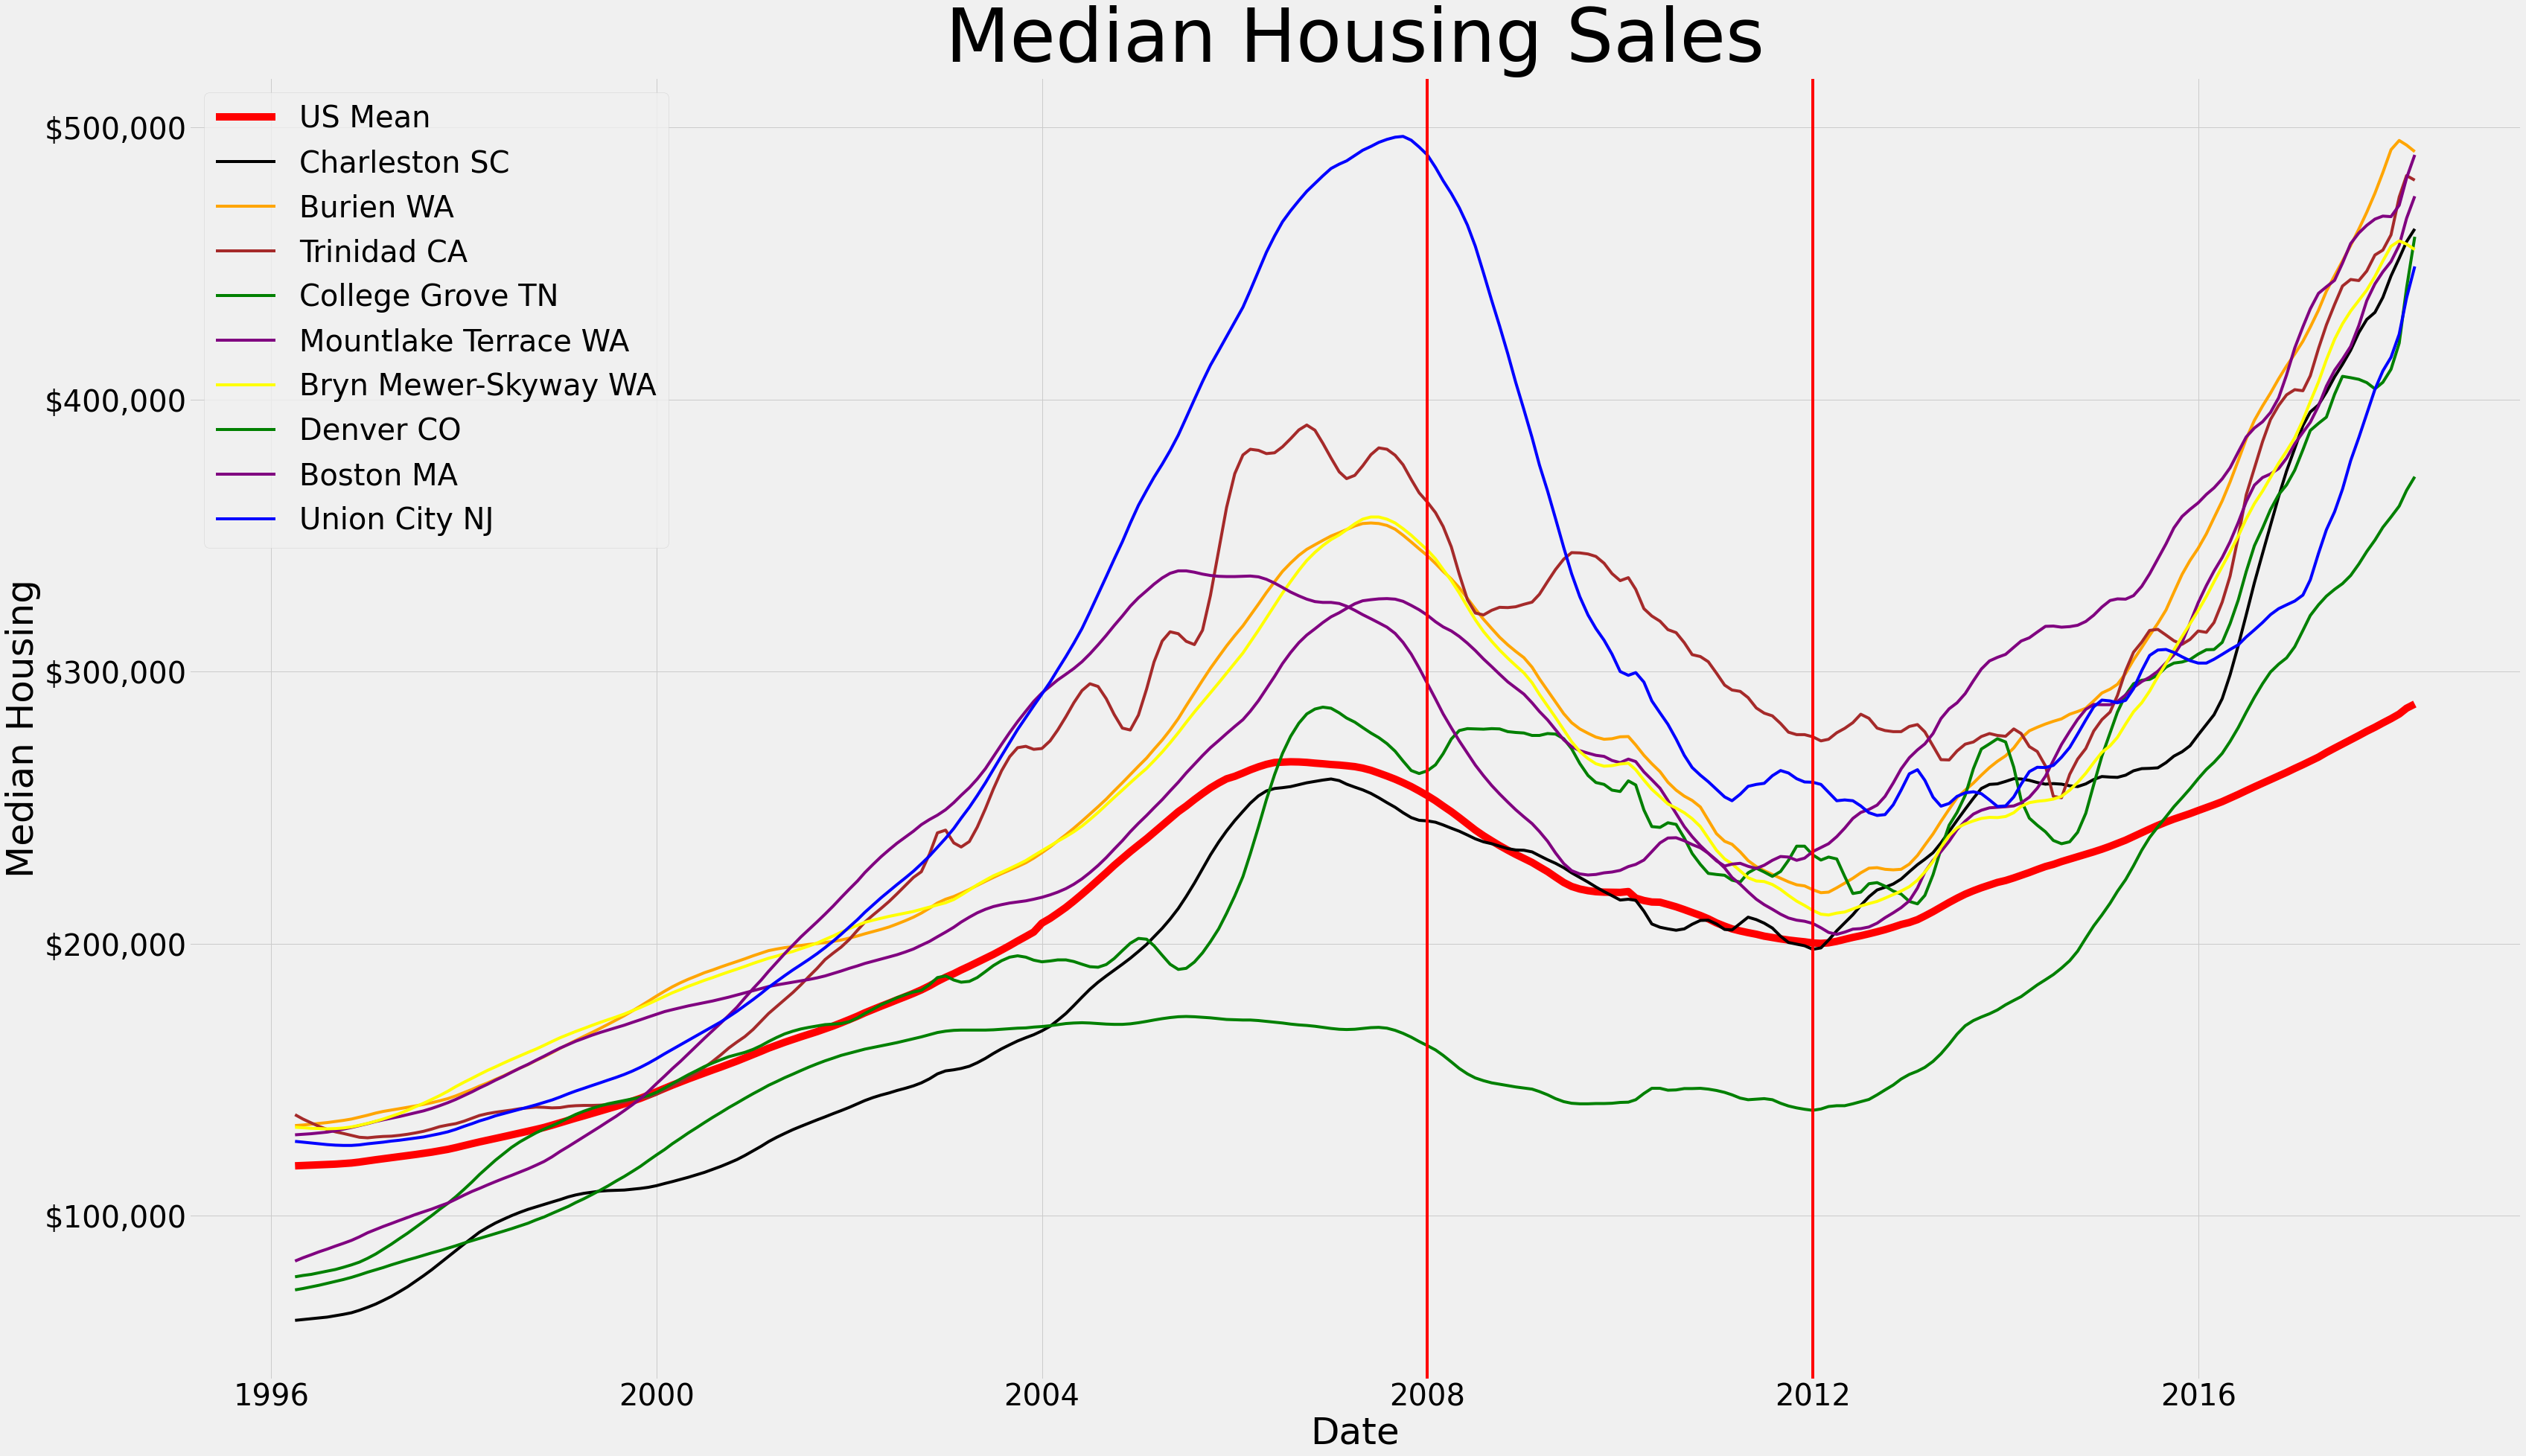

In [430]:
fig, ax = plt.subplots(figsize=(50, 30))

p = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='red', label='US Mean', linewidth = 10);
p = sns.lineplot(data=zip_29403_ts, x='time', y='value', color='black', label='Charleston SC');
p = sns.lineplot(data=zip_98146_ts, x='time', y='value', color='orange', label='Burien WA');
p = sns.lineplot(data=zip_95570_ts, x='time', y='value', color='brown', label='Trinidad CA');
p = sns.lineplot(data=zip_37046_ts, x='time', y='value', color='green', label='College Grove TN');
p = sns.lineplot(data=zip_98043_ts, x='time', y='value', color='purple', label='Mountlake Terrace WA');
p = sns.lineplot(data=zip_98178_ts, x='time', y='value', color='yellow', label='Bryn Mewer-Skyway WA');
p = sns.lineplot(data=zip_80204_ts, x='time', y='value', color='green', label='Denver CO');
p = sns.lineplot(data=zip_02128_ts, x='time', y='value', color='purple', label='Boston MA');
#line10 = sns.lineplot(data=zip_02121_ts, x='time', y='value', color='blue', label='02121');
p = sns.lineplot(data=zip_07087_ts, x='time', y='value', color='blue', label='Union City NJ');

p.set_xlabel("Date", fontsize = 50)
p.set_ylabel("Median Housing", fontsize = 50)

y1 = p.axvline('2008-01', color='red') #housing market crash begins
y2 = p.axvline('2012-01', color='red') #housing market crash ends
#ax.fill_between(y1, y2)

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)

fmt = '${x:,.0f}'
tick = mtick.StrMethodFormatter(fmt)
ax.yaxis.set_major_formatter(tick) 

ax.legend(fontsize=40)

p.set_title("Median Housing Sales", fontsize = 100)
plt.figsize=(50,25)

plt.show();

### Analysis: 
- These Zips have avg home values that are increasing at a much higher rate than the national average.

# Modeling

### Param Search Function

In [65]:
def sarimax_param_search(ts):
    
    # Setting up parameter combinations.
    #p = d = q = (0, 1)
    p = d = q = (0, 1, 2)

    pdq = [(ar, diff, ma) for ar in p for diff in d for ma in q]
    pdqs = [(c[0], c[1], c[2], 12) for c in pdq]

    # Iterate and try models.
    combo, value = (None, None)
    for pdq_combo in pdq:
        for pdqs_combo in pdqs:
            model = SARIMAX(
                ts, 
                order=pdq_combo,
                seasonal_order=pdqs_combo,
                enforce_stationarity=False,
                enforce_invertibility=False
                )
            output = model.fit()

            if value is None or output.aic < value:
                combo, value = ((pdq_combo, pdqs_combo), output.aic)
                print('SARIMA Combos:', (pdq_combo, pdqs_combo),'AIC:', output.aic)
                
                combo = combo
                
            
    return print(f'\n{"*"*20}\nOptimal SARIMA order: {combo}')

In [66]:
#sarimax_param_search(avg_home_df)

In [67]:
#AIC: 3400.45
avg_home_df_combo_1 = ((1, 1, 1), (1, 1, 1, 12))

In [68]:
#advanced combo search (0:2)
#sarimax_param_search(avg_home_df)

In [69]:
#advanced search combo: AIC: 3112.12
avg_home_df_combo_2 = ((1, 2, 2), (2, 2, 2, 12))

## <b>Modeling</b>

### <b><u> Avg Home Prices for US </b></u>

#### Model #1

In [70]:
combo = avg_home_df_combo_1
#combo = avg_home_df_combo_2

In [453]:
temp_ts = avg_home_df

SPLIT = int(temp_ts.shape[0]*0.8)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

In [454]:
# Model 1
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         home_value   No. Observations:                  212
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1365.256
Date:                            Sat, 21 May 2022   AIC                           2740.511
Time:                                    13:42:06   BIC                           2756.613
Sample:                                04-01-1996   HQIC                          2747.037
                                     - 11-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9603      0.029     32.707      0.000       0.903       1.018
ma.L1         -0.2056      0.046     -4.452      0.000      -0.296      -0.115
ar.S.L12      -0.3825      0.058     -6.574      0.000      -0.497      -0.268
ma.S.L12      -0.0199      0.061     -0.324      0.746      -0.140       0.100
sigma2       1.67e+05   9352.934     17.852      0.000    1.49e+05    1.85e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.79   Jarque-Bera (JB):              1266.95
Prob(Q):                              0.37   Prob(JB):                         0.00
Heteroskedasticity (H):              33.12   Skew:                            -0.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [455]:
avg_home_model_1 = sarima_model

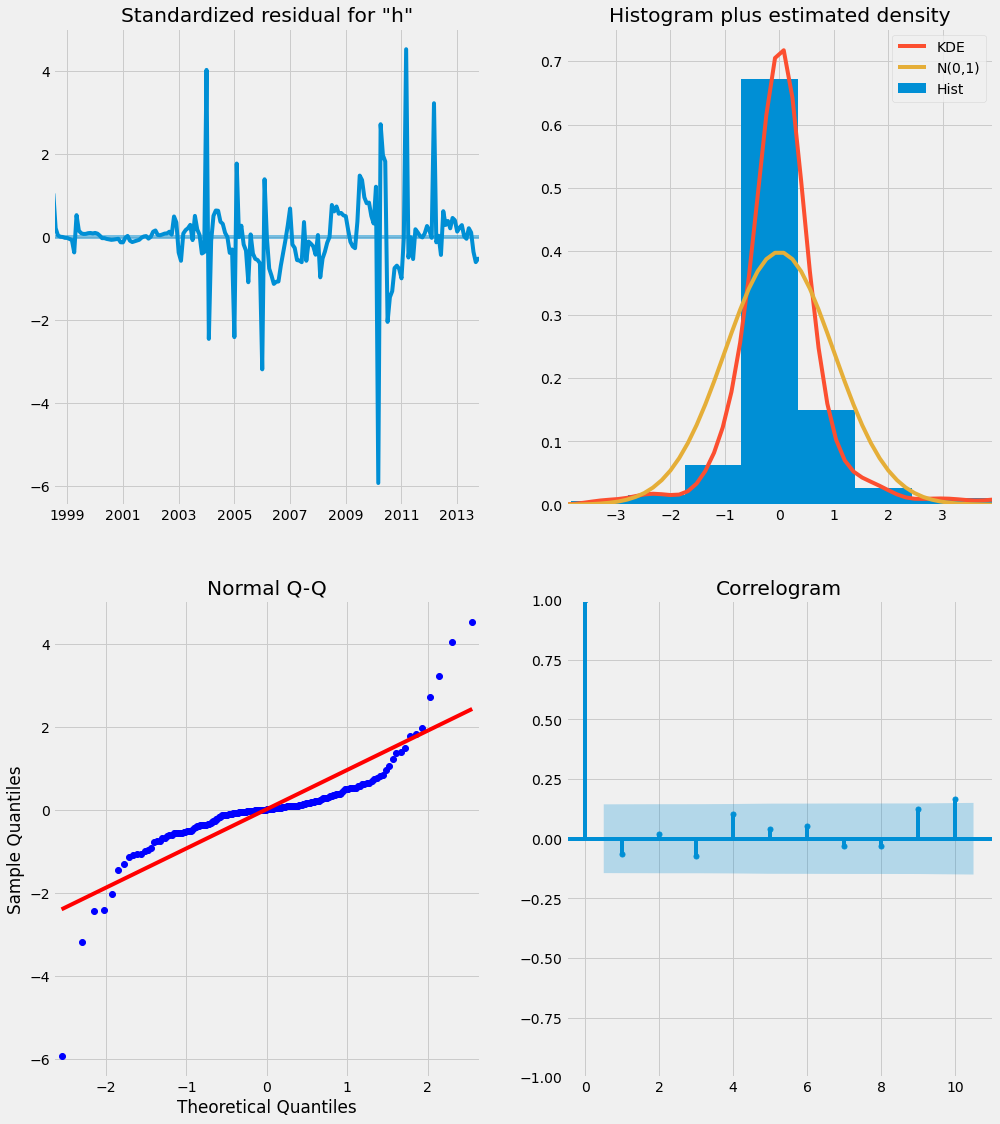

In [456]:
avg_home_model_1.plot_diagnostics(figsize=(15, 18))
plt.show()

#### Analysis: 

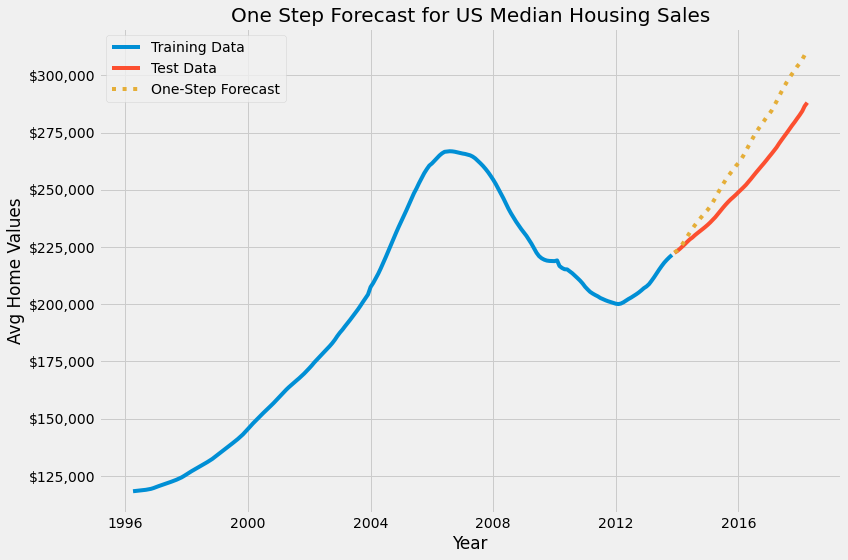

In [457]:
 pred = avg_home_model_1.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=True)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')

ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("One Step Forecast for US Median Housing Sales", fontsize = 20)

ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [76]:
avg_home_df.head()

home_value
time                  
1996-04-01  118,299.12
1996-05-01  118,419.04
1996-06-01  118,537.42
1996-07-01  118,653.07
1996-08-01  118,780.25

In [79]:
y_forecasted = pred.predicted_mean
y_truth = test['home_value']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 225714435.77
The Root Mean Squared Error is 15023.8


#### Model #2

In [80]:
combo = avg_home_df_combo_2

In [81]:
temp_ts = avg_home_df

SPLIT = int(temp_ts.shape[0]*0.8)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

In [82]:
# Model 2
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         home_value   No. Observations:                  212
Model:             SARIMAX(1, 2, 2)x(2, 2, 2, 12)   Log Likelihood               -1182.301
Date:                            Sat, 21 May 2022   AIC                           2380.602
Time:                                    12:28:54   BIC                           2405.153
Sample:                                04-01-1996   HQIC                          2390.572
                                     - 11-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3946      0.112     -3.517      0.000      -0.615      -0.175
ma.L1          0.1510      0.113      1.333      0.183      -0.071       0.373
ma.L2         -0.0122      0.070     -0.175      0.861      -0.150       0.125
ar.S.L12       0.2368      0.071      3.353      0.001       0.098       0.375
ar.S.L24      -0.0501      0.045     -1.114      0.265      -0.138       0.038
ma.S.L12      -1.9123      0.531     -3.603      0.000      -2.953      -0.872
ma.S.L24       0.9653      0.502      1.923      0.054      -0.018       1.949
sigma2      1.196e+05   6.55e+04      1.825      0.068   -8865.671    2.48e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              1363.30
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               3.24   Skew:                            -1.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [83]:
avg_home_model_2 = sarima_model

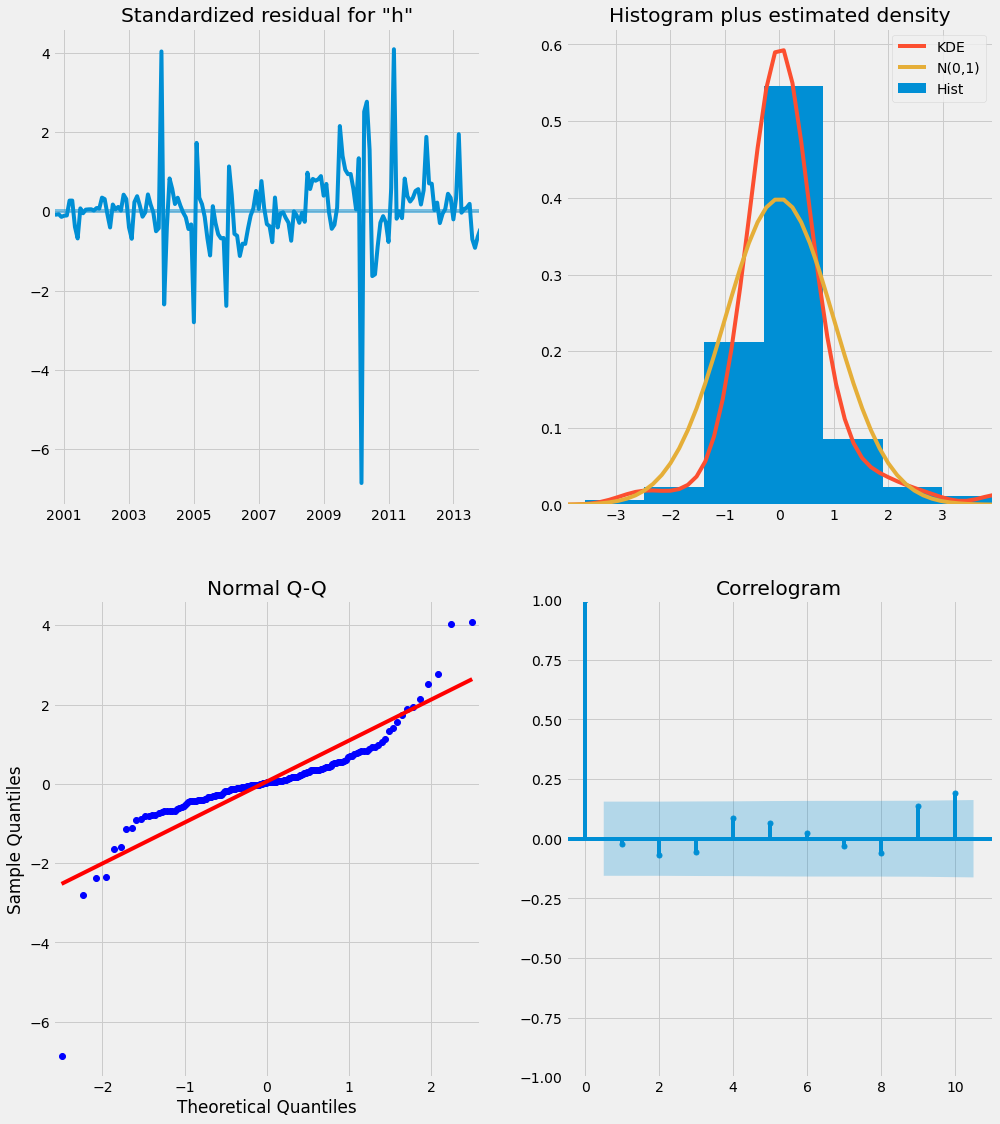

In [84]:
avg_home_model_2.plot_diagnostics(figsize=(15, 18))
plt.show()

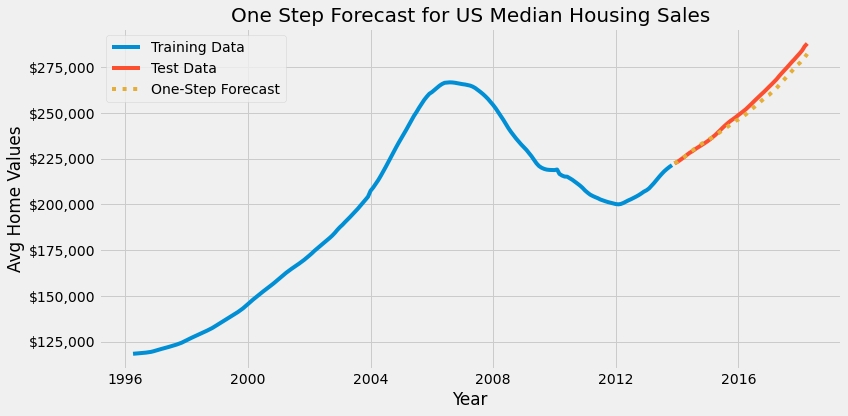

In [458]:
pred = avg_home_model_2.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=True)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')

ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("One Step Forecast for US Median Housing Sales", fontsize = 20)

ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [86]:
y_forecasted = pred.predicted_mean
y_truth = test['home_value']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 10304769.94
The Root Mean Squared Error is 3210.1


#### Prediction

In [87]:
#combo = avg_home_df_combo_1
combo = avg_home_df_combo_2

In [88]:
# Running model again with FULL data

sarima_model = SARIMAX(
    avg_home_df,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         home_value   No. Observations:                  265
Model:             SARIMAX(1, 2, 2)x(2, 2, 2, 12)   Log Likelihood               -1548.062
Date:                            Sat, 21 May 2022   AIC                           3112.124
Time:                                    12:29:02   BIC                           3138.977
Sample:                                04-01-1996   HQIC                          3122.977
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3522      0.099     -3.564      0.000      -0.546      -0.158
ma.L1          0.0909      0.101      0.896      0.370      -0.108       0.290
ma.L2         -0.0412      0.054     -0.767      0.443      -0.146       0.064
ar.S.L12       0.2163      0.046      4.698      0.000       0.126       0.306
ar.S.L24      -0.0567      0.028     -2.049      0.040      -0.111      -0.002
ma.S.L12      -1.8639      0.142    -13.113      0.000      -2.142      -1.585
ma.S.L24       0.8923      0.124      7.169      0.000       0.648       1.136
sigma2      1.021e+05    1.5e+04      6.805      0.000    7.27e+04    1.31e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):              2384.79
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               0.41   Skew:                            -1.11
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.28
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [89]:
avg_home_model_full = sarima_model

In [90]:
avg_home_df['2018-04']

home_value
time                  
2018-04-01  288,039.94

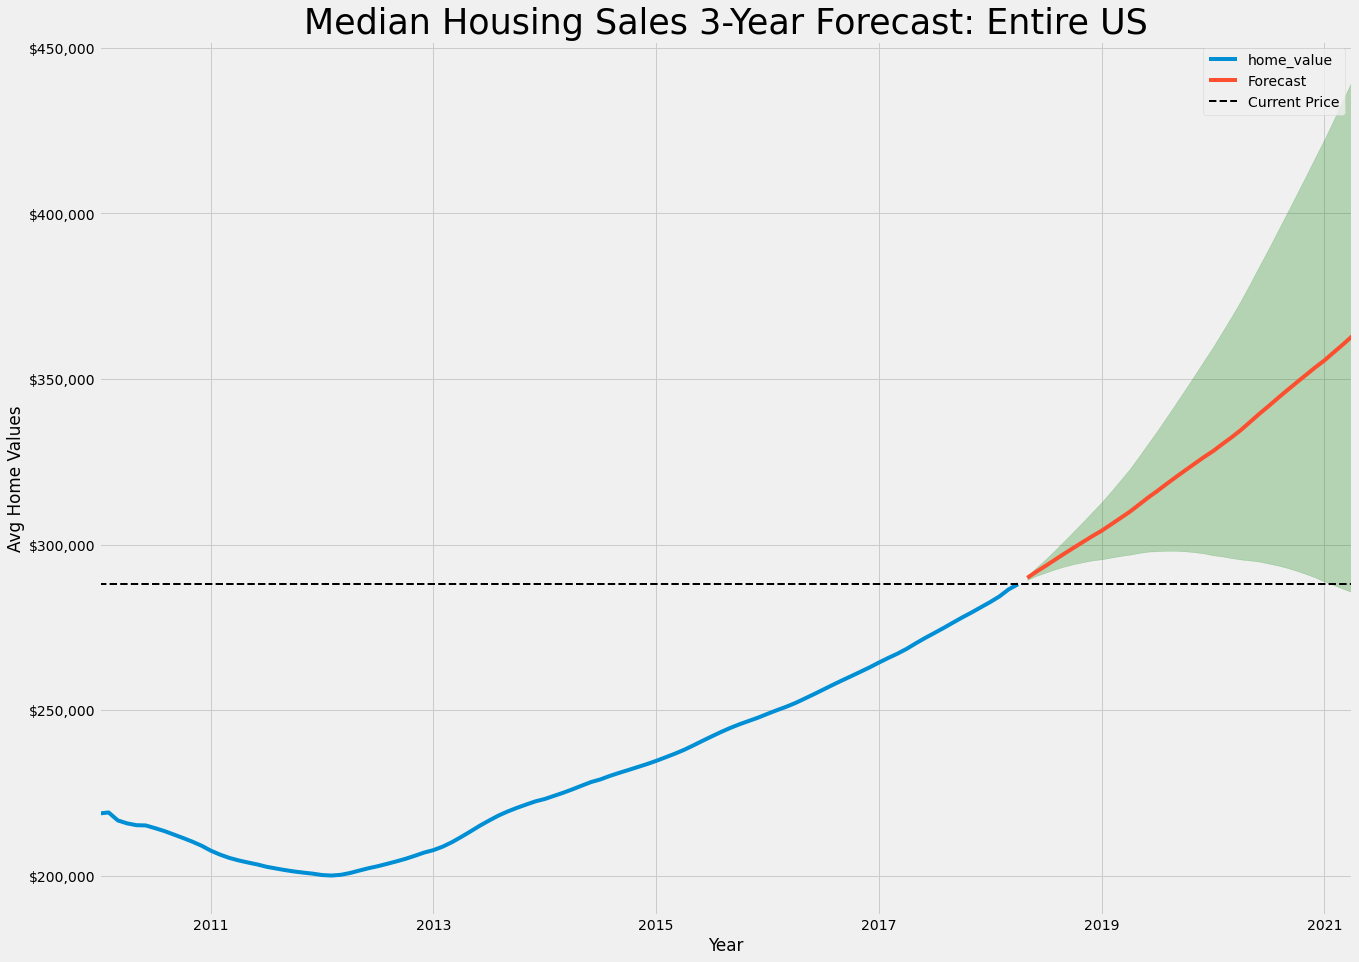

In [459]:
# Get forecast 5 yrs ahead in future (36 steps)
prediction = avg_home_model_full.get_forecast(steps=36)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals
ax = avg_home_df['2010-01':].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='green', alpha=0.25)

ax.axhline(288000, ls='--', color='black', linewidth=(2), label='Current Price')

ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("Median Housing Sales 3-Year Forecast: Entire US", fontsize = 35)
ax.yaxis.set_major_formatter(tick) 

plt.legend()
plt.show()

#### Analysis
- The forecast is for avg home prices in the US to continue on trending up. The confidence interval range shows a high degree of confidence in this for the next 2 years, with the area widening for year 3. That said, even the lower confidence interval shows home values staying at the level that they currently are today.

#### Metrics

In [413]:
avg_home_df.tail(1)

home_value
time                  
2018-04-01  288,039.94

In [414]:
analysis_df = pred_conf.resample('Y').mean()
analysis_df['mean'] = analysis_df.apply(lambda x: x.mean(), axis=1)

analysis_df['base'] = 288039
analysis_df['base'] = analysis_df['base'].astype(float)

In [415]:
analysis_df = analysis_df[['base', 'lower value', 'mean', 'upper value']]

analysis_df['Min_ROI'] = analysis_df.apply(lambda x: x['lower value'] - x['base'], axis=1)
analysis_df['Min_ROI%'] = analysis_df.apply(lambda x: x['Min_ROI'] / x['base'], axis=1)
analysis_df['Forecast_ROI'] = analysis_df.apply(lambda x: x['mean'] - x['base'], axis=1)
analysis_df['Forecast_ROI%'] = analysis_df.apply(lambda x: x['mean'] / x['base'], axis=1)
analysis_df['Max_ROI'] = analysis_df.apply(lambda x: x['upper value'] - x['base'], axis=1)
analysis_df['Max_ROI%'] = analysis_df.apply(lambda x: x['upper value'] / x['base'], axis=1)

In [417]:
avg_home_df_metrics = analysis_df

## <b><u> 29403: Charleston SC</b></u>

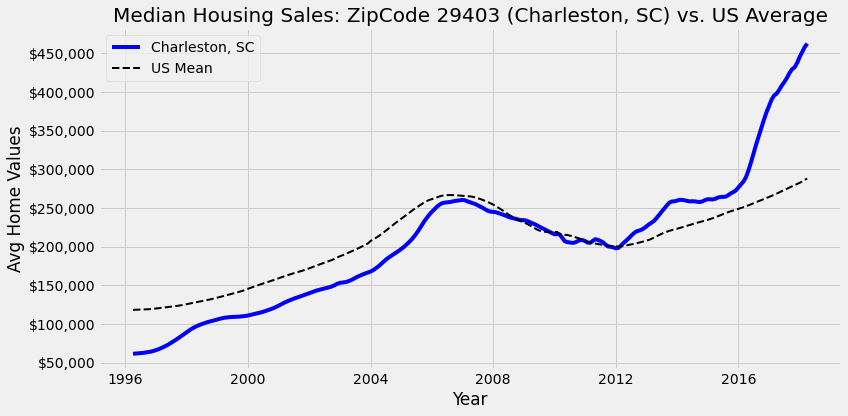

In [434]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(zip_29403_ts, label='Charleston, SC', color='blue')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', ls='--',
                     color='black', linewidth=(2), label='US Mean');

ax.legend()
ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("Median Housing Sales: ZipCode 29403 (Charleston, SC) vs. US Average", fontsize = 20)
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

### Model #1

In [93]:
#sarimax_param_search(zip_29403_ts)

In [94]:
# Charlesston SC
# Normal Param Search Results
# AIC: 3900.908
zip_29403_combo_1 = ((1, 1, 1), (1, 1, 1, 12))
# DO NOT DELETE! Results from doing a more advanced parameter search
#zip_29403_combo_2
zip_29403_combo_2 = (((2, 2, 2), (0, 2, 2, 12)))

In [95]:
combo = zip_29403_combo_1
combo

((1, 1, 1), (1, 1, 1, 12))

In [96]:
# Manually split data.
temp_ts = zip_29403_ts

SPLIT = int(temp_ts.shape[0]*0.80)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  212
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1473.332
Date:                            Sat, 21 May 2022   AIC                           2956.665
Time:                                    12:29:03   BIC                           2972.766
Sample:                                04-01-1996   HQIC                          2963.190
                                     - 11-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8600      0.040     21.403      0.000       0.781       0.939
ma.L1          0.6460      0.029     21.943      0.000       0.588       0.704
ar.S.L12       0.0872      0.043      2.013      0.044       0.002       0.172
ma.S.L12      -0.9253      0.058    -16.025      0.000      -1.038      -0.812
sigma2      3.573e+05   2.42e+04     14.770      0.000     3.1e+05    4.05e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               176.17
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               7.53   Skew:                            -0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [97]:
zip_29403_model_1 = sarima_model

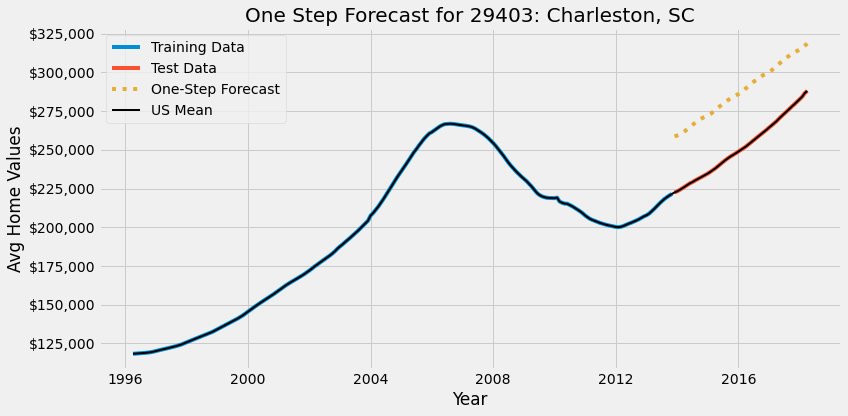

In [460]:
pred = zip_29403_model_1.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=False)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value',
                     color='black', linewidth=(2), label='US Mean');
ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("One Step Forecast for 29403: Charleston, SC", fontsize = 20)

ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [99]:
y_forecasted = pred.predicted_mean
y_truth = test['value']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 4294194403.4
The Root Mean Squared Error is 65530.1


### Model #2

In [100]:
combo = zip_29403_combo_2
combo

((2, 2, 2), (0, 2, 2, 12))

In [101]:
# Manually split data.
temp_ts = zip_29403_ts

SPLIT = int(temp_ts.shape[0]*0.80)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  212
Model:             SARIMAX(2, 2, 2)x(0, 2, 2, 12)   Log Likelihood               -1306.948
Date:                            Sat, 21 May 2022   AIC                           2627.896
Time:                                    12:29:09   BIC                           2649.378
Sample:                                04-01-1996   HQIC                          2636.619
                                     - 11-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6437      0.055    -11.677      0.000      -0.752      -0.536
ar.L2         -0.3261      0.034     -9.693      0.000      -0.392      -0.260
ma.L1          1.3790      0.041     33.312      0.000       1.298       1.460
ma.L2          0.7858      0.040     19.733      0.000       0.708       0.864
ma.S.L12      -1.5538      0.045    -34.795      0.000      -1.641      -1.466
ma.S.L24       0.6953      0.045     15.568      0.000       0.608       0.783
sigma2       5.26e+05   3.94e+04     13.360      0.000    4.49e+05    6.03e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.28   Jarque-Bera (JB):                24.41
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               3.77   Skew:                            -0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [102]:
zip_29403_model_2 = sarima_model

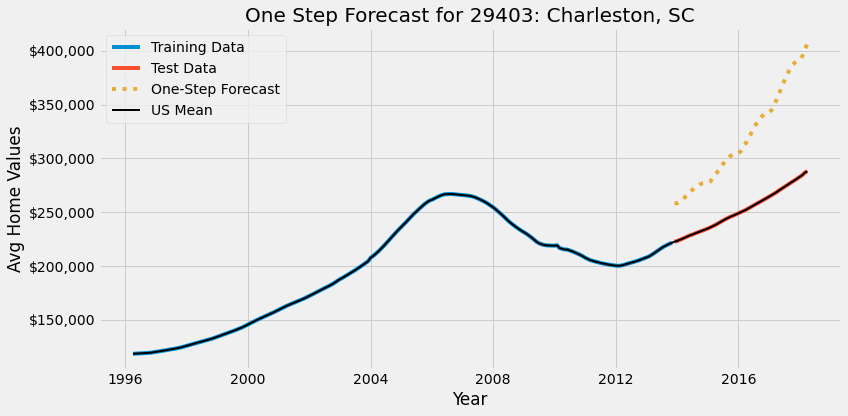

In [461]:
pred = zip_29403_model_2.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=False)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value',
                     color='black', linewidth=(2), label='US Mean');

ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("One Step Forecast for 29403: Charleston, SC", fontsize = 20)
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [104]:
y_forecasted = pred.predicted_mean
y_truth = test['value']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 964280497.2
The Root Mean Squared Error is 31052.87


### Model Decision:
- Model 2's forecast is a better match for the test data. I will use this to make my predictions.

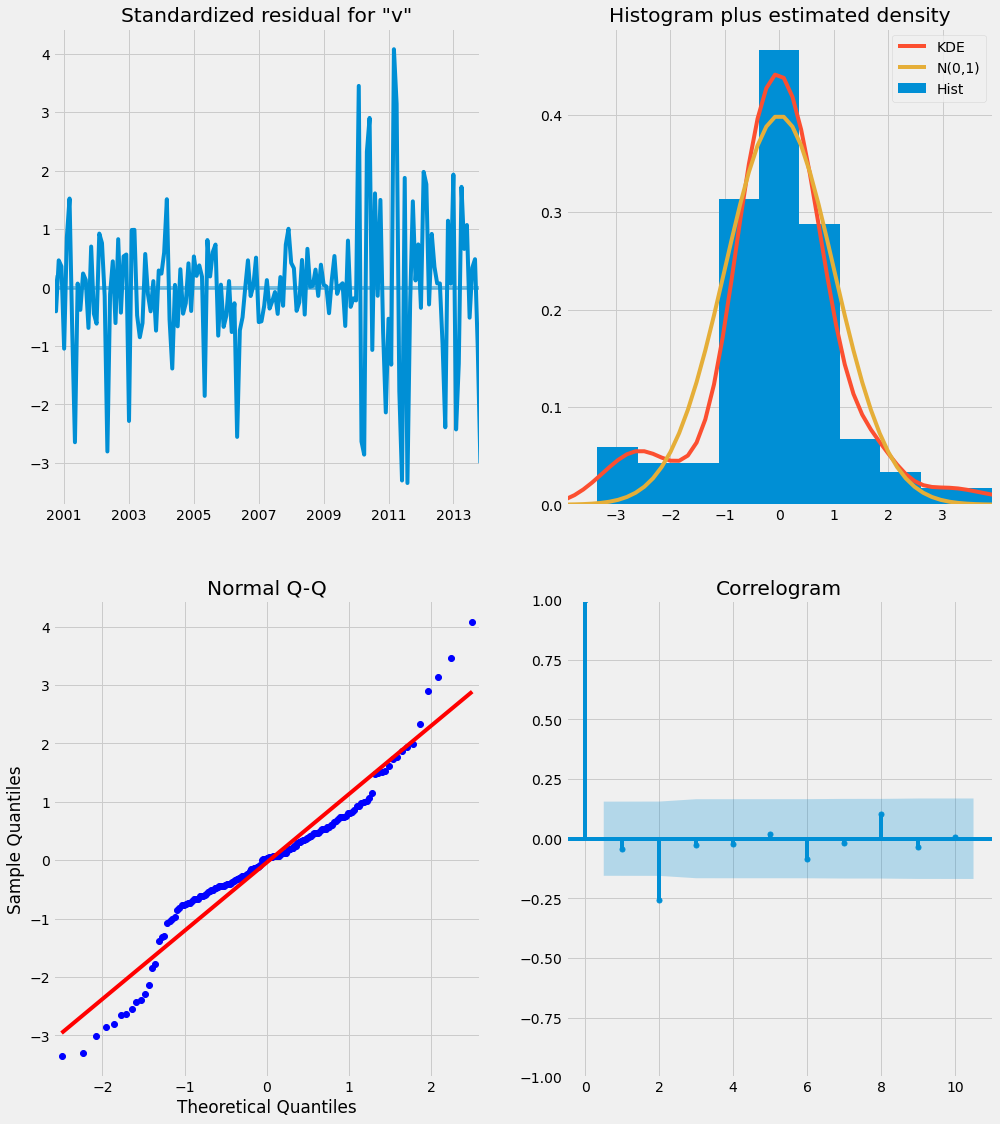

In [105]:
zip_29403_model_2.plot_diagnostics(figsize=(15, 18))
plt.show()

### Predictions

In [106]:
combo = zip_29403_combo_2
combo

((2, 2, 2), (0, 2, 2, 12))

In [107]:
# Running model again with FULL data

sarima_model = SARIMAX(
    zip_29403_ts,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(2, 2, 2)x(0, 2, 2, 12)   Log Likelihood               -1760.868
Date:                            Sat, 21 May 2022   AIC                           3535.736
Time:                                    12:29:16   BIC                           3559.232
Sample:                                04-01-1996   HQIC                          3545.233
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8197      0.069    -11.797      0.000      -0.956      -0.683
ar.L2         -0.3762      0.038     -9.926      0.000      -0.450      -0.302
ma.L1          1.6234      0.051     32.059      0.000       1.524       1.723
ma.L2          0.8922      0.049     18.077      0.000       0.795       0.989
ma.S.L12      -1.6219      0.141    -11.528      0.000      -1.898      -1.346
ma.S.L24       0.6394      0.091      7.011      0.000       0.461       0.818
sigma2      7.392e+05   9.68e+04      7.634      0.000    5.49e+05    9.29e+05
===================================================================================
Ljung-Box (L1) (Q):                   2.60   Jarque-Bera (JB):                62.24
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               2.62   Skew:                             0.03
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [108]:
zip_29403_model_full = sarima_model

In [109]:
zip_29403_ts.tail()

value
time                 
2017-12-01 437,500.00
2018-01-01 445,400.00
2018-02-01 451,900.00
2018-03-01 458,000.00
2018-04-01 462,700.00

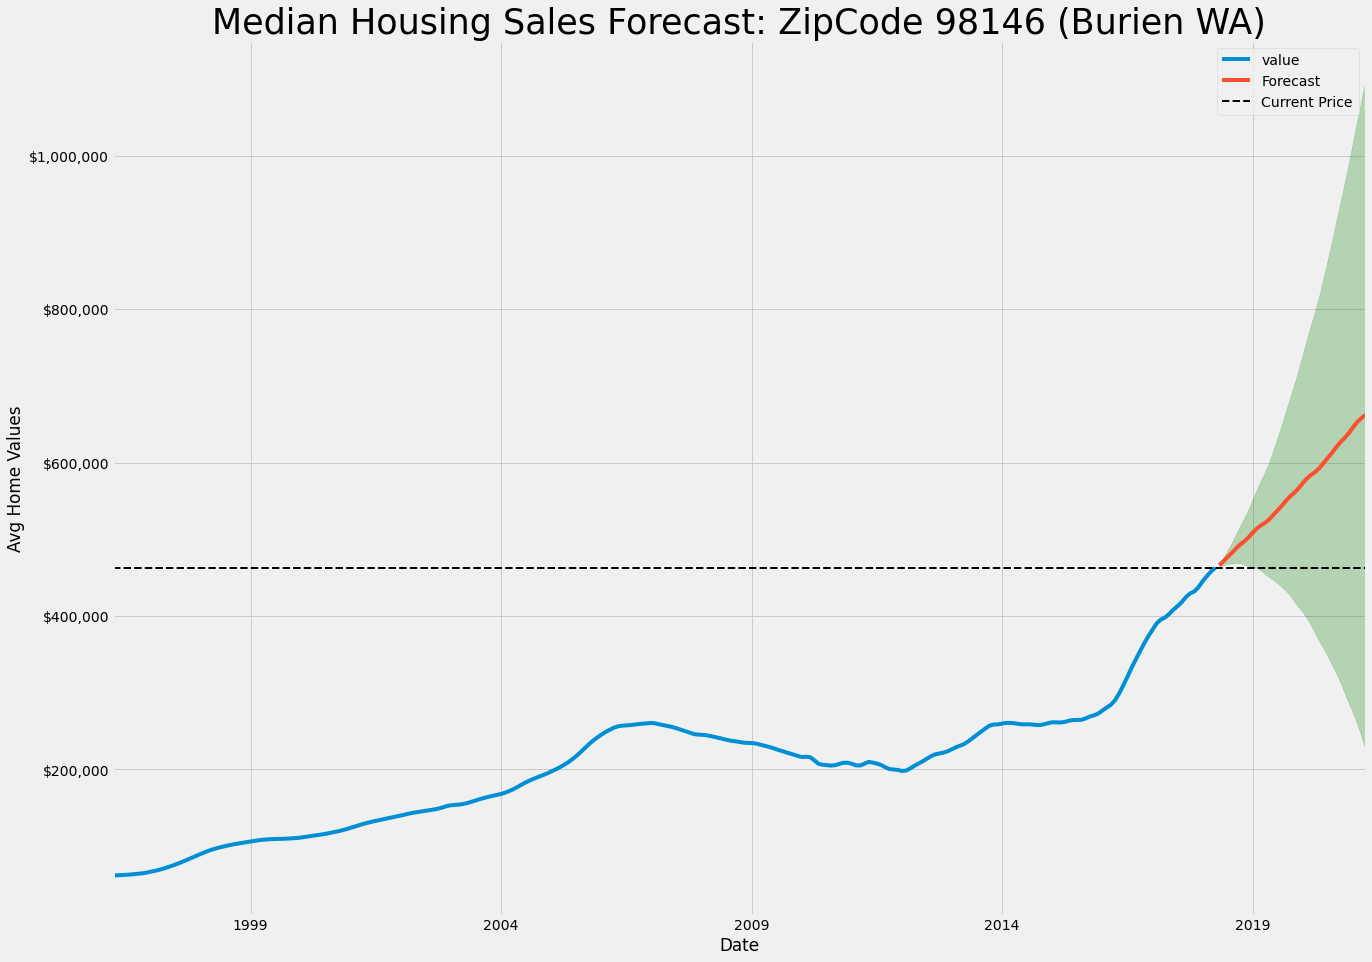

In [110]:
# Get forecast 3 yrs ahead in future (36 steps)
prediction = zip_29403_model_full.get_forecast(steps=36)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals
ax = zip_29403_ts['1996-01':].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='green', alpha=0.25)

ax.axhline(462700, ls='--', color='black', linewidth=(2), label='Current Price')

ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Values')
ax.set_title("Median Housing Sales Forecast: ZipCode 98146 (Burien WA)", fontsize = 35)
ax.yaxis.set_major_formatter(tick) 

plt.legend()
plt.show()

### Final Analysis: 
- While 1-2 Years out looks good, there is too much uncertainty in Forecast Year 3 to recommend Charleston as one of the Top 5 Zip Codes.
- That said, if you reduced the investment window to 1-2 years, Charleston is a good choice and therefore should be considered with that caveat.

## <b><u>98146: Burien WA (#1) </b></u>

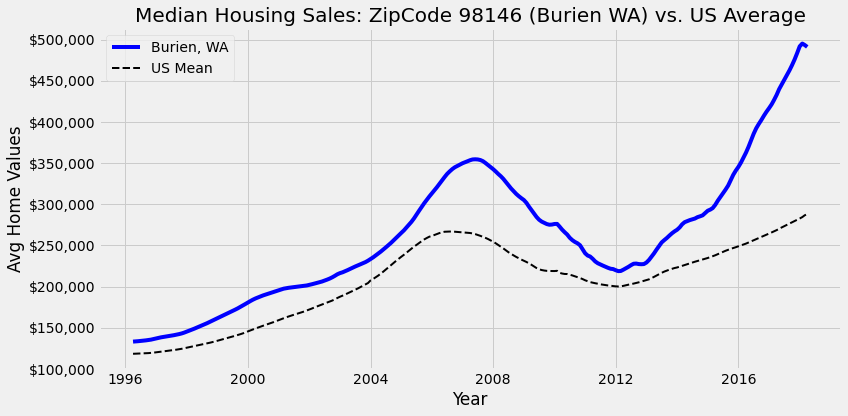

In [435]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(zip_98146_ts, label='Burien, WA', color='blue')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', ls='--',
                     color='black', linewidth=(2), label='US Mean');

ax.legend()
ax.set_title("Median Housing Sales: ZipCode 98146 (Burien WA) vs. US Average", fontsize = 20)
ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [112]:
#zip_98146_combo_1 = ((1, 1, 1), (1, 1, 1, 12)) AIC: 3862
zip_98146_combo_1 = ((1, 1, 1), (1, 1, 1, 12))

In [113]:
# SARIMA Combos: ((2, 2, 2), (2, 2, 2, 12)) AIC: 3528.4653033814084
zip_98146_combo_2 = ((2, 2, 2), (2, 2, 2, 12)) 
zip_98146_combo_2

((2, 2, 2), (2, 2, 2, 12))

### Model #1

In [114]:
combo = zip_98146_combo_1
combo

((1, 1, 1), (1, 1, 1, 12))

In [115]:
# Manually split data.
temp_ts = zip_98146_ts

SPLIT = int(temp_ts.shape[0]*0.80)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  212
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1446.596
Date:                            Sat, 21 May 2022   AIC                           2903.193
Time:                                    12:29:17   BIC                           2919.294
Sample:                                04-01-1996   HQIC                          2909.718
                                     - 11-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9574      0.021     45.343      0.000       0.916       0.999
ma.L1          0.3574      0.049      7.227      0.000       0.260       0.454
ar.S.L12       0.1369      0.023      6.077      0.000       0.093       0.181
ma.S.L12      -0.9242      0.060    -15.362      0.000      -1.042      -0.806
sigma2      2.661e+05    1.2e+04     22.231      0.000    2.43e+05     2.9e+05
===================================================================================
Ljung-Box (L1) (Q):                   4.05   Jarque-Bera (JB):               446.91
Prob(Q):                              0.04   Prob(JB):                         0.00
Heteroskedasticity (H):               9.63   Skew:                            -0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.37
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [116]:
zip_98146_model_1 = sarima_model

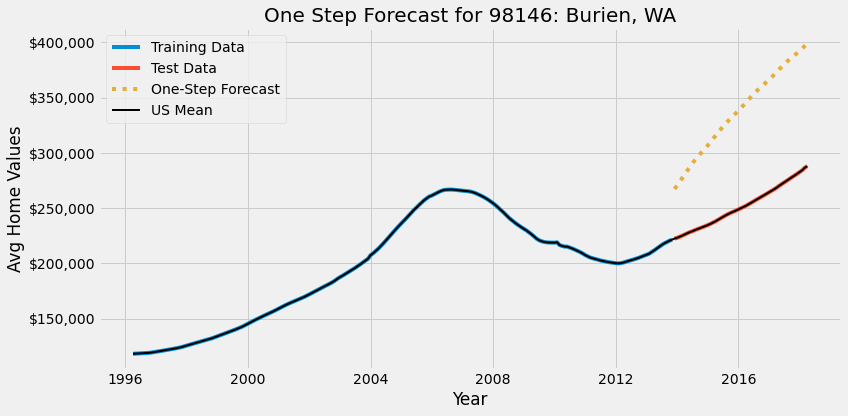

In [462]:
pred = zip_98146_model_1.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=False)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value',
                     color='black', linewidth=(2), label='US Mean');

ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("One Step Forecast for 98146: Burien, WA", fontsize = 20)
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [118]:
y_forecasted = pred.predicted_mean
y_truth = test['value']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 2132788317.74
The Root Mean Squared Error is 46182.12


### Model #2

In [119]:
combo = zip_98146_combo_2
combo

((2, 2, 2), (2, 2, 2, 12))

In [120]:
# Manually split data.
temp_ts = zip_98146_ts

SPLIT = int(temp_ts.shape[0]*0.80)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  212
Model:             SARIMAX(2, 2, 2)x(2, 2, 2, 12)   Log Likelihood               -1294.159
Date:                            Sat, 21 May 2022   AIC                           2606.318
Time:                                    12:29:25   BIC                           2633.938
Sample:                                04-01-1996   HQIC                          2617.534
                                     - 11-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0489      0.122      8.631      0.000       0.811       1.287
ar.L2         -0.0772      0.113     -0.684      0.494      -0.298       0.144
ma.L1         -0.5791      0.493     -1.175      0.240      -1.545       0.387
ma.L2         -0.4186      0.251     -1.670      0.095      -0.910       0.073
ar.S.L12      -1.2102      0.077    -15.762      0.000      -1.361      -1.060
ar.S.L24      -0.8774      0.119     -7.349      0.000      -1.111      -0.643
ma.S.L12      -0.0233      0.067     -0.348      0.728      -0.154       0.108
ma.S.L24      -0.0289      0.046     -0.623      0.534      -0.120       0.062
sigma2      6.838e+05   3.21e+05      2.130      0.033    5.45e+04    1.31e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                76.40
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):              28.50   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [121]:
zip_98146_model_2 = sarima_model

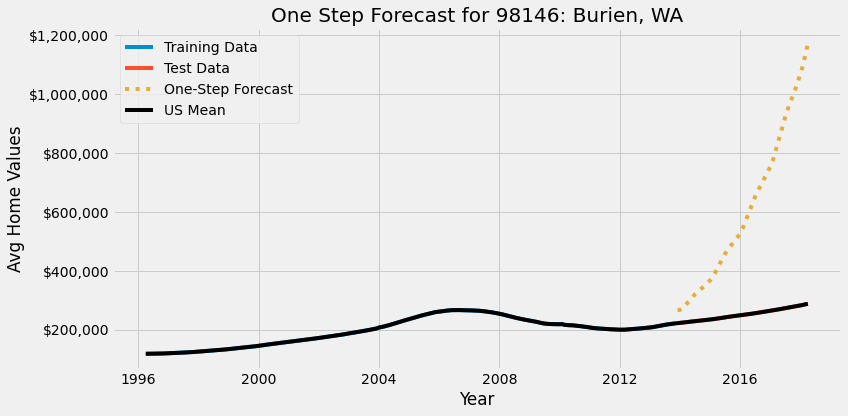

In [463]:
pred = zip_98146_model_2.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=True)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='black', label='US Mean');

ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("One Step Forecast for 98146: Burien, WA", fontsize = 20)
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [123]:
y_forecasted = pred.predicted_mean
y_truth = test['value']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 97460870085.47
The Root Mean Squared Error is 312187.24


### Model Decision: 
- Model 1 has a significantly lower RSME, and is a much better match for the test data. I will proceed using Model 1.

### Prediction

In [124]:
combo = zip_98146_combo_1
#combo = zip_98146_combo_2
combo

((1, 1, 1), (1, 1, 1, 12))

In [125]:
# Running model again with FULL data

sarima_model = SARIMAX(
    zip_98146_ts,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1926.358
Date:                            Sat, 21 May 2022   AIC                           3862.715
Time:                                    12:29:26   BIC                           3880.077
Sample:                                04-01-1996   HQIC                          3869.712
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9071      0.032     28.389      0.000       0.844       0.970
ma.L1          0.5799      0.034     16.888      0.000       0.513       0.647
ar.S.L12       0.1196      0.060      1.980      0.048       0.001       0.238
ma.S.L12      -0.6561      0.065    -10.137      0.000      -0.783      -0.529
sigma2      5.325e+05   2.47e+04     21.542      0.000    4.84e+05    5.81e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.59   Jarque-Bera (JB):              1013.40
Prob(Q):                              0.21   Prob(JB):                         0.00
Heteroskedasticity (H):               7.37   Skew:                            -1.58
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [126]:
zip_98146_model_full = sarima_model

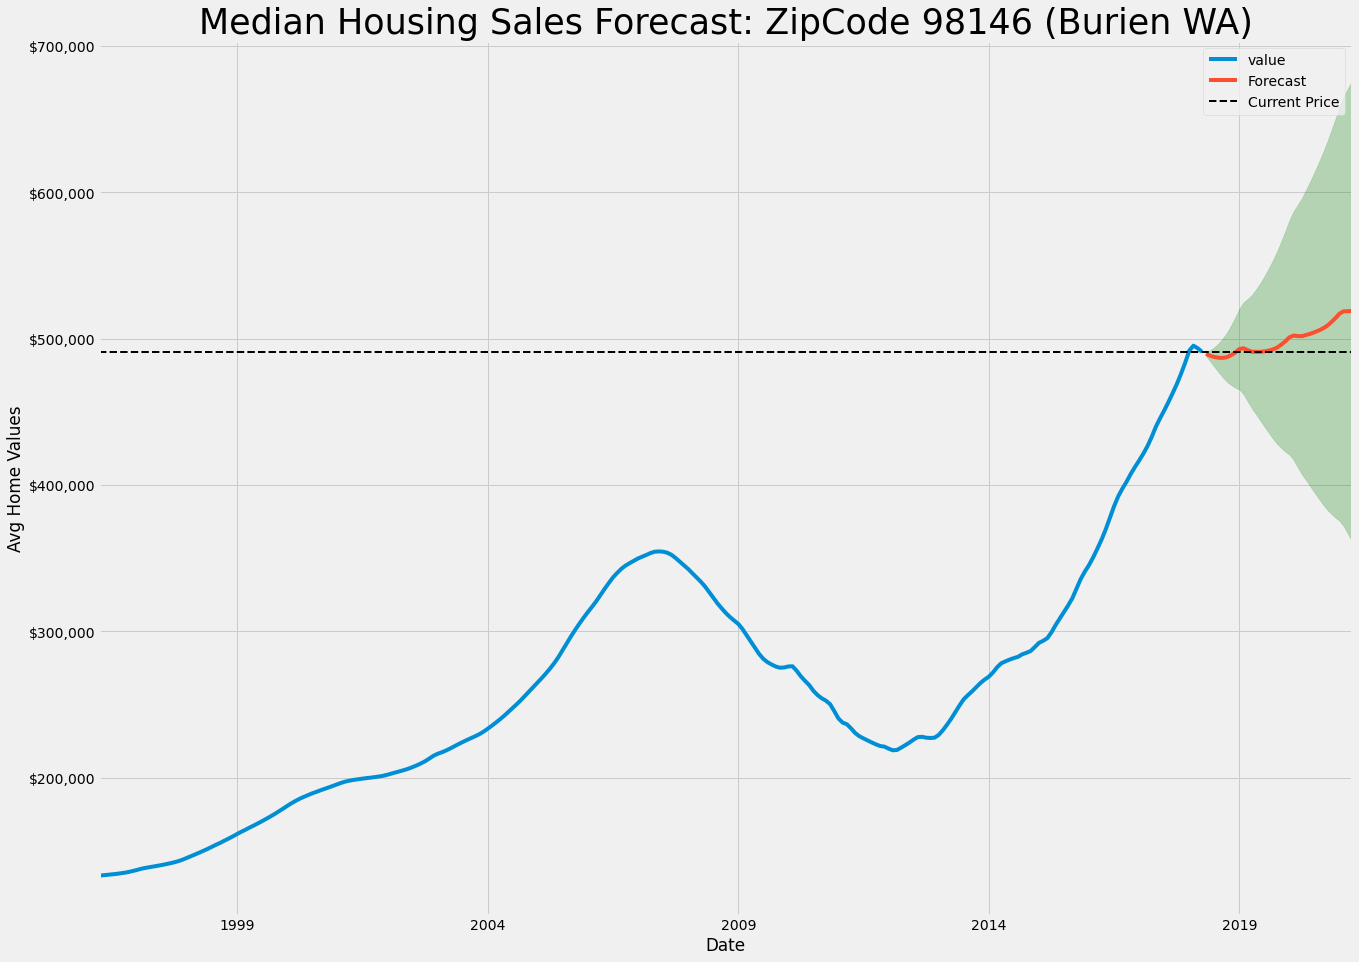

In [127]:
# Get forecast 3 yrs ahead in future (36 steps)
prediction = zip_98146_model_full.get_forecast(steps=36)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals
ax = zip_98146_ts['1996-01':].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='green', alpha=0.25)

ax.axhline(491000, ls='--', color='black', linewidth=(2), label='Current Price')

ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Values')
ax.set_title("Median Housing Sales Forecast: ZipCode 98146 (Burien WA)", fontsize = 35)
ax.yaxis.set_major_formatter(tick) 

plt.legend()
plt.show()

### Analysis: 
- There is too much uncertainty in the confidence window. The forecast mean stays around the current value and the upper and lower confidence windows are nearly equally sized, so investing in this zip code would be more of a 50/50 chance than a low-risk investment. Therefore I do not recommend pursing this zip code.


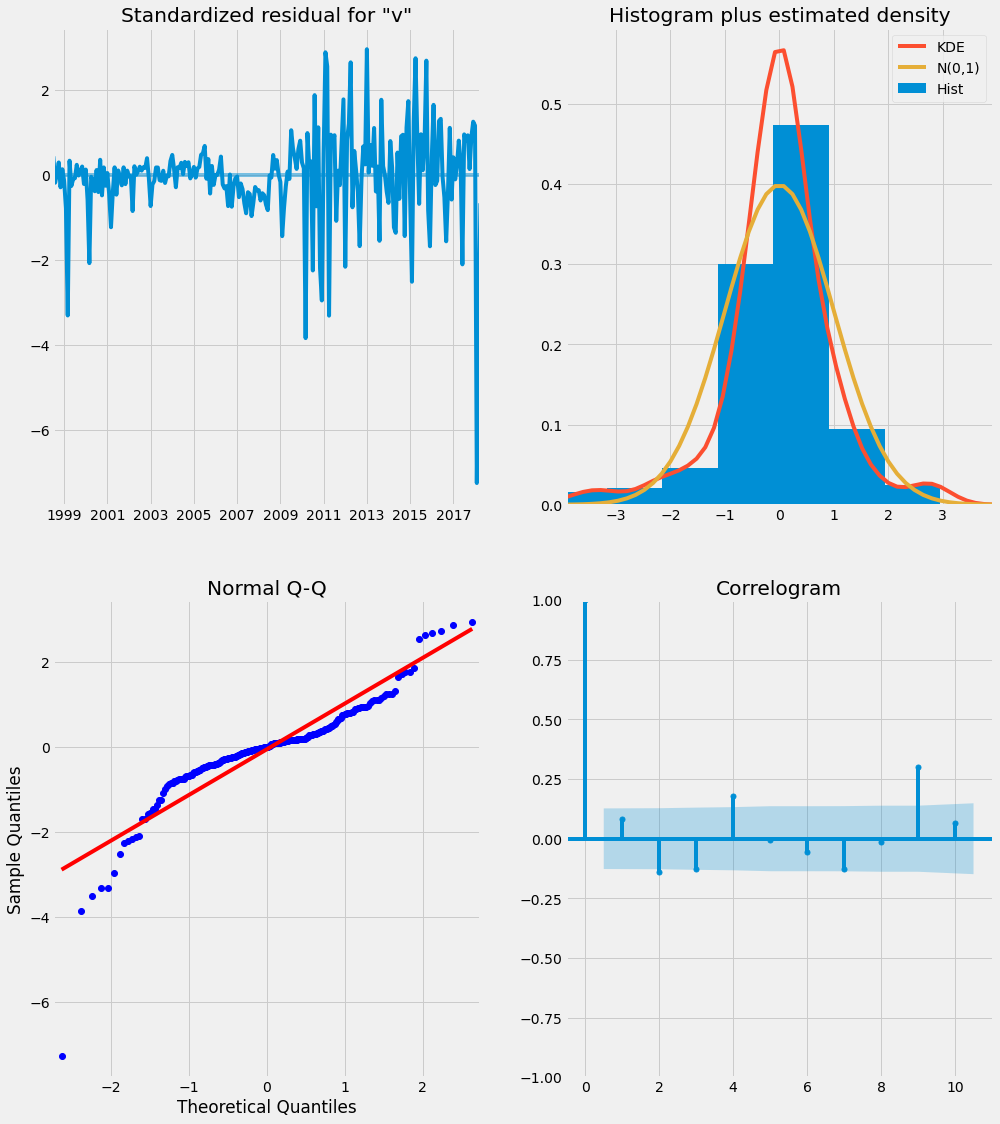

In [128]:
zip_98146_model_full.plot_diagnostics(figsize=(15, 18))
plt.show()

In [129]:
#print('Forecast Values')
#print(prediction.predicted_mean.resample('Y').mean())
#print('----------------------------------')
#print('Confidence Index')
#print(pred_conf.resample('Y').mean())

## <b><u>95570: Trinidad CA</b></u>

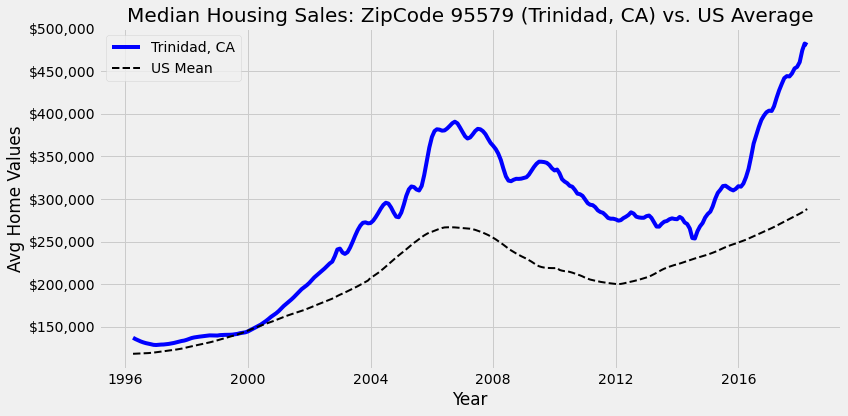

In [436]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(zip_95570_ts, label='Trinidad, CA', color='blue')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', ls='--',
                     color='black', linewidth=(2), label='US Mean');

ax.legend()
ax.set_title("Median Housing Sales: ZipCode 95579 (Trinidad, CA) vs. US Average", fontsize = 20)
ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [131]:
#sarimax_param_search(zip_95570_ts)

In [132]:
#SARIMA Combos: ((1, 1, 1), (1, 1, 1, 12)) AIC: 4470.940175311183
zip_95570_combo_1 = ((1, 1, 1), (1, 1, 1, 12))
zip_95570_combo_1

((1, 1, 1), (1, 1, 1, 12))

In [133]:
#SARIMA Combos: ((2, 2, 2), (2, 2, 2, 12)) AIC: 4087.066104443231
zip_95570_combo_2 = ((2, 2, 2), (2, 2, 2, 12))
zip_95570_combo_2


((2, 2, 2), (2, 2, 2, 12))

### Model #1

In [134]:
combo = zip_95570_combo_1
combo

((1, 1, 1), (1, 1, 1, 12))

In [135]:
# Manually split data.
temp_ts = zip_95570_ts

SPLIT = int(temp_ts.shape[0]*0.80)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  212
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1690.132
Date:                            Sat, 21 May 2022   AIC                           3390.264
Time:                                    12:29:27   BIC                           3406.365
Sample:                                04-01-1996   HQIC                          3396.789
                                     - 11-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7030      0.070     10.100      0.000       0.567       0.839
ma.L1          0.8011      0.075     10.722      0.000       0.655       0.948
ar.S.L12       0.2347      0.059      3.967      0.000       0.119       0.351
ma.S.L12      -0.4682      0.057     -8.162      0.000      -0.581      -0.356
sigma2      6.665e+06   7.98e+05      8.356      0.000     5.1e+06    8.23e+06
===================================================================================
Ljung-Box (L1) (Q):                   5.42   Jarque-Bera (JB):                16.58
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               1.94   Skew:                            -0.13
Prob(H) (two-sided):                  0.01   Kurtosis:                         4.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [136]:
zip_95570_model_1 = sarima_model

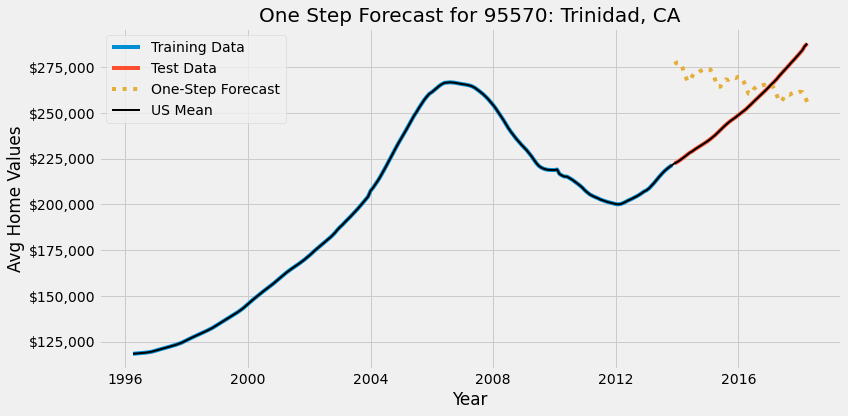

In [464]:
pred = zip_95570_model_1.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=False)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value',
                     color='black', linewidth=(2), label='US Mean');

ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("One Step Forecast for 95570: Trinidad, CA", fontsize = 20)
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

###  Analysis: 
- The forecast doesn't match the test data at all, but looking at the training data's plot, it's easy to see why.
- I am going to increase the training group's size and see if that better matches the test data without overfitting on it.

### Model 1.5 (different train/test split ratio)

In [138]:
combo = zip_95570_combo_1
combo

((1, 1, 1), (1, 1, 1, 12))

In [139]:
# Manually split data.
temp_ts = zip_95570_ts

SPLIT = int(temp_ts.shape[0]*0.90)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  238
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1962.616
Date:                            Sat, 21 May 2022   AIC                           3935.232
Time:                                    12:29:27   BIC                           3951.991
Sample:                                04-01-1996   HQIC                          3942.006
                                     - 01-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6120      0.060     10.231      0.000       0.495       0.729
ma.L1          0.8132      0.070     11.649      0.000       0.676       0.950
ar.S.L12       0.2694      0.051      5.242      0.000       0.169       0.370
ma.S.L12      -0.5017      0.059     -8.563      0.000      -0.616      -0.387
sigma2      9.258e+06   2.57e-09    3.6e+15      0.000    9.26e+06    9.26e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.62   Jarque-Bera (JB):                57.66
Prob(Q):                              0.20   Prob(JB):                         0.00
Heteroskedasticity (H):               2.61   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.04e+30. Standard errors may be unstable.
"""

In [140]:
zip_95570_model_1_5 = sarima_model

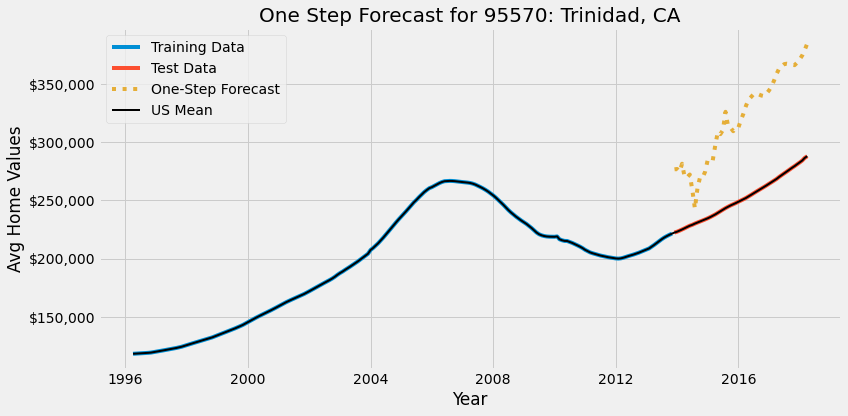

In [465]:
pred = zip_95570_model_1_5.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=False)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value',
                     color='black', linewidth=(2), label='US Mean');

ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("One Step Forecast for 95570: Trinidad, CA", fontsize = 20)
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

### Analysis: 
- Increasing the size of the training group definitely helped. I will use the same train_test_split ratio of 90/10 for Model #2.

In [142]:
y_forecasted = pred.predicted_mean
y_truth = test['value']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 4152768083.15
The Root Mean Squared Error is 64441.97


### Model 2

In [143]:
combo = zip_95570_combo_2
combo

((2, 2, 2), (2, 2, 2, 12))

In [144]:
# Manually split data.
temp_ts = zip_95570_ts

SPLIT = int(temp_ts.shape[0]*0.90)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  238
Model:             SARIMAX(2, 2, 2)x(2, 2, 2, 12)   Log Likelihood               -1779.848
Date:                            Sat, 21 May 2022   AIC                           3577.696
Time:                                    12:29:32   BIC                           3606.679
Sample:                                04-01-1996   HQIC                          3589.442
                                     - 01-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7947      0.283      2.813      0.005       0.241       1.348
ar.L2         -0.1759      0.292     -0.603      0.547      -0.748       0.396
ma.L1         -0.5038      0.282     -1.786      0.074      -1.056       0.049
ma.L2         -0.4581      0.260     -1.759      0.079      -0.969       0.052
ar.S.L12      -0.7903      0.229     -3.458      0.001      -1.238      -0.342
ar.S.L24      -0.4526      0.208     -2.180      0.029      -0.860      -0.046
ma.S.L12      -0.5134      0.212     -2.419      0.016      -0.929      -0.098
ma.S.L24      -0.2086      0.138     -1.509      0.131      -0.480       0.062
sigma2       2.48e+07   5.05e-09   4.91e+15      0.000    2.48e+07    2.48e+07
===================================================================================
Ljung-Box (L1) (Q):                   1.76   Jarque-Bera (JB):                13.36
Prob(Q):                              0.18   Prob(JB):                         0.00
Heteroskedasticity (H):               1.28   Skew:                             0.03
Prob(H) (two-sided):                  0.34   Kurtosis:                         4.31
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.41e+31. Standard errors may be unstable.
"""

In [145]:
zip_95570_model_2 = sarima_model

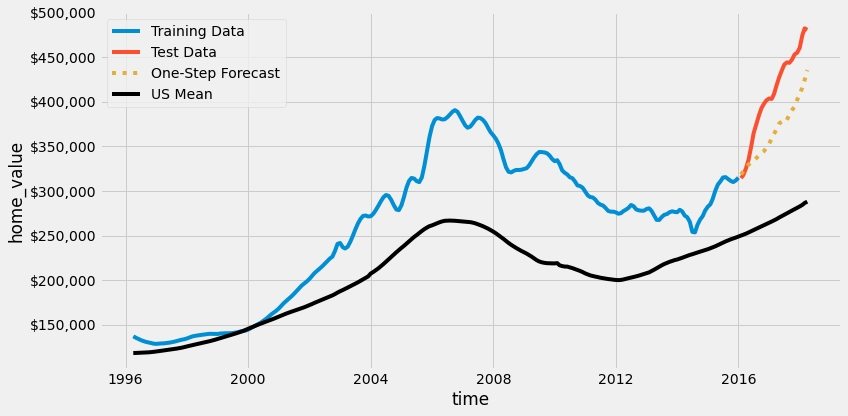

In [146]:
pred = zip_95570_model_2.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=False)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='black', label='US Mean');
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [147]:
y_forecasted = pred.predicted_mean
y_truth = test['value']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 2239631687.88
The Root Mean Squared Error is 47324.75


### Model Decision
- Model #2 has a lower RMSE and also better reflects the test data. I will use this model to make my predicitions.

In [149]:
y_forecasted = pred.predicted_mean
y_truth = test['value']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 2239631687.88
The Root Mean Squared Error is 47324.75


### Prediction

In [150]:
#combo = zip_95570_combo_1
combo = zip_95570_combo_2
combo

((2, 2, 2), (2, 2, 2, 12))

In [151]:
# Running model again with FULL data

sarima_model = SARIMAX(
    zip_95570_ts,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(2, 2, 2)x(2, 2, 2, 12)   Log Likelihood               -2034.533
Date:                            Sat, 21 May 2022   AIC                           4087.066
Time:                                    12:29:41   BIC                           4117.275
Sample:                                04-01-1996   HQIC                          4099.276
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9138      0.164      5.575      0.000       0.593       1.235
ar.L2         -0.3686      0.167     -2.208      0.027      -0.696      -0.041
ma.L1         -0.7812      0.169     -4.631      0.000      -1.112      -0.451
ma.L2         -0.0437      0.176     -0.249      0.804      -0.388       0.300
ar.S.L12      -0.8435      0.098     -8.575      0.000      -1.036      -0.651
ar.S.L24      -0.4823      0.079     -6.126      0.000      -0.637      -0.328
ma.S.L12      -0.5676      0.091     -6.213      0.000      -0.747      -0.389
ma.S.L24      -0.1973      0.057     -3.473      0.001      -0.309      -0.086
sigma2      1.383e+07   1.35e-08   1.03e+15      0.000    1.38e+07    1.38e+07
===================================================================================
Ljung-Box (L1) (Q):                   4.68   Jarque-Bera (JB):                15.62
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               2.15   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.15e+30. Standard errors may be unstable.
"""

In [152]:
zip_95570_model_full = sarima_model

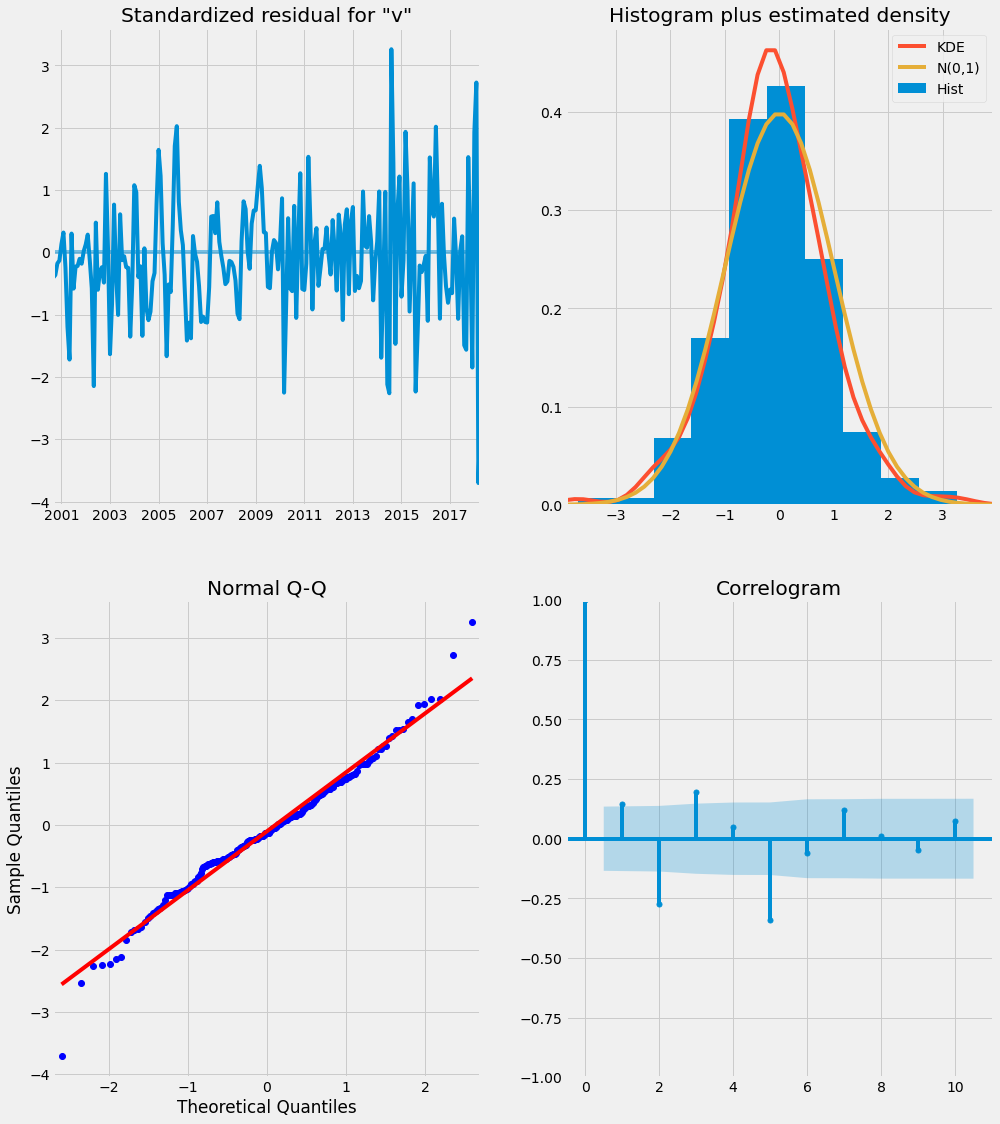

In [153]:
zip_95570_model_full.plot_diagnostics(figsize=(15,18))
plt.show()

In [154]:
zip_95570_ts.tail(1)

value
time                 
2018-04-01 480,600.00

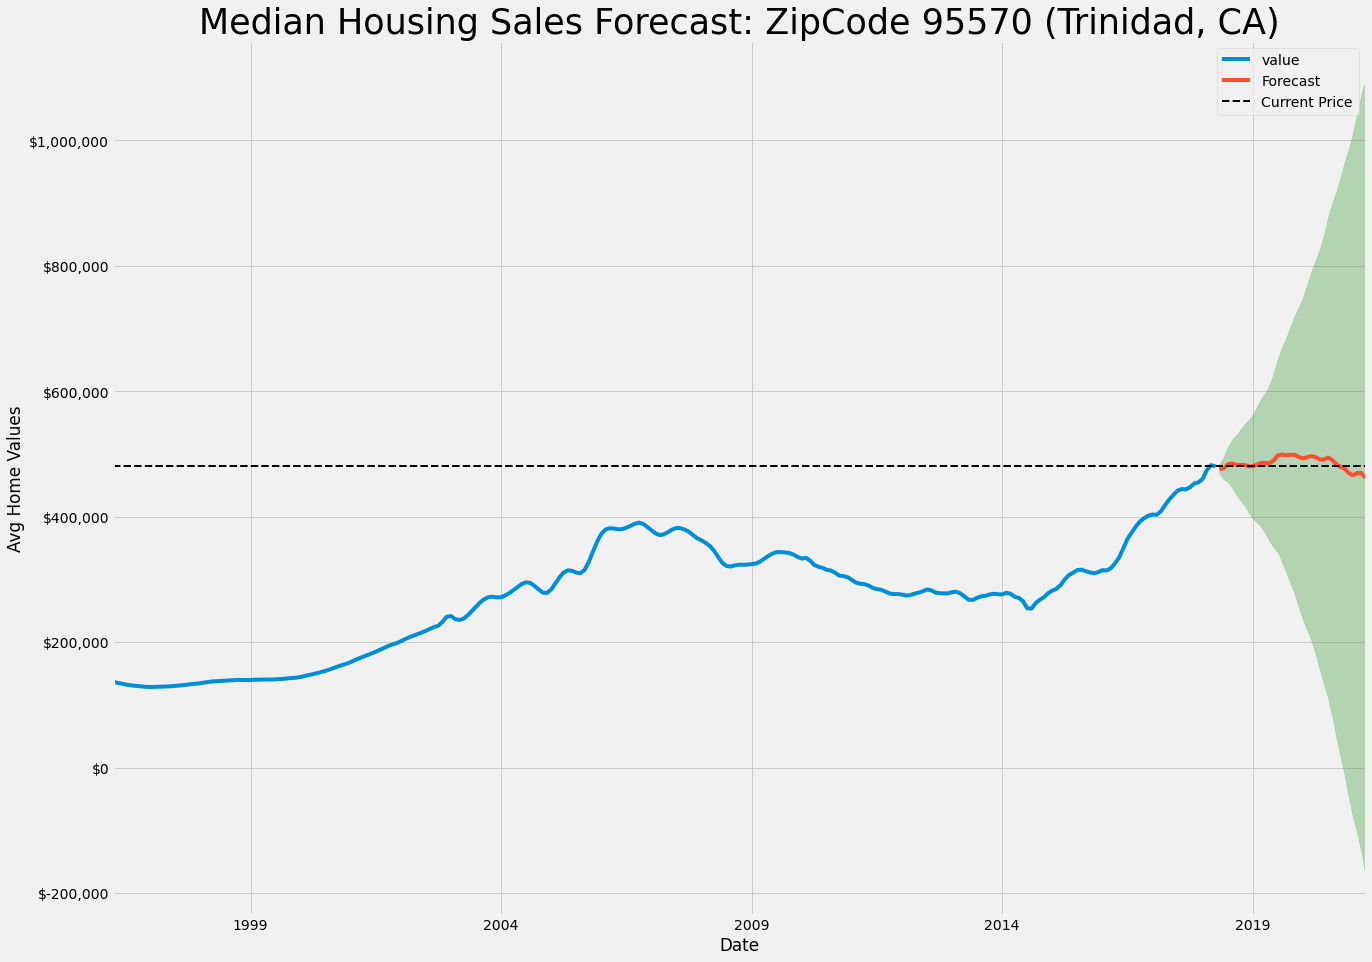

In [155]:
# Get forecast 3 yrs ahead in future (36 steps)
prediction = zip_95570_model_full.get_forecast(steps=36)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals
ax = zip_95570_ts['1996-01':].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='green', alpha=0.25)

ax.axhline(480600, ls='--', color='black', linewidth=(2), label='Current Price')

ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Values')
ax.set_title("Median Housing Sales Forecast: ZipCode 95570 (Trinidad, CA)", fontsize = 35)
ax.yaxis.set_major_formatter(tick) 

plt.legend()
plt.show()

### Analysis: 
- Forecast mean stays at the current price. Confidence window is too large. Nearly equal chance for gain and loss. I do not recommend investing in this zipcode.

In [156]:
#print('Forecast Values')
#print(prediction.predicted_mean.resample('Y').mean())
#print('----------------------------------')
#print('Confidence Index')
#print(pred_conf.resample('Y').mean())

## <b><u>37046: College Grove TN</b></u>

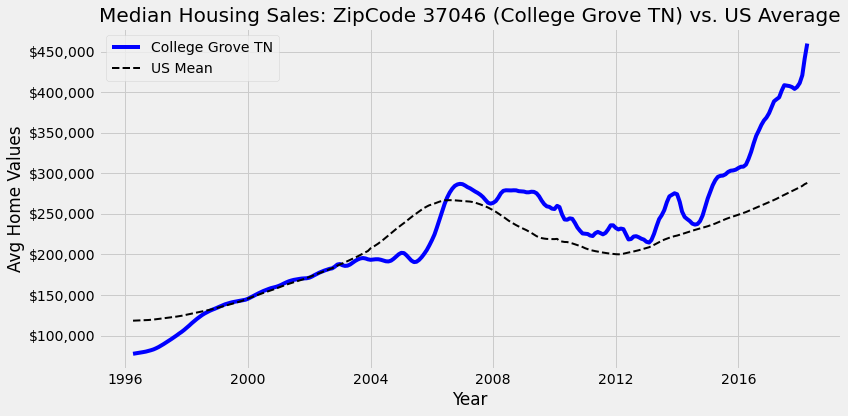

In [437]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(zip_37046_ts, label='College Grove TN', color='blue')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', ls='--',
                     color='black', linewidth=(2), label='US Mean');
ax.legend()
ax.set_title("Median Housing Sales: ZipCode 37046 (College Grove TN) vs. US Average", fontsize = 20)
ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [158]:
#sarimax_param_search(zip_37046_ts)

In [159]:
#Optimal SARIMA order: ((1, 1, 1), (1, 1, 1, 12)) AIC: 4342.43246819299
zip_37046_combo_1 = ((1, 1, 1), (1, 1, 1, 12))

In [160]:
# Optimal SARIMA order: ((1, 1, 2), (1, 2, 2, 12)) AIC: 3884.017214422042
zip_37046_combo_2 = ((1, 1, 2), (1, 2, 2, 12))

### Model #1

In [161]:
combo = zip_37046_combo_1
combo

((1, 1, 1), (1, 1, 1, 12))

In [162]:
# Manually split data.
temp_ts = zip_37046_ts

SPLIT = int(temp_ts.shape[0]*0.80)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  212
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1653.443
Date:                            Sat, 21 May 2022   AIC                           3316.886
Time:                                    12:29:42   BIC                           3332.988
Sample:                                04-01-1996   HQIC                          3323.412
                                     - 11-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7207      0.045     15.929      0.000       0.632       0.809
ma.L1          0.4620      0.031     14.760      0.000       0.401       0.523
ar.S.L12      -0.5758      0.081     -7.088      0.000      -0.735      -0.417
ma.S.L12      -0.0671      0.071     -0.943      0.346      -0.207       0.072
sigma2      3.801e+06    3.1e+05     12.254      0.000    3.19e+06    4.41e+06
===================================================================================
Ljung-Box (L1) (Q):                   5.82   Jarque-Bera (JB):               115.83
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               8.59   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [163]:
zip_37046_model_1 = sarima_model

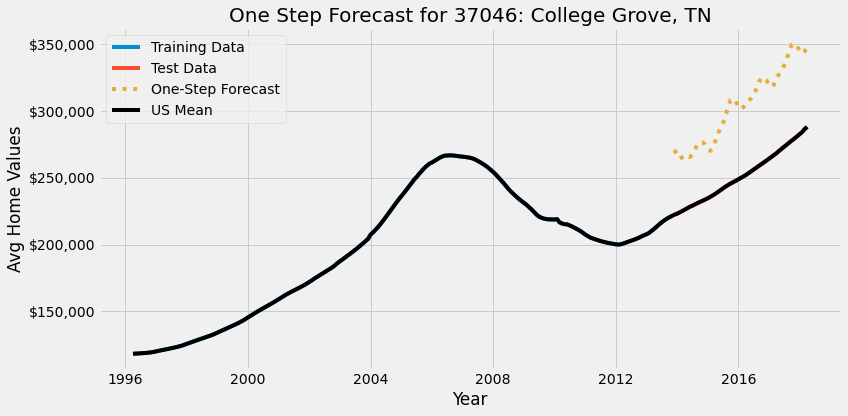

In [466]:
pred = zip_37046_model_1.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=True)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='black', label='US Mean');

ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("One Step Forecast for 37046: College Grove, TN", fontsize = 20)
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [165]:
y_forecasted = pred.predicted_mean
y_truth = test['value']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 1834575615.05
The Root Mean Squared Error is 42831.95


### Model #2

In [166]:
combo = zip_37046_combo_2
combo

((1, 1, 2), (1, 2, 2, 12))

In [167]:
# Manually split data.
temp_ts = zip_37046_ts

SPLIT = int(temp_ts.shape[0]*0.80)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  212
Model:             SARIMAX(1, 1, 2)x(1, 2, 2, 12)   Log Likelihood               -1485.272
Date:                            Sat, 21 May 2022   AIC                           2984.544
Time:                                    12:29:45   BIC                           3006.071
Sample:                                04-01-1996   HQIC                          2993.285
                                     - 11-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3557      0.204      1.744      0.081      -0.044       0.756
ma.L1          1.2094      0.166      7.272      0.000       0.883       1.535
ma.L2          0.5077      0.176      2.888      0.004       0.163       0.852
ar.S.L12      -0.6626      0.300     -2.210      0.027      -1.250      -0.075
ma.S.L12      -0.3840      0.295     -1.302      0.193      -0.962       0.194
ma.S.L24       0.0702      0.284      0.247      0.805      -0.487       0.628
sigma2      1.244e+07   1.85e-08   6.73e+14      0.000    1.24e+07    1.24e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                46.08
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               8.97   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.63
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number  2e+31. Standard errors may be unstable.
"""

In [168]:
zip_37046_model_2 = sarima_model

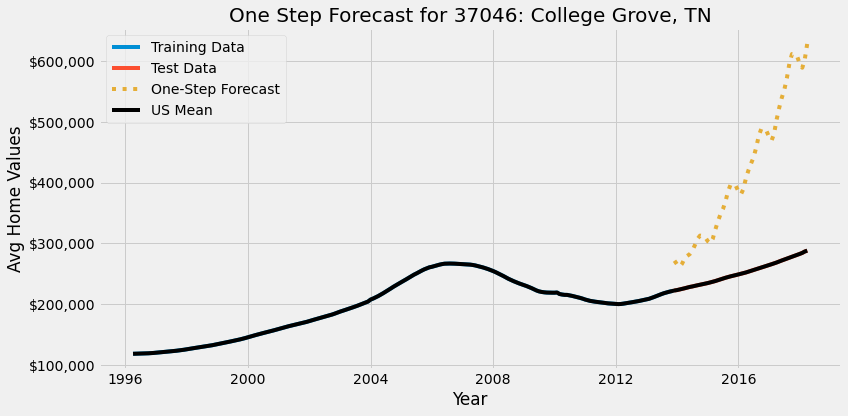

In [467]:
pred = zip_37046_model_2.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=True)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='black', label='US Mean');
ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("One Step Forecast for 37046: College Grove, TN", fontsize = 20)
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [170]:
y_forecasted = pred.predicted_mean
y_truth = test['value']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 11513817677.28
The Root Mean Squared Error is 107302.46


### Decision: 
- Model 1 has a lower RSME and it's one-step forecast better matches the test data. 

### Prediction

In [171]:
combo = zip_37046_combo_1
#combo = zip_37046_combo_2
combo

((1, 1, 1), (1, 1, 1, 12))

In [172]:
# Running model again with FULL data

sarima_model = SARIMAX(
    zip_37046_ts,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2166.216
Date:                            Sat, 21 May 2022   AIC                           4342.432
Time:                                    12:29:46   BIC                           4359.794
Sample:                                04-01-1996   HQIC                          4349.429
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7166      0.057     12.507      0.000       0.604       0.829
ma.L1          0.7790      0.037     21.255      0.000       0.707       0.851
ar.S.L12       0.2480      0.086      2.898      0.004       0.080       0.416
ma.S.L12      -0.6107      0.068     -8.928      0.000      -0.745      -0.477
sigma2      5.939e+06   5.34e+05     11.114      0.000    4.89e+06    6.99e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.19   Jarque-Bera (JB):                31.81
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):               7.74   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [173]:
zip_37046_model_full = sarima_model

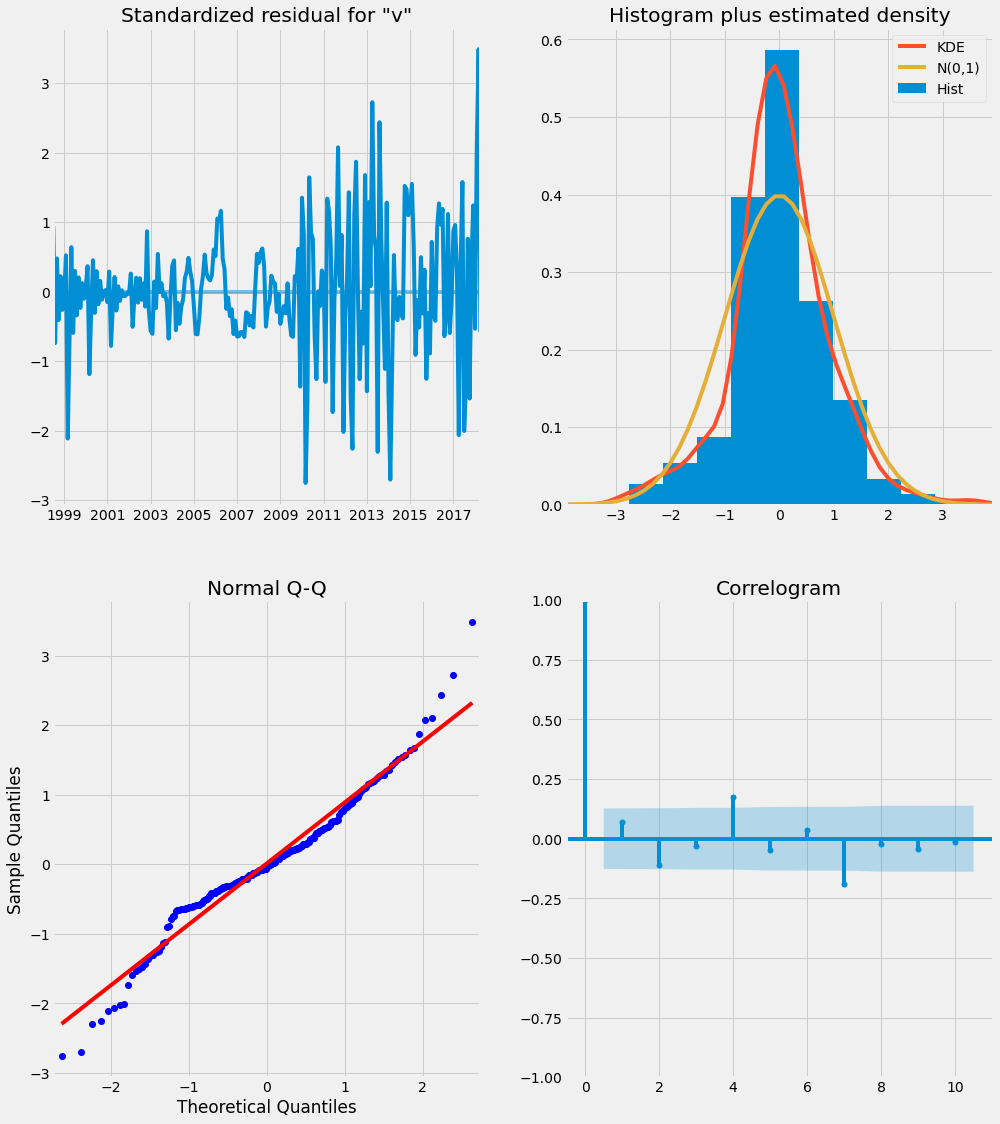

In [174]:
zip_37046_model_full.plot_diagnostics(figsize=(15, 18))
plt.show()

In [175]:
zip_37046_ts.tail(1)

value
time                 
2018-04-01 459,800.00

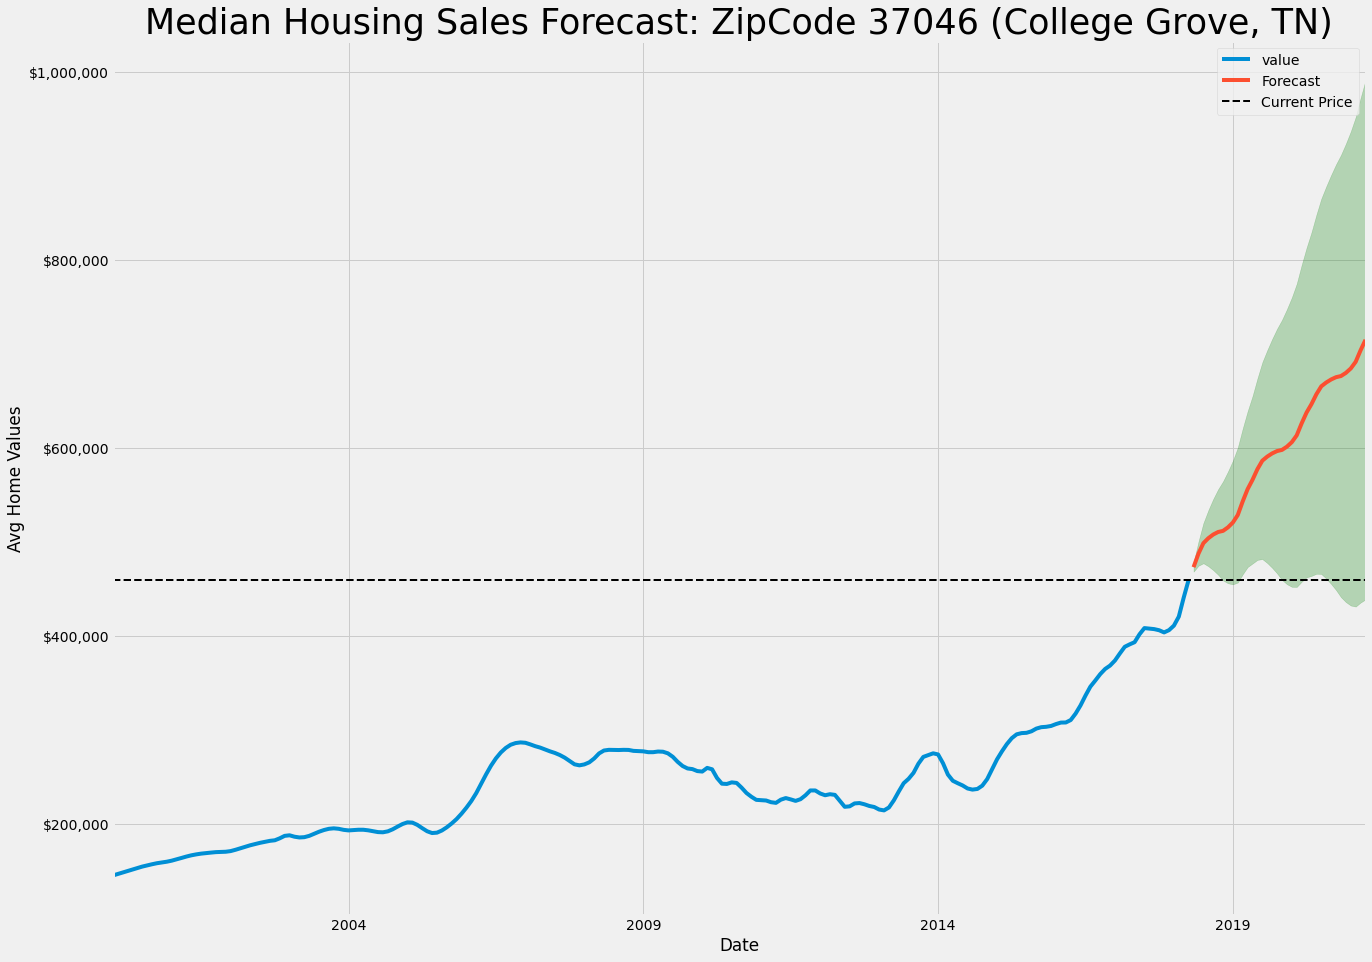

In [176]:
# Get forecast 3 yrs ahead in future (36 steps)
prediction = zip_37046_model_full.get_forecast(steps=36)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals
ax = zip_37046_ts['2000-01':].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='green', alpha=0.25)

ax.axhline(459800, ls='--', color='black', linewidth=(2), label='Current Price')

ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Values')
ax.set_title("Median Housing Sales Forecast: ZipCode 37046 (College Grove, TN)", fontsize = 35)
ax.yaxis.set_major_formatter(tick) 

plt.legend()
plt.show()

### Analysis: 
- Potential loss forecast for the next three years is minimal. Model confidence interval lower value for year 3 is 439,002, which would just be a loss of 20,000. 
- While potential loss is low, potential gain is high. I recommend this as a zipcode to pursue.

In [177]:
print('Forecast Values')
print(prediction.predicted_mean.resample('Y').mean())
print('----------------------------------')
print('Confidence Index')
print(pred_conf.resample('Y').mean())

Forecast Values
2018-12-31   501,253.86
2019-12-31   571,721.86
2020-12-31   652,309.15
2021-12-31   698,855.46
Freq: A-DEC, Name: predicted_mean, dtype: float64
----------------------------------
Confidence Index
            lower value  upper value
2018-12-31   468,257.69   534,250.03
2019-12-31   468,612.24   674,831.47
2020-12-31   455,392.58   849,225.72
2021-12-31   434,655.38   963,055.53


## Metrics

In [178]:
zip_37046_ts.tail(1)

value
time                 
2018-04-01 459,800.00

In [179]:
analysis_df = pred_conf.resample('Y').mean()
analysis_df['mean'] = analysis_df.apply(lambda x: x.mean(), axis=1)

analysis_df['base'] = 459800
analysis_df['base'] = analysis_df['base'].astype(float)

In [180]:
analysis_df = analysis_df[['base', 'lower value', 'mean', 'upper value']]

analysis_df['Min_ROI'] = analysis_df.apply(lambda x: x['lower value'] - x['base'], axis=1)
analysis_df['Min_ROI%'] = analysis_df.apply(lambda x: x['Min_ROI'] / x['base'], axis=1)
analysis_df['Forecast_ROI'] = analysis_df.apply(lambda x: x['mean'] - x['base'], axis=1)
analysis_df['Forecast_ROI%'] = analysis_df.apply(lambda x: x['mean'] / x['base'], axis=1)
analysis_df['Max_ROI'] = analysis_df.apply(lambda x: x['upper value'] - x['base'], axis=1)
analysis_df['Max_ROI%'] = analysis_df.apply(lambda x: x['upper value'] / x['base'], axis=1)

In [181]:
analysis_df

base  lower value       mean  upper value    Min_ROI  \
2018-12-31 459,800.00   468,257.69 501,253.86   534,250.03   8,457.69   
2019-12-31 459,800.00   468,612.24 571,721.86   674,831.47   8,812.24   
2020-12-31 459,800.00   455,392.58 652,309.15   849,225.72  -4,407.42   
2021-12-31 459,800.00   434,655.38 698,855.46   963,055.53 -25,144.62   

            Min_ROI%  Forecast_ROI  Forecast_ROI%    Max_ROI  Max_ROI%  
2018-12-31      0.02     41,453.86           1.09  74,450.03      1.16  
2019-12-31      0.02    111,921.86           1.24 215,031.47      1.47  
2020-12-31     -0.01    192,509.15           1.42 389,425.72      1.85  
2021-12-31     -0.05    239,055.46           1.52 503,255.53      2.09

In [182]:
zip_37046_metrics = analysis_df

## <b><u>98043: Mountlake Terrace WA </b></u>

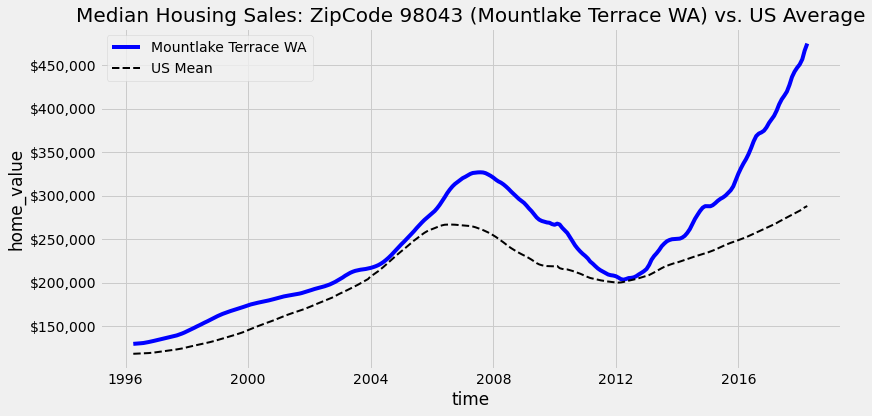

In [183]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(zip_98043_ts, label='Mountlake Terrace WA', color='blue')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', ls='--',
                     color='black', linewidth=(2), label='US Mean');
ax.legend()
ax.set_title("Median Housing Sales: ZipCode 98043 (Mountlake Terrace WA) vs. US Average", fontsize = 20)
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [184]:
#sarimax_param_search(zip_98043_ts)

In [185]:
#SARIMA Combos: ((1, 1, 1), (1, 1, 1, 12)) AIC: 3916.8599638578153
zip_98403_combo_1 = ((1, 1, 1), (1, 1, 1, 12))

In [186]:
#SARIMA Combos: ((2, 2, 2), (2, 2, 2, 12)) AIC: 3577.2395803210907
zip_98403_combo_2 = ((2, 2, 2), (2, 2, 2, 12))

### Model #1

In [187]:
combo = zip_98403_combo_1
#combo = zip_98403_combo_2
combo

((1, 1, 1), (1, 1, 1, 12))

In [188]:
# Manually split data.
temp_ts = zip_98043_ts

SPLIT = int(temp_ts.shape[0]*0.8)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  212
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1470.060
Date:                            Sat, 21 May 2022   AIC                           2950.121
Time:                                    12:29:47   BIC                           2966.222
Sample:                                04-01-1996   HQIC                          2956.646
                                     - 11-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9355      0.018     52.004      0.000       0.900       0.971
ma.L1          0.2389      0.023     10.276      0.000       0.193       0.285
ar.S.L12      -0.5693      0.051    -11.109      0.000      -0.670      -0.469
ma.S.L12      -0.0208      0.036     -0.573      0.566      -0.092       0.050
sigma2      4.569e+05   2.75e+04     16.591      0.000    4.03e+05    5.11e+05
===================================================================================
Ljung-Box (L1) (Q):                   2.18   Jarque-Bera (JB):               190.87
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):              21.30   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [189]:
zip_98043_model_1 = sarima_model

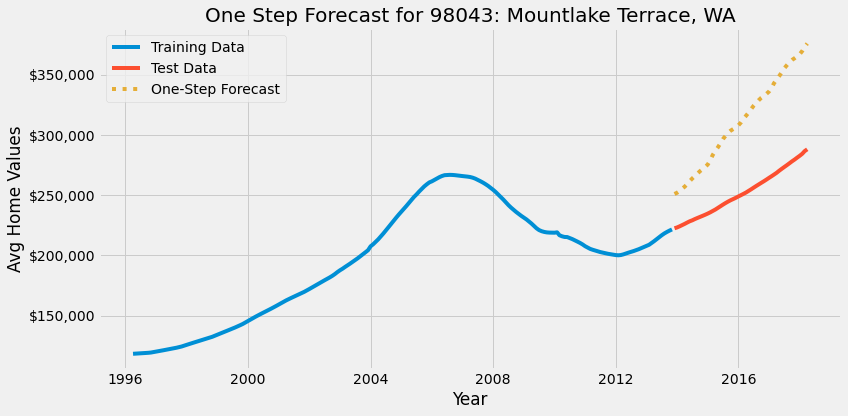

In [468]:
pred = zip_98043_model_1.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=True)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
#line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='black', label='US Mean');
ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("One Step Forecast for 98043: Mountlake Terrace, WA", fontsize = 20)
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [191]:
y_forecasted = pred.predicted_mean
y_truth = test['value']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 1799294145.98
The Root Mean Squared Error is 42418.09


### Model #2

In [192]:
#combo = zip_98403_combo_1
combo = zip_98403_combo_2
combo

((2, 2, 2), (2, 2, 2, 12))

In [193]:
# Manually split data.
temp_ts = zip_98043_ts

SPLIT = int(temp_ts.shape[0]*0.8)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  212
Model:             SARIMAX(2, 2, 2)x(2, 2, 2, 12)   Log Likelihood               -1312.585
Date:                            Sat, 21 May 2022   AIC                           2643.170
Time:                                    12:29:54   BIC                           2670.790
Sample:                                04-01-1996   HQIC                          2654.386
                                     - 11-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7604      0.177     -4.303      0.000      -1.107      -0.414
ar.L2         -0.4977      0.126     -3.947      0.000      -0.745      -0.251
ma.L1          1.2923      0.178      7.251      0.000       0.943       1.642
ma.L2          0.6167      0.135      4.576      0.000       0.353       0.881
ar.S.L12      -0.1668      0.105     -1.588      0.112      -0.373       0.039
ar.S.L24       0.2869      0.101      2.827      0.005       0.088       0.486
ma.S.L12      -0.8459      0.102     -8.314      0.000      -1.045      -0.647
ma.S.L24       0.1526      0.142      1.079      0.281      -0.125       0.430
sigma2      1.301e+06   1.88e+05      6.915      0.000    9.32e+05    1.67e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.55   Jarque-Bera (JB):                18.96
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               4.82   Skew:                             0.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [194]:
zip_98043_model_2 = sarima_model

In [469]:
pred = zip_98043_model_2.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=True)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
#line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='black', label='US Mean');

ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("One Step Forecast for 98043: Mountlake Terrace, WA", fontsize = 20
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

SyntaxError: invalid syntax (<ipython-input-469-485a7c8e6f15>, line 15)

In [196]:
y_forecasted = pred.predicted_mean
y_truth = test['value']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 374885110.5
The Root Mean Squared Error is 19361.95


### Decision:
- Model 2 has a better RSME and also better models the test data. I will use this one for my predictions.

### Prediction

In [197]:
#combo = zip_98403_combo_1
combo = zip_98403_combo_2
combo

((2, 2, 2), (2, 2, 2, 12))

In [198]:
# Running model again with FULL data

sarima_model = SARIMAX(
    zip_98043_ts,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(2, 2, 2)x(2, 2, 2, 12)   Log Likelihood               -1779.620
Date:                            Sat, 21 May 2022   AIC                           3577.240
Time:                                    12:30:02   BIC                           3607.449
Sample:                                04-01-1996   HQIC                          3589.449
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4393      0.091      4.813      0.000       0.260       0.618
ar.L2         -0.5197      0.060     -8.698      0.000      -0.637      -0.403
ma.L1          0.1085      0.109      0.992      0.321      -0.106       0.323
ma.L2         -0.0419      0.077     -0.547      0.584      -0.192       0.108
ar.S.L12      -1.2029      0.061    -19.814      0.000      -1.322      -1.084
ar.S.L24      -0.7024      0.064    -10.907      0.000      -0.829      -0.576
ma.S.L12      -0.0171      0.051     -0.336      0.737      -0.117       0.082
ma.S.L24      -0.0537      0.041     -1.309      0.191      -0.134       0.027
sigma2      1.127e+06   8.73e+04     12.917      0.000    9.56e+05     1.3e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                30.06
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):              15.08   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [199]:
zip_98043_model_full = sarima_model

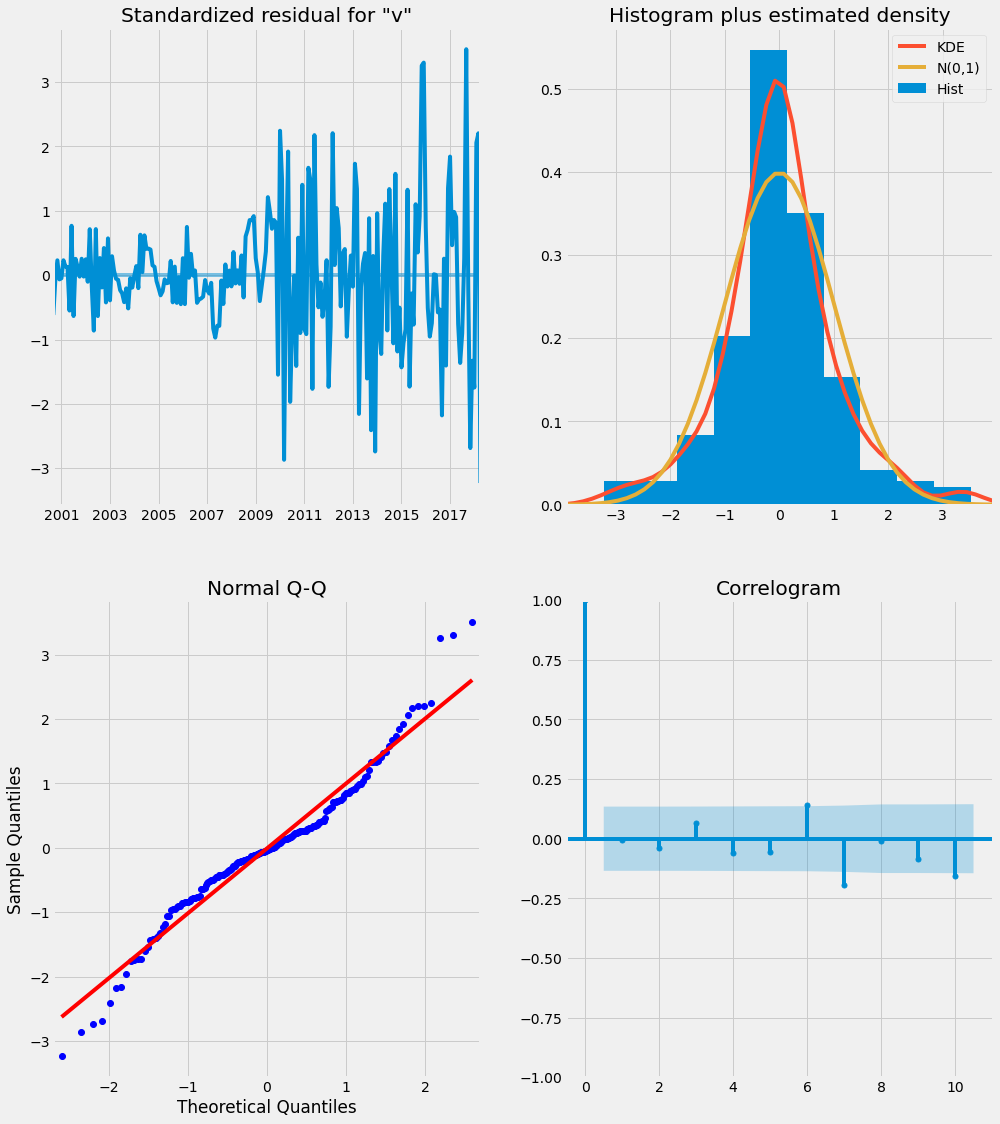

In [200]:
zip_98043_model_full.plot_diagnostics(figsize=(15,18))
plt.show()

In [201]:
zip_98043_ts.tail(1)

value
time                 
2018-04-01 474,700.00

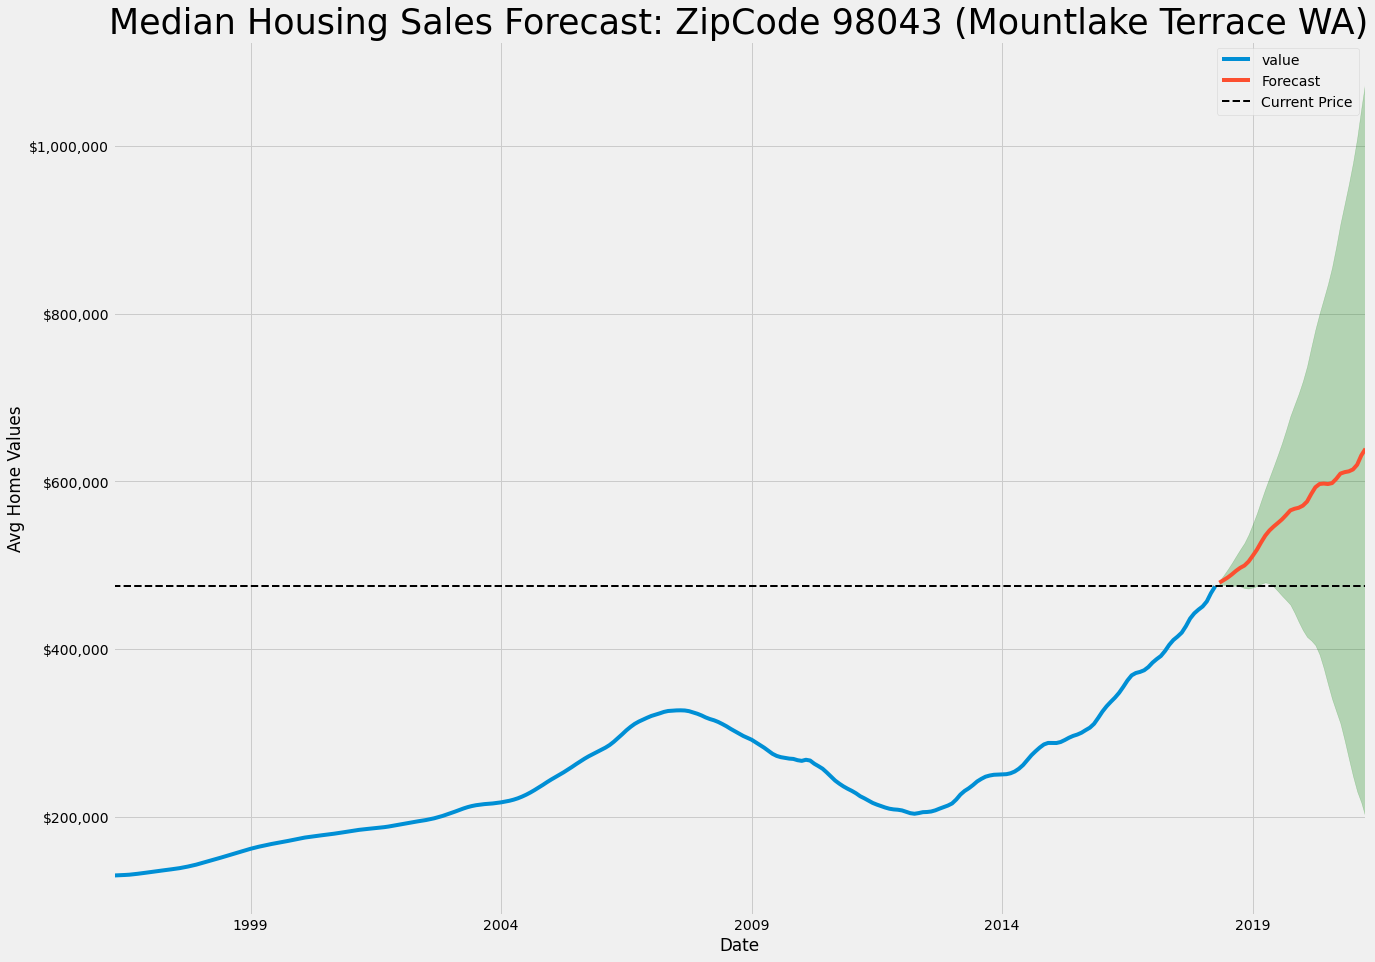

In [202]:
# Get forecast 3 yrs ahead in future (36 steps)
prediction = zip_98043_model_full.get_forecast(steps=36)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals
ax = zip_98043_ts['1996-01':].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='green', alpha=0.25)

ax.axhline(474700, ls='--', color='black', linewidth=(2), label='Current Price')

ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Values')
ax.set_title("Median Housing Sales Forecast: ZipCode 98043 (Mountlake Terrace WA)", fontsize = 35)
ax.yaxis.set_major_formatter(tick) 

plt.legend()
plt.show()

### Analysis: 
- No losses forecast for yr1, and minimal for year 2. Then the confidence window greatly widens and has a lot of uncertainty. I recommend this for a 1-2 year investment.

## <b><u>98178: Bryn Mewer-Skyway WA</b></u>

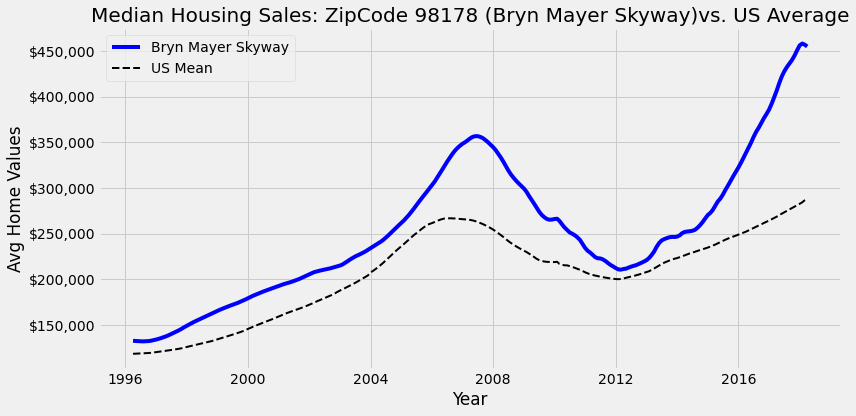

In [438]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(zip_98178_ts, label='Bryn Mayer Skyway', color='blue')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', ls='--',
                     color='black', linewidth=(2), label='US Mean');

ax.legend()
ax.set_title("Median Housing Sales: ZipCode 98178 (Bryn Mayer Skyway)vs. US Average", fontsize = 20)
ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [205]:
#sarimax_param_search(zip_98178_ts)

In [206]:
#SARIMA Combos: ((1, 1, 1), (1, 1, 1, 12)) AIC: 3762.954984096742
zip_98178_combo_1 = ((1, 1, 1), (1, 1, 1, 12))

### Model #1

In [207]:
combo = zip_98178_combo_1
combo

((1, 1, 1), (1, 1, 1, 12))

In [208]:
# Manually split data.
temp_ts = zip_98178_ts

SPLIT = int(temp_ts.shape[0]*0.80)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  212
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1438.599
Date:                            Sat, 21 May 2022   AIC                           2887.198
Time:                                    12:30:03   BIC                           2903.300
Sample:                                04-01-1996   HQIC                          2893.723
                                     - 11-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9440      0.021     45.477      0.000       0.903       0.985
ma.L1          0.3234      0.037      8.635      0.000       0.250       0.397
ar.S.L12      -0.2794      0.073     -3.831      0.000      -0.422      -0.136
ma.S.L12      -0.0162      0.055     -0.295      0.768      -0.124       0.091
sigma2      3.356e+05   2.35e+04     14.272      0.000     2.9e+05    3.82e+05
===================================================================================
Ljung-Box (L1) (Q):                   8.18   Jarque-Bera (JB):               228.73
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              14.61   Skew:                             0.14
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [209]:
zip_98178_model_1 = sarima_model

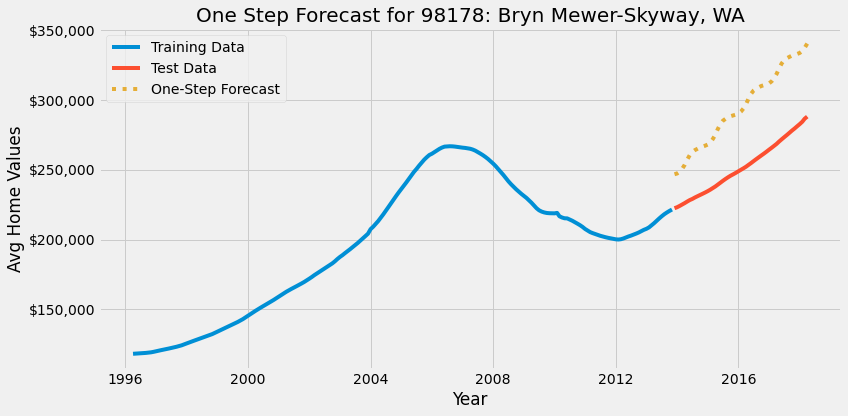

In [471]:
pred = zip_98178_model_1.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=True)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
#line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='black', label='US Mean');

ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("One Step Forecast for 98178: Bryn Mewer-Skyway, WA", fontsize = 20)
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [211]:
y_forecasted = pred.predicted_mean
y_truth = test['value']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 3883551680.49
The Root Mean Squared Error is 62318.15


### Model #2

In [212]:
#sarimax_param_search(zip_98178_ts)

In [213]:
#Optimal SARIMA order: ((2, 2, 2), (1, 2, 2, 12)) AIC: 3436.031197456773
zip_98178_combo_2 = ((2, 2, 2), (1, 2, 2, 12))

In [214]:
combo = zip_98178_combo_2
combo

((2, 2, 2), (1, 2, 2, 12))

In [215]:
# Manually split data.
temp_ts = zip_98178_ts

SPLIT = int(temp_ts.shape[0]*0.80)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  212
Model:             SARIMAX(2, 2, 2)x(1, 2, 2, 12)   Log Likelihood               -1288.019
Date:                            Sat, 21 May 2022   AIC                           2592.037
Time:                                    12:30:10   BIC                           2616.588
Sample:                                04-01-1996   HQIC                          2602.007
                                     - 11-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5286      0.340     -1.553      0.120      -1.196       0.138
ar.L2          0.0074      0.129      0.057      0.954      -0.245       0.260
ma.L1          1.2894      0.311      4.151      0.000       0.681       1.898
ma.L2          0.4993      0.153      3.272      0.001       0.200       0.798
ar.S.L12      -0.6354      0.105     -6.030      0.000      -0.842      -0.429
ma.S.L12      -0.3484      0.105     -3.317      0.001      -0.554      -0.143
ma.S.L24       0.1183      0.075      1.572      0.116      -0.029       0.266
sigma2      7.849e+05   7.01e+04     11.192      0.000    6.47e+05    9.22e+05
===================================================================================
Ljung-Box (L1) (Q):                   2.96   Jarque-Bera (JB):               165.74
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):              15.72   Skew:                            -0.67
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [216]:
zip_98178_model_2 = sarima_model

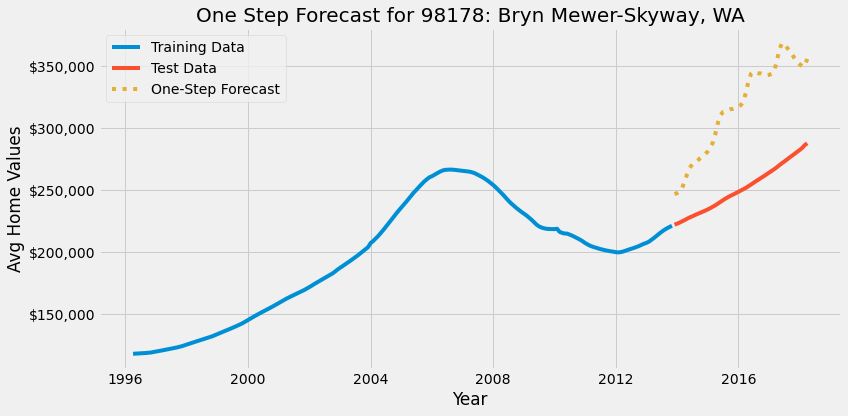

In [472]:
pred = zip_98178_model_2.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=True)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
#line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='black', label='US Mean');
ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("One Step Forecast for 98178: Bryn Mewer-Skyway, WA", fontsize = 20)
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [218]:
y_forecasted = pred.predicted_mean
y_truth = test['value']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 1987691995.51
The Root Mean Squared Error is 44583.54


### Decision:
- Model 2 has a lower RSME and is a closer match for the test data.

### Prediction

In [219]:
#combo = zip_98178_combo_1
combo = zip_98178_combo_2
combo

((2, 2, 2), (1, 2, 2, 12))

In [220]:
# Running model again with FULL data

sarima_model = SARIMAX(
    zip_98178_ts,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(2, 2, 2)x(1, 2, 2, 12)   Log Likelihood               -1710.016
Date:                            Sat, 21 May 2022   AIC                           3436.031
Time:                                    12:30:18   BIC                           3462.884
Sample:                                04-01-1996   HQIC                          3446.884
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2103      0.167      1.257      0.209      -0.118       0.538
ar.L2         -0.0241      0.045     -0.535      0.593      -0.112       0.064
ma.L1          0.3129      0.140      2.231      0.026       0.038       0.588
ma.L2          0.0462      0.089      0.517      0.605      -0.129       0.221
ar.S.L12       0.2883      0.023     12.636      0.000       0.244       0.333
ma.S.L12      -1.9804      0.061    -32.216      0.000      -2.101      -1.860
ma.S.L24       1.0102      0.072     14.071      0.000       0.870       1.151
sigma2      3.942e+05   3.09e-07   1.28e+12      0.000    3.94e+05    3.94e+05
===================================================================================
Ljung-Box (L1) (Q):                   2.79   Jarque-Bera (JB):               160.90
Prob(Q):                              0.09   Prob(JB):                         0.00
Heteroskedasticity (H):               7.25   Skew:                            -0.95
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.13e+28. Standard errors may be unstable.
"""

In [221]:
zip_98178_model_full = sarima_model

In [222]:
zip_98178_ts.tail(1)

value
time                 
2018-04-01 455,100.00

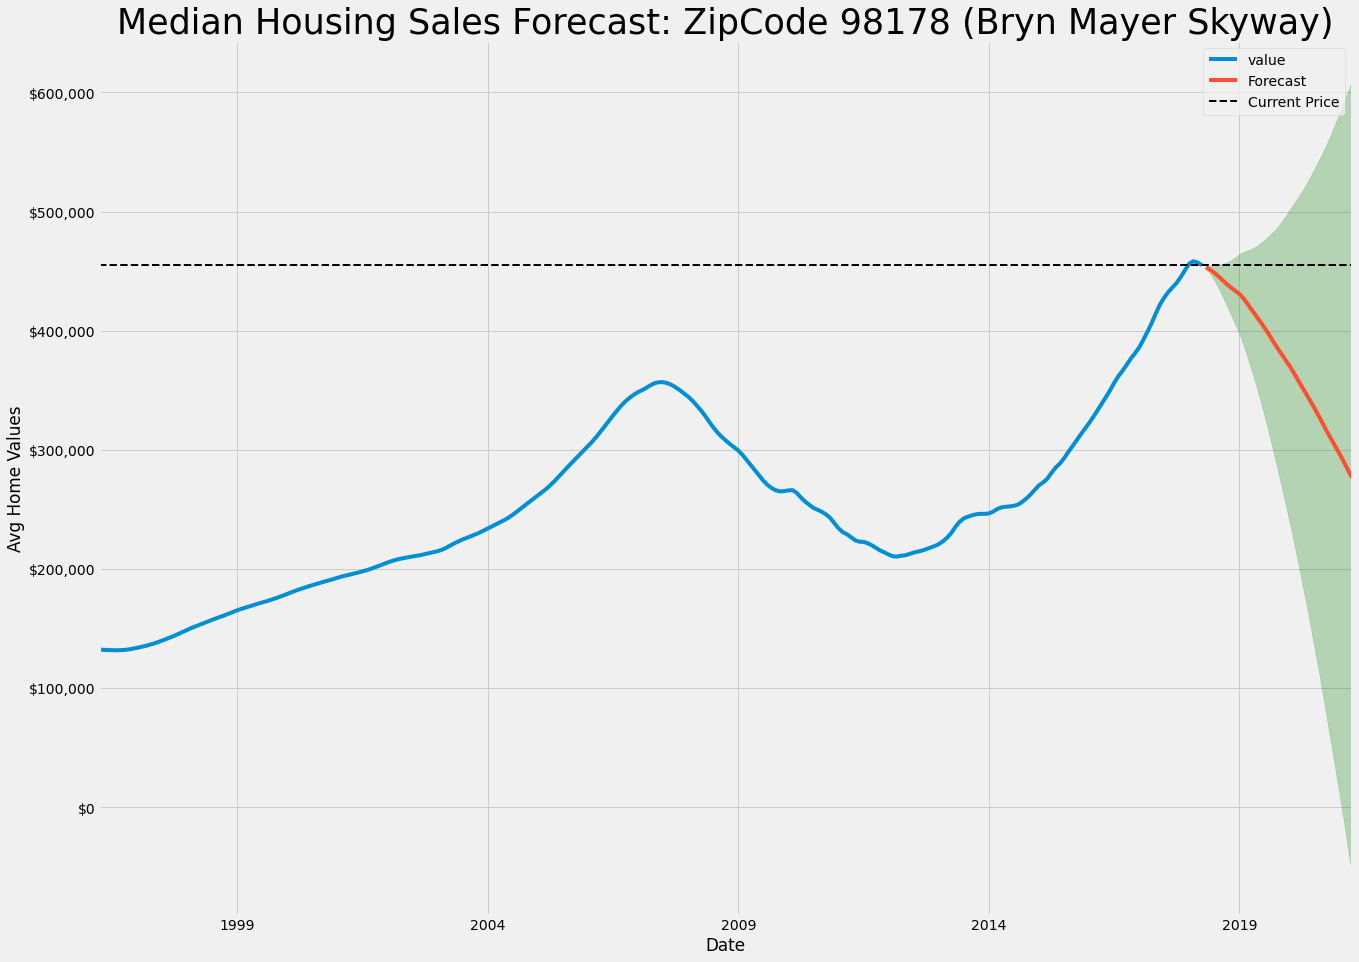

In [223]:
# Get forecast 3 yrs ahead in future (36 steps)
prediction = zip_98178_model_full.get_forecast(steps=36)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals
ax = zip_98178_ts['1996-01':].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='green', alpha=0.25)

ax.axhline(455100, ls='--', color='black', linewidth=(2), label='Current Price')

ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Values')
ax.set_title("Median Housing Sales Forecast: ZipCode 98178 (Bryn Mayer Skyway)", fontsize = 35)
ax.yaxis.set_major_formatter(tick) 

plt.legend()
plt.show()

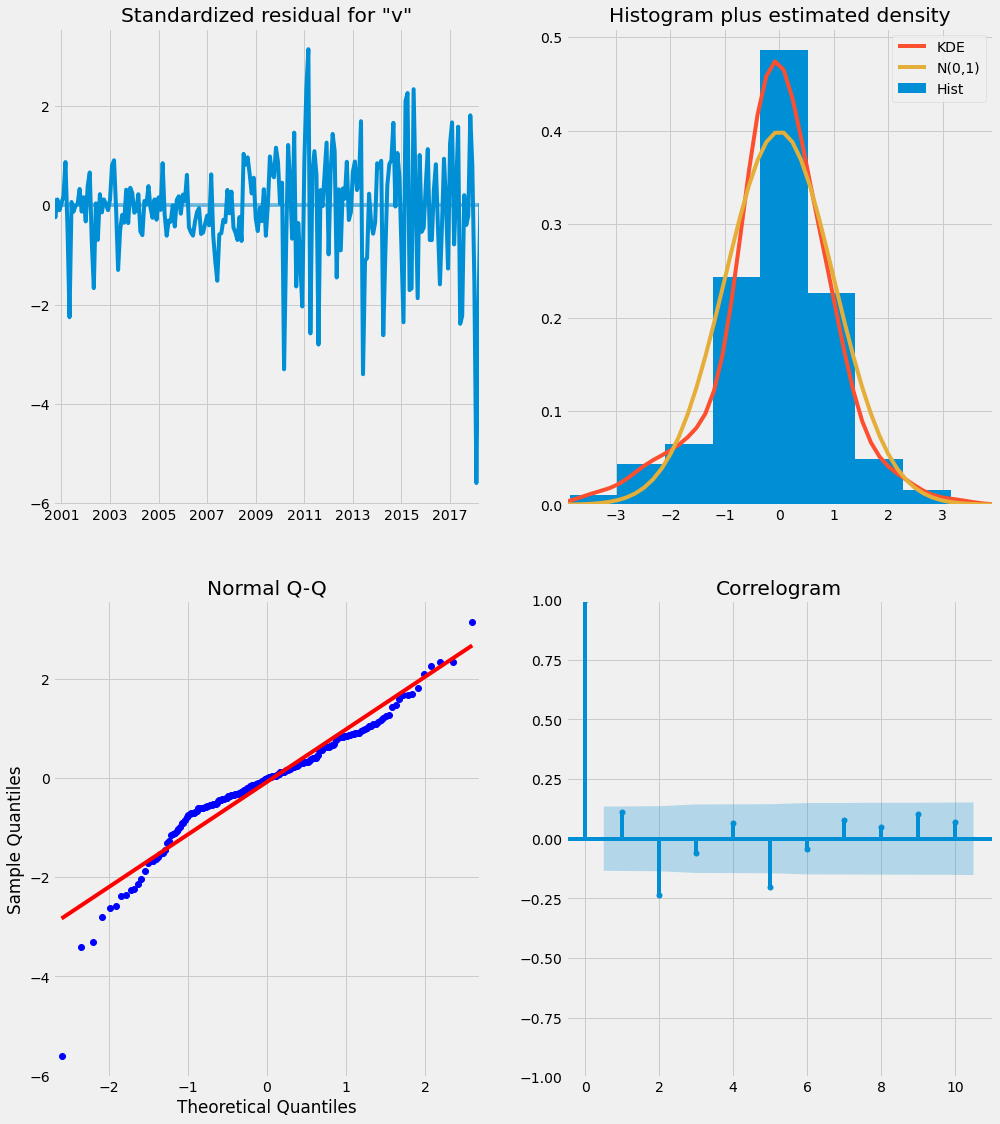

In [224]:
zip_98178_model_full.plot_diagnostics(figsize=(15,18))
plt.show()

### Analysis: 
- Model forecast mean predicts increasing losses. The confidence interval doesn't show a lot of optimism for profits. I do not recommend investing in this zipcode in any form.

## <b><u>94621: Oakland CA </b></u>

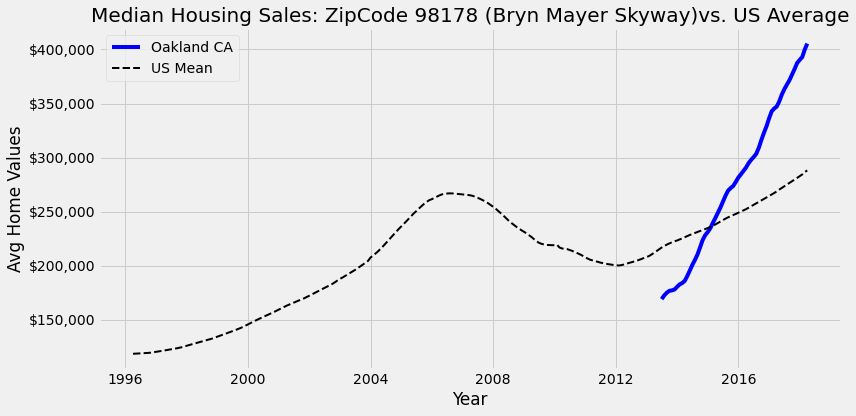

In [439]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(zip_94621_ts, label='Oakland CA', color='blue')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', ls='--',
                     color='black', linewidth=(2), label='US Mean');

ax.legend()
ax.set_title("Median Housing Sales: ZipCode 98178 (Bryn Mayer Skyway)vs. US Average", fontsize = 20)
ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

### Analysis: SKIP. Not Enough Data to Model
- This must be a new ZipCode. There isn't enough data for me to be comfortable modeling, so I am going to skip this Zip Code and move on to the next one.
- Since I am looking for a maximum of one Zip Code per state, this isn't a big deal.

## <b><u>02128 Boston MA </b></u>

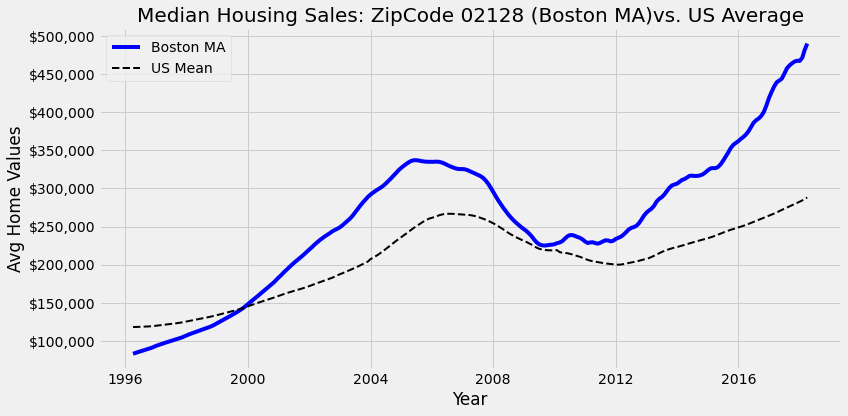

In [440]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(zip_02128_ts, label='Boston MA', color='blue')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', ls='--',
                     color='black', linewidth=(2), label='US Mean');

ax.legend()
ax.set_title("Median Housing Sales: ZipCode 02128 (Boston MA)vs. US Average", fontsize = 20)
ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [227]:
#sarimax_param_search(zip_02128_ts)

In [228]:
#SARIMA Combos: ((1, 1, 1), (1, 1, 1, 12)) AIC: 3948.4693734854354
zip_02128_combo_1 = ((1, 1, 1), (1, 1, 1, 12))

### Model #1

In [229]:
combo = zip_02128_combo_1
#combo = zip_98403_combo_2
combo

((1, 1, 1), (1, 1, 1, 12))

In [230]:
# Manually split data.
temp_ts = zip_02128_ts

SPLIT = int(temp_ts.shape[0]*0.80)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  212
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1457.125
Date:                            Sat, 21 May 2022   AIC                           2924.251
Time:                                    12:30:20   BIC                           2940.353
Sample:                                04-01-1996   HQIC                          2930.777
                                     - 11-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9244      0.025     36.850      0.000       0.875       0.974
ma.L1          0.7032      0.035     19.912      0.000       0.634       0.772
ar.S.L12       0.0726      0.036      2.042      0.041       0.003       0.142
ma.S.L12      -0.8359      0.054    -15.382      0.000      -0.942      -0.729
sigma2       3.09e+05   2.58e+04     11.997      0.000    2.59e+05     3.6e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.26   Jarque-Bera (JB):                64.63
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               7.25   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [231]:
zip_02128_model_1 = sarima_model

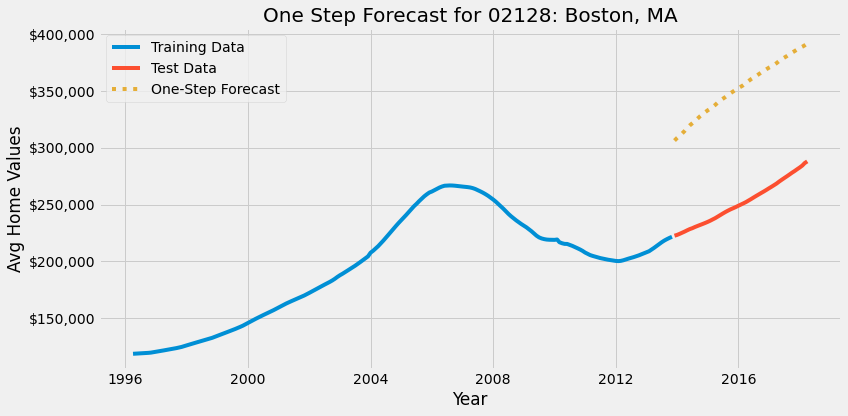

In [473]:
pred = zip_02128_model_1.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=True)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
#line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='black', label='US Mean');
ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("One Step Forecast for 02128: Boston, MA", fontsize = 20)
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [233]:
y_forecasted = pred.predicted_mean
y_truth = test['value']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 1829510970.86
The Root Mean Squared Error is 42772.78


### Model #2

In [234]:
#SARIMA Combos: ((2, 2, 2), (0, 2, 2, 12)) AIC: 3572.582171627717
zip_02128_combo_2 = ((2, 2, 2), (0, 2, 2, 12))

In [235]:
combo = zip_02128_combo_2
combo

((2, 2, 2), (0, 2, 2, 12))

In [236]:
# Manually split data.
temp_ts = zip_02128_ts

SPLIT = int(temp_ts.shape[0]*0.80)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  212
Model:             SARIMAX(2, 2, 2)x(0, 2, 2, 12)   Log Likelihood               -1322.603
Date:                            Sat, 21 May 2022   AIC                           2659.205
Time:                                    12:30:26   BIC                           2680.688
Sample:                                04-01-1996   HQIC                          2667.929
                                     - 11-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8227      0.180     -4.565      0.000      -1.176      -0.469
ar.L2         -0.2955      0.097     -3.058      0.002      -0.485      -0.106
ma.L1          1.7453      0.081     21.455      0.000       1.586       1.905
ma.L2          0.9452      0.084     11.271      0.000       0.781       1.110
ma.S.L12      -0.9155      0.160     -5.707      0.000      -1.230      -0.601
ma.S.L24       0.2140      0.133      1.605      0.109      -0.047       0.475
sigma2       1.58e+06   2.65e+05      5.964      0.000    1.06e+06     2.1e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.29   Jarque-Bera (JB):                58.28
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               5.62   Skew:                             0.26
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [237]:
zip_02128_model_2 = sarima_model

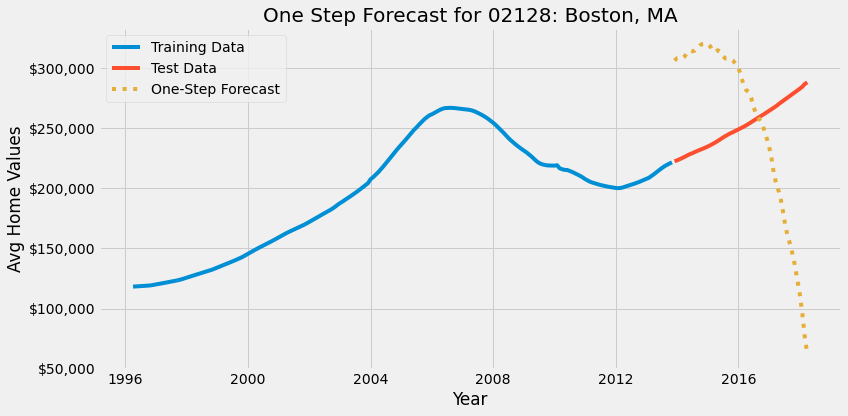

In [474]:
pred = zip_02128_model_2.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=True)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
#line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='black', label='US Mean');

ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("One Step Forecast for 02128: Boston, MA", fontsize = 20)
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [239]:
y_forecasted = pred.predicted_mean
y_truth = test['value']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 31606888091.33
The Root Mean Squared Error is 177783.26


### Decision:
- Model 2's Forecast doesn't follow the Test data at all, and it has a significantly higher RMSE so I am rejecting this model and sticking with model #1. 

### Boston Prediction

In [240]:
zip_02128_combo_1 = ((1, 1, 1), (1, 1, 1, 12))

In [241]:
combo = zip_02128_combo_1

In [242]:
combo

((1, 1, 1), (1, 1, 1, 12))

In [243]:
# Running model again with FULL data

sarima_model = SARIMAX(
    zip_02128_ts,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1969.235
Date:                            Sat, 21 May 2022   AIC                           3948.469
Time:                                    12:30:27   BIC                           3965.831
Sample:                                04-01-1996   HQIC                          3955.466
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7926      0.032     25.117      0.000       0.731       0.854
ma.L1          0.7739      0.028     27.686      0.000       0.719       0.829
ar.S.L12       0.0897      0.062      1.435      0.151      -0.033       0.212
ma.S.L12      -0.6286      0.049    -12.761      0.000      -0.725      -0.532
sigma2      8.071e+05   4.64e+04     17.388      0.000    7.16e+05    8.98e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.53   Jarque-Bera (JB):               230.85
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):              10.55   Skew:                             1.01
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [244]:
zip_02128_model_full = sarima_model

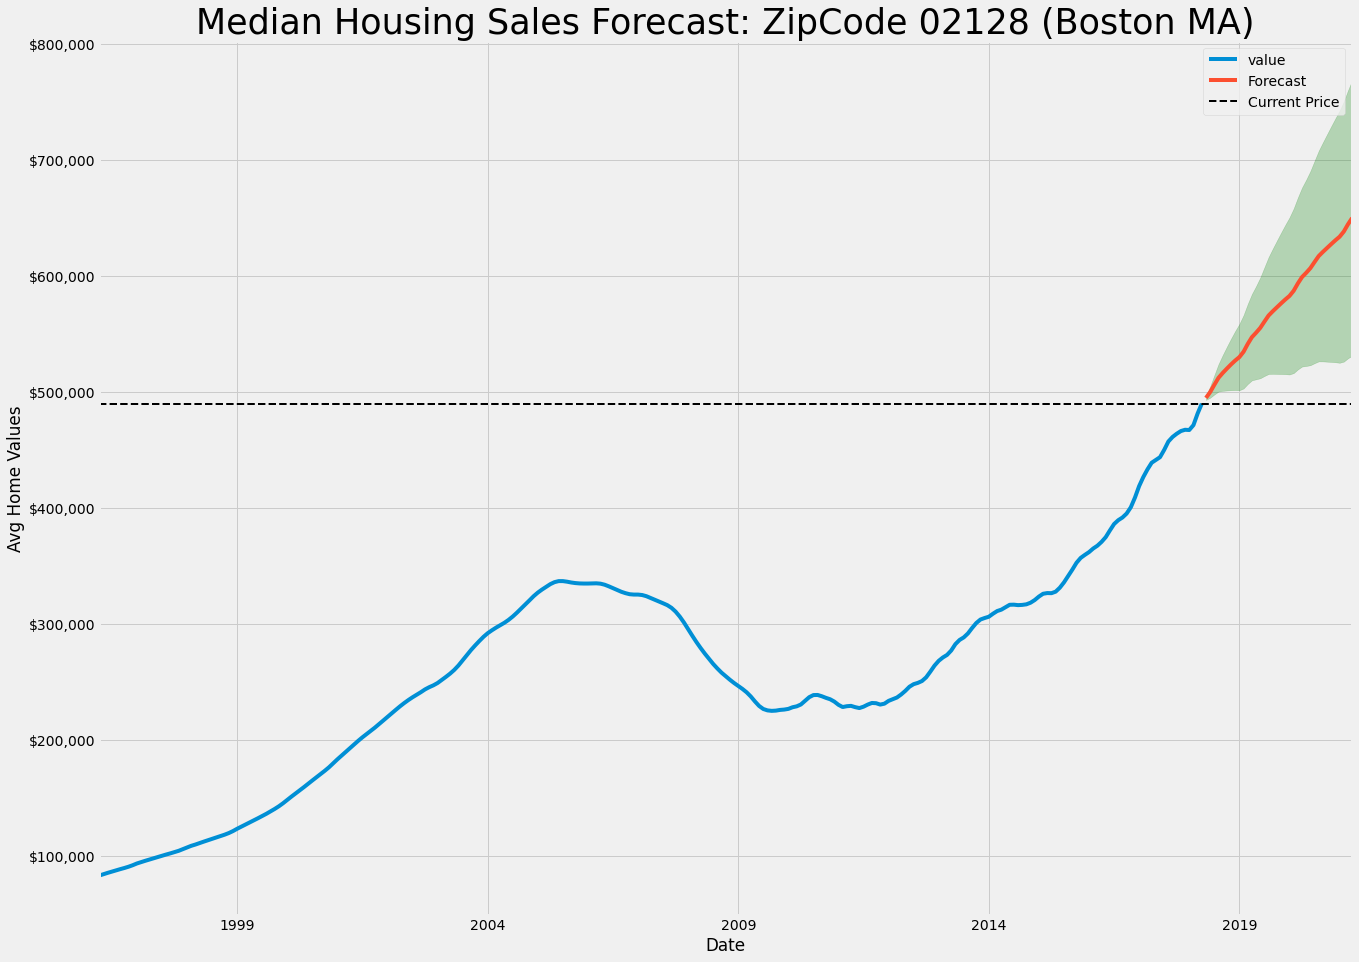

In [245]:
# Get forecast 3 yrs ahead in future (36 steps)
prediction = zip_02128_model_full.get_forecast(steps=36)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals
ax = zip_02128_ts['1996-01':].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='green', alpha=0.25)

ax.axhline(489400, ls='--', color='black', linewidth=(2), label='Current Price')

ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Values')
ax.set_title("Median Housing Sales Forecast: ZipCode 02128 (Boston MA)", fontsize = 35)
ax.yaxis.set_major_formatter(tick) 

plt.legend()
plt.show()

### Analysis: 
- confidence window is narrow and even the lower forecasted values are gains. I definitely recommend this zipcode!

### Metrics

In [247]:
analysis_df = pred_conf.resample('Y').mean()

In [248]:
analysis_df['mean'] = analysis_df.apply(lambda x: x.mean(), axis=1)

In [249]:
analysis_df = pred_conf.resample('Y').mean()
analysis_df['mean'] = analysis_df.apply(lambda x: x.mean(), axis=1)

analysis_df['base'] = 489900
analysis_df['base'] = analysis_df['base'].astype(float)

analysis_df = analysis_df[['base', 'lower value', 'mean', 'upper value']]

analysis_df['Min_ROI'] = analysis_df.apply(lambda x: x['lower value'] - x['base'], axis=1)
analysis_df['Min_ROI%'] = analysis_df.apply(lambda x: x['Min_ROI'] / x['base'], axis=1)
analysis_df['Forecast_ROI'] = analysis_df.apply(lambda x: x['mean'] - x['base'], axis=1)
analysis_df['Forecast_ROI%'] = analysis_df.apply(lambda x: x['mean'] / x['base'], axis=1)
analysis_df['Max_ROI'] = analysis_df.apply(lambda x: x['upper value'] - x['base'], axis=1)
analysis_df['Max_ROI%'] = analysis_df.apply(lambda x: x['upper value'] / x['base'], axis=1)

In [250]:
zip_02128_ts.tail(1)

value
time                 
2018-04-01 489,900.00

In [251]:
zip_02128_metrics = analysis_df

## <b><u>98168: Burien WA #2 </b></u>

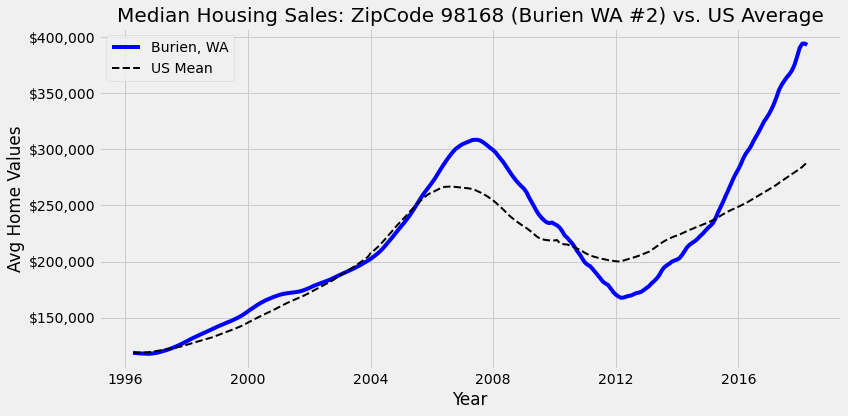

In [441]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(zip_98168_ts, label='Burien, WA', color='blue')


line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', ls='--',
                     color='black', linewidth=(2), label='US Mean');
ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("Median Housing Sales: ZipCode 98168 (Burien WA #2) vs. US Average", fontsize = 20)
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [253]:
#sarimax_param_search(zip_98168_ts)

In [254]:
#SARIMA Combos: ((1, 1, 1), (0, 1, 1, 12)) AIC: 3853.8875856880986
zip_98168_combo_1 = ((1, 1, 1), (0, 1, 1, 12))

In [255]:
combo= zip_98168_combo_1
combo

((1, 1, 1), (0, 1, 1, 12))

### Model #1

In [256]:
# Manually split data.
temp_ts = zip_98168_ts

SPLIT = int(temp_ts.shape[0]*0.80)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  212
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1450.847
Date:                            Sat, 21 May 2022   AIC                           2909.694
Time:                                    12:30:27   BIC                           2922.576
Sample:                                04-01-1996   HQIC                          2914.915
                                     - 11-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9410      0.025     37.320      0.000       0.892       0.990
ma.L1          0.1632      0.048      3.367      0.001       0.068       0.258
ma.S.L12      -0.4180      0.033    -12.680      0.000      -0.483      -0.353
sigma2      3.382e+05   2.16e+04     15.683      0.000    2.96e+05    3.81e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.54   Jarque-Bera (JB):               117.06
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):              11.64   Skew:                             0.28
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [257]:
zip_98168_model_1 = sarima_model

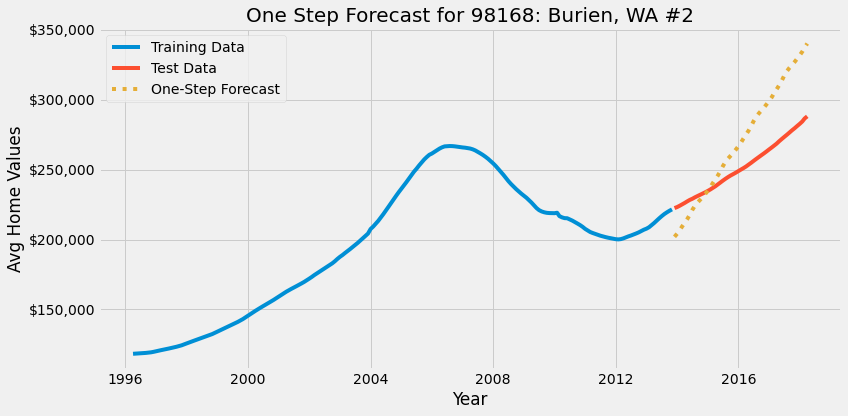

In [475]:
pred = zip_98168_model_1.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=True)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
#line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='black', label='US Mean');

ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("One Step Forecast for 98168: Burien, WA #2", fontsize = 20)
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [259]:
y_forecasted = pred.predicted_mean
y_truth = test['value']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 809682182.79
The Root Mean Squared Error is 28454.91


### Model #2

In [260]:
#sarimax_param_search(zip_98168_ts)

In [261]:
#SARIMA Combos: ((0, 2, 2), (1, 2, 2, 12)) AIC: 3499.2603303107535
zip_98168_combo_2 = ((0, 2, 2), (1, 2, 2, 12))

In [262]:
combo = zip_98168_combo_2
combo

((0, 2, 2), (1, 2, 2, 12))

In [263]:
# Manually split data.
temp_ts = zip_98168_ts

SPLIT = int(temp_ts.shape[0]*0.80)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  212
Model:             SARIMAX(0, 2, 2)x(1, 2, 2, 12)   Log Likelihood               -1262.835
Date:                            Sat, 21 May 2022   AIC                           2537.669
Time:                                    12:30:32   BIC                           2556.083
Sample:                                04-01-1996   HQIC                          2545.147
                                     - 11-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1044      0.044      2.377      0.017       0.018       0.191
ma.L2         -0.0411      0.049     -0.838      0.402      -0.137       0.055
ar.S.L12       0.2963      0.026     11.200      0.000       0.244       0.348
ma.S.L12      -1.9371      0.745     -2.600      0.009      -3.397      -0.477
ma.S.L24       0.9855      0.751      1.312      0.189      -0.486       2.457
sigma2       2.97e+05   2.23e+05      1.333      0.183    -1.4e+05    7.34e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                44.67
Prob(Q):                              0.72   Prob(JB):                         0.00
Heteroskedasticity (H):              16.65   Skew:                             0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [264]:
zip_98168_model_2 = sarima_model

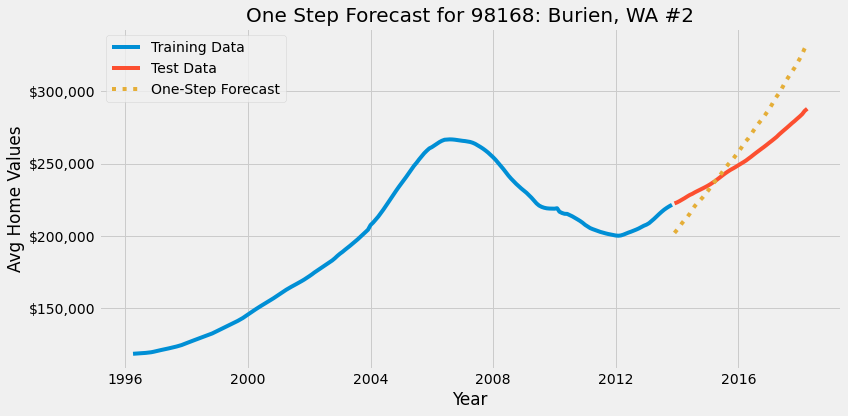

In [476]:
pred = zip_98168_model_2.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=True)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
#line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='black', label='US Mean');

ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("One Step Forecast for 98168: Burien, WA #2", fontsize = 20)
ax.legend()
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [266]:
y_forecasted = pred.predicted_mean
y_truth = test['value']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 1282920819.61
The Root Mean Squared Error is 35817.88


### Decision:
- Model 1 has a lower RMSE and will be used for forecasting.

### Prediction

In [267]:
combo = zip_98168_combo_1
#combo = zip_98168_combo_2
combo

((1, 1, 1), (0, 1, 1, 12))

In [268]:
# Running model again with FULL data

sarima_model = SARIMAX(
    zip_98168_ts,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1922.944
Date:                            Sat, 21 May 2022   AIC                           3853.888
Time:                                    12:30:33   BIC                           3867.777
Sample:                                04-01-1996   HQIC                          3859.485
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8779      0.032     27.687      0.000       0.816       0.940
ma.L1          0.4338      0.038     11.534      0.000       0.360       0.507
ma.S.L12      -0.4225      0.032    -13.139      0.000      -0.485      -0.359
sigma2       5.41e+05   3.37e+04     16.055      0.000    4.75e+05    6.07e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               225.76
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               7.39   Skew:                            -0.53
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [269]:
zip_98168_model_full = sarima_model

In [270]:
zip_98168_ts.tail(1)

value
time                 
2018-04-01 393,300.00

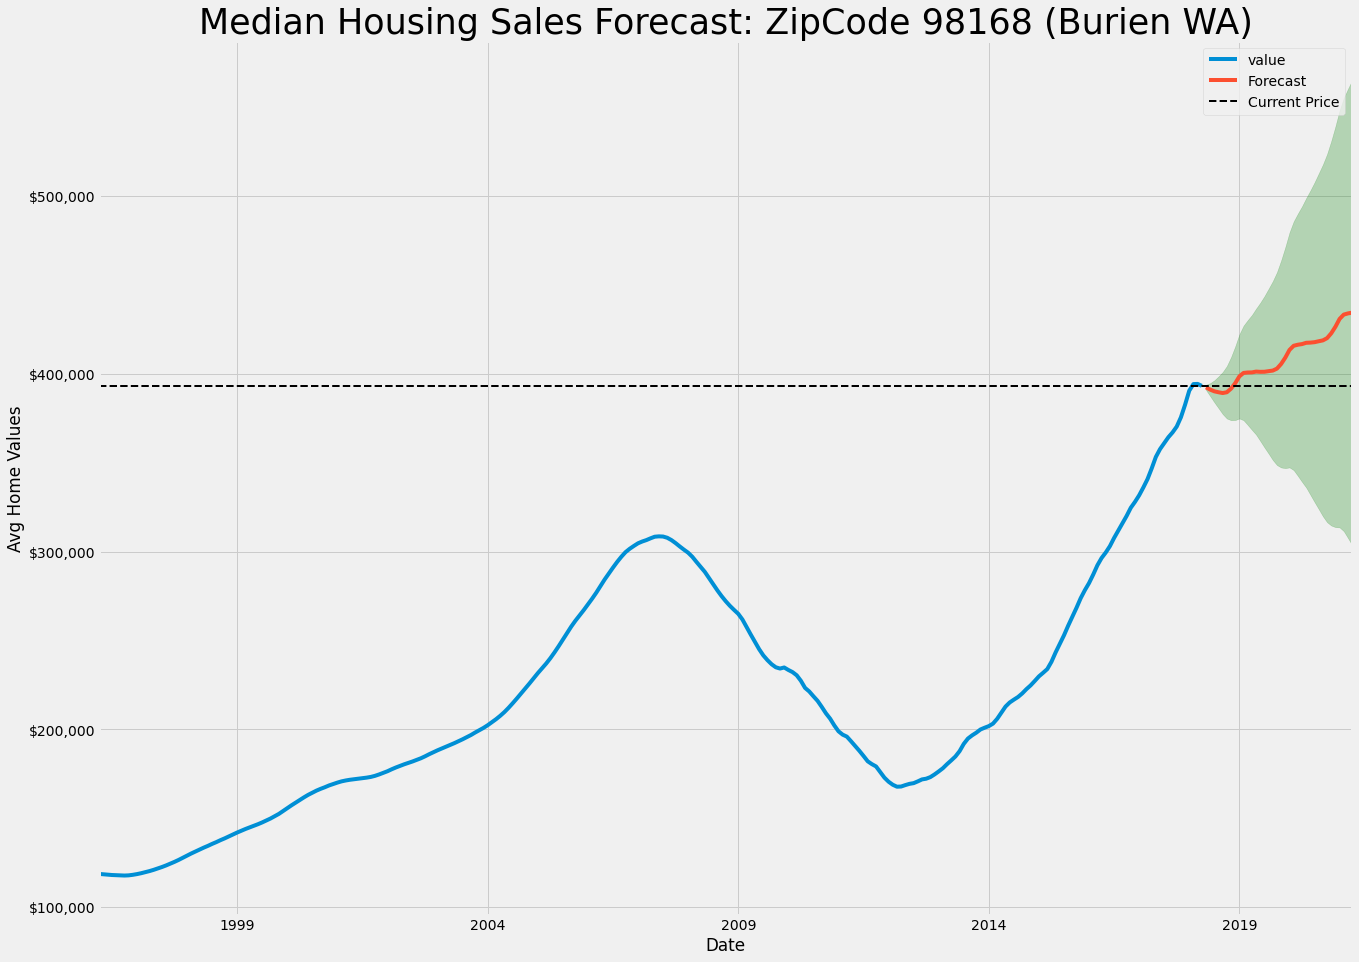

In [271]:
# Get forecast 3 yrs ahead in future (36 steps)
prediction = zip_98168_model_full.get_forecast(steps=36)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals
ax = zip_98168_ts['1996-01':].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='green', alpha=0.25)

ax.axhline(393300, ls='--', color='black', linewidth=(2), label='Current Price')

ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Values')
ax.set_title("Median Housing Sales Forecast: ZipCode 98168 (Burien WA)", fontsize = 35)
ax.yaxis.set_major_formatter(tick) 

plt.legend()
plt.show()

### Analysis: 
- the confidence window is too wide and is spread close to the current price. I do not recommend investing in this Zip Code.

## <b><u>80204 Denver CO </b></u>

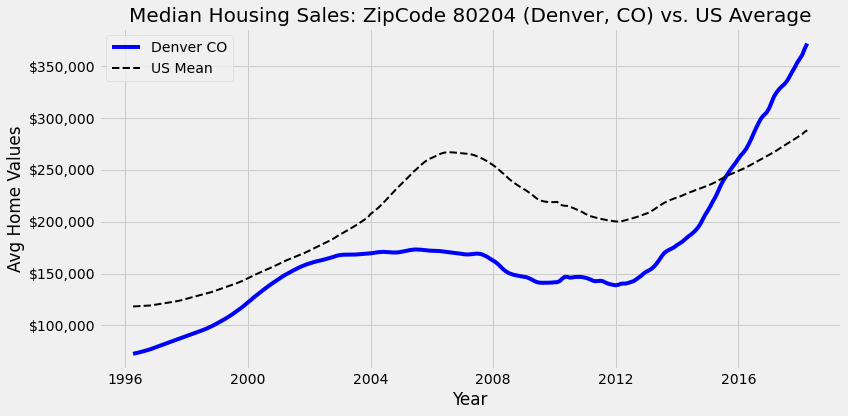

In [442]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(zip_80204_ts, label='Denver CO', color='blue')

line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', ls='--',
                     color='black', linewidth=(2), label='US Mean');

ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("Median Housing Sales: ZipCode 80204 (Denver, CO) vs. US Average", fontsize = 20)
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [275]:
#sarimax_param_search(zip_80204_ts)

In [276]:
#SARIMA Combos: ((1, 1, 1), (1, 1, 1, 12)) AIC: 3579.819829788861
zip_80204_combo_1 = ((1, 1, 1), (1, 1, 1, 12))

### Model #1

In [277]:
combo = zip_80204_combo_1
combo

((1, 1, 1), (1, 1, 1, 12))

In [278]:
# Manually split data.
temp_ts = zip_80204_ts

SPLIT = int(temp_ts.shape[0]*0.8)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  212
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1326.153
Date:                            Sat, 21 May 2022   AIC                           2662.307
Time:                                    12:36:40   BIC                           2678.409
Sample:                                04-01-1996   HQIC                          2668.833
                                     - 11-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9167      0.026     35.390      0.000       0.866       0.967
ma.L1          0.6154      0.042     14.824      0.000       0.534       0.697
ar.S.L12       0.0415      0.020      2.094      0.036       0.003       0.080
ma.S.L12      -0.9960      1.012     -0.984      0.325      -2.980       0.988
sigma2      7.961e+04   8.07e+04      0.986      0.324   -7.86e+04    2.38e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.26   Jarque-Bera (JB):                98.02
Prob(Q):                              0.61   Prob(JB):                         0.00
Heteroskedasticity (H):              10.25   Skew:                             0.29
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [279]:
zip_80204_model_1 = sarima_model

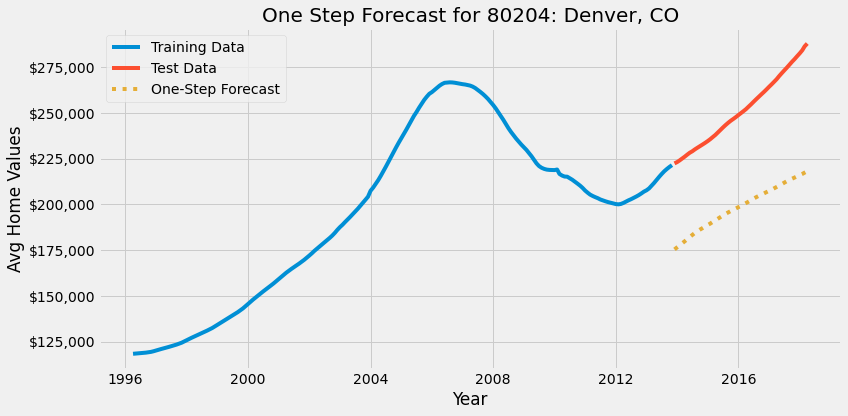

In [477]:
pred = zip_80204_model_1.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=False)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
#line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='black', label='US Mean');
ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("One Step Forecast for 80204: Denver, CO", fontsize = 20)
ax.legend()

ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [281]:
y_forecasted = pred.predicted_mean
y_truth = test['value']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 6851819866.21
The Root Mean Squared Error is 82775.72


#### Decision: Changing Train Test Split

### Model #1.5 (different Train_Test_Split)

In [282]:
combo = zip_80204_combo_1
combo

((1, 1, 1), (1, 1, 1, 12))

In [283]:
# Manually split data.
temp_ts = zip_80204_ts

SPLIT = int(temp_ts.shape[0]*0.85)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  225
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1433.605
Date:                            Sat, 21 May 2022   AIC                           2877.211
Time:                                    12:36:41   BIC                           2893.652
Sample:                                04-01-1996   HQIC                          2883.866
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9355      0.021     44.384      0.000       0.894       0.977
ma.L1          0.6188      0.042     14.624      0.000       0.536       0.702
ar.S.L12       0.0440      0.021      2.051      0.040       0.002       0.086
ma.S.L12      -0.9935      0.684     -1.451      0.147      -2.335       0.348
sigma2      9.221e+04   6.29e+04      1.467      0.142    -3.1e+04    2.15e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                60.27
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):              11.11   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [284]:
zip_80204_model_1_5 = sarima_model

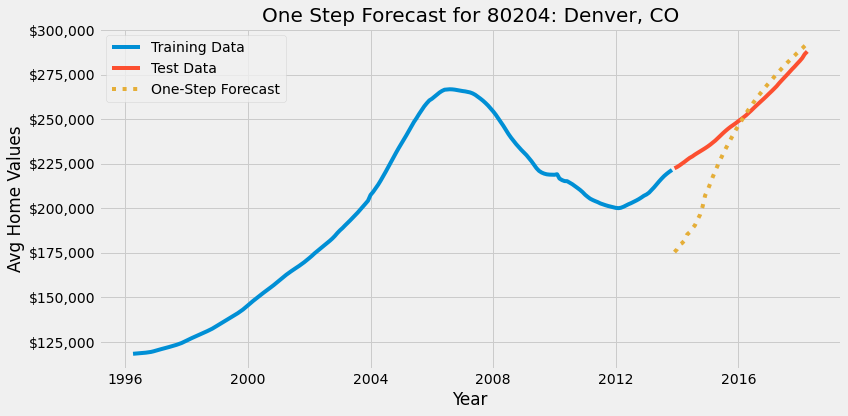

In [478]:
pred = zip_80204_model_1_5.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=False)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
#line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='black', label='US Mean');
ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("One Step Forecast for 80204: Denver, CO", fontsize = 20)
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [286]:
y_forecasted = pred.predicted_mean
y_truth = test['value']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 1611073051.99
The Root Mean Squared Error is 40138.17


### Model #2

In [287]:
#sarimax_param_search(zip_80204_ts)

In [288]:
# SARIMA Combos: ((1, 2, 2), (2, 2, 2, 12)) AIC: 3270.679349948866
zip_80204_combo_2 = ((1, 2, 2), (2, 2, 2, 12))

In [289]:
combo = zip_80204_combo_2
combo

((1, 2, 2), (2, 2, 2, 12))

In [290]:
# Manually split data.
temp_ts = zip_80204_ts

SPLIT = int(temp_ts.shape[0]*0.85)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  225
Model:             SARIMAX(1, 2, 2)x(2, 2, 2, 12)   Log Likelihood               -1307.665
Date:                            Sat, 21 May 2022   AIC                           2631.329
Time:                                    12:36:48   BIC                           2656.509
Sample:                                04-01-1996   HQIC                          2641.545
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4353      0.170     -2.553      0.011      -0.769      -0.101
ma.L1          1.1774      0.163      7.203      0.000       0.857       1.498
ma.L2          0.4448      0.101      4.421      0.000       0.248       0.642
ar.S.L12      -0.0868      0.064     -1.354      0.176      -0.212       0.039
ar.S.L24       0.1593      0.049      3.240      0.001       0.063       0.256
ma.S.L12      -1.2285      0.098    -12.497      0.000      -1.421      -1.036
ma.S.L24       0.3226      0.108      2.978      0.003       0.110       0.535
sigma2      1.734e+05   1.79e+04      9.707      0.000    1.38e+05    2.08e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.57   Jarque-Bera (JB):                25.04
Prob(Q):                              0.21   Prob(JB):                         0.00
Heteroskedasticity (H):               9.83   Skew:                             0.16
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [291]:
zip_80204_model_2 = sarima_model

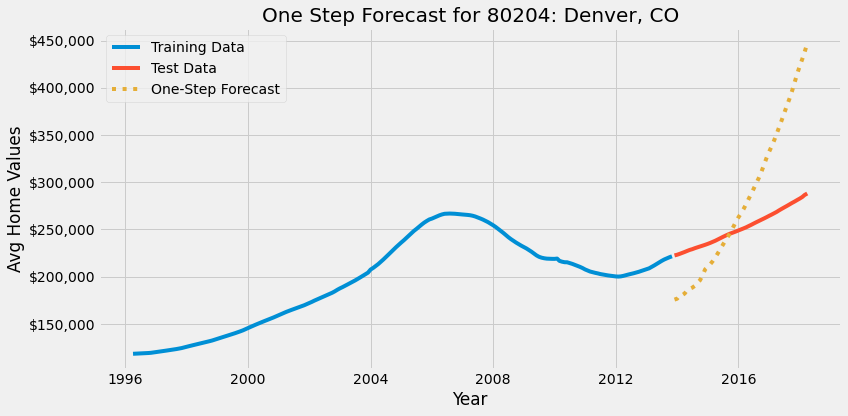

In [479]:
pred = zip_80204_model_2.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=False)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
#line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='black', label='US Mean');
ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("One Step Forecast for 80204: Denver, CO", fontsize = 20)
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [293]:
y_forecasted = pred.predicted_mean
y_truth = test['value']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 1043987906.65
The Root Mean Squared Error is 32310.8


### Decision:
-  Model 1.5 has a slightly better RMSE, and Model 2 seems to be overfit as it is predicting a straight increase. I will go with Model 1.5. 

### Prediction

In [294]:
combo = zip_80204_combo_1
#combo = zip_80204_combo_2
combo

((1, 1, 1), (1, 1, 1, 12))

In [295]:
# Model
sarima_model = SARIMAX(
    zip_80204_ts,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1784.910
Date:                            Sat, 21 May 2022   AIC                           3579.820
Time:                                    12:36:49   BIC                           3597.181
Sample:                                04-01-1996   HQIC                          3586.817
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9278      0.017     53.915      0.000       0.894       0.962
ma.L1          0.7078      0.030     23.751      0.000       0.649       0.766
ar.S.L12       0.0554      0.024      2.311      0.021       0.008       0.102
ma.S.L12      -0.9874      0.208     -4.748      0.000      -1.395      -0.580
sigma2      1.505e+05    3.1e+04      4.854      0.000    8.98e+04    2.11e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):                54.85
Prob(Q):                              0.79   Prob(JB):                         0.00
Heteroskedasticity (H):               8.10   Skew:                             0.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [296]:
zip_80204_model_full = sarima_model

In [297]:
zip_80204_ts.tail(1)

value
time                 
2018-04-01 371,600.00

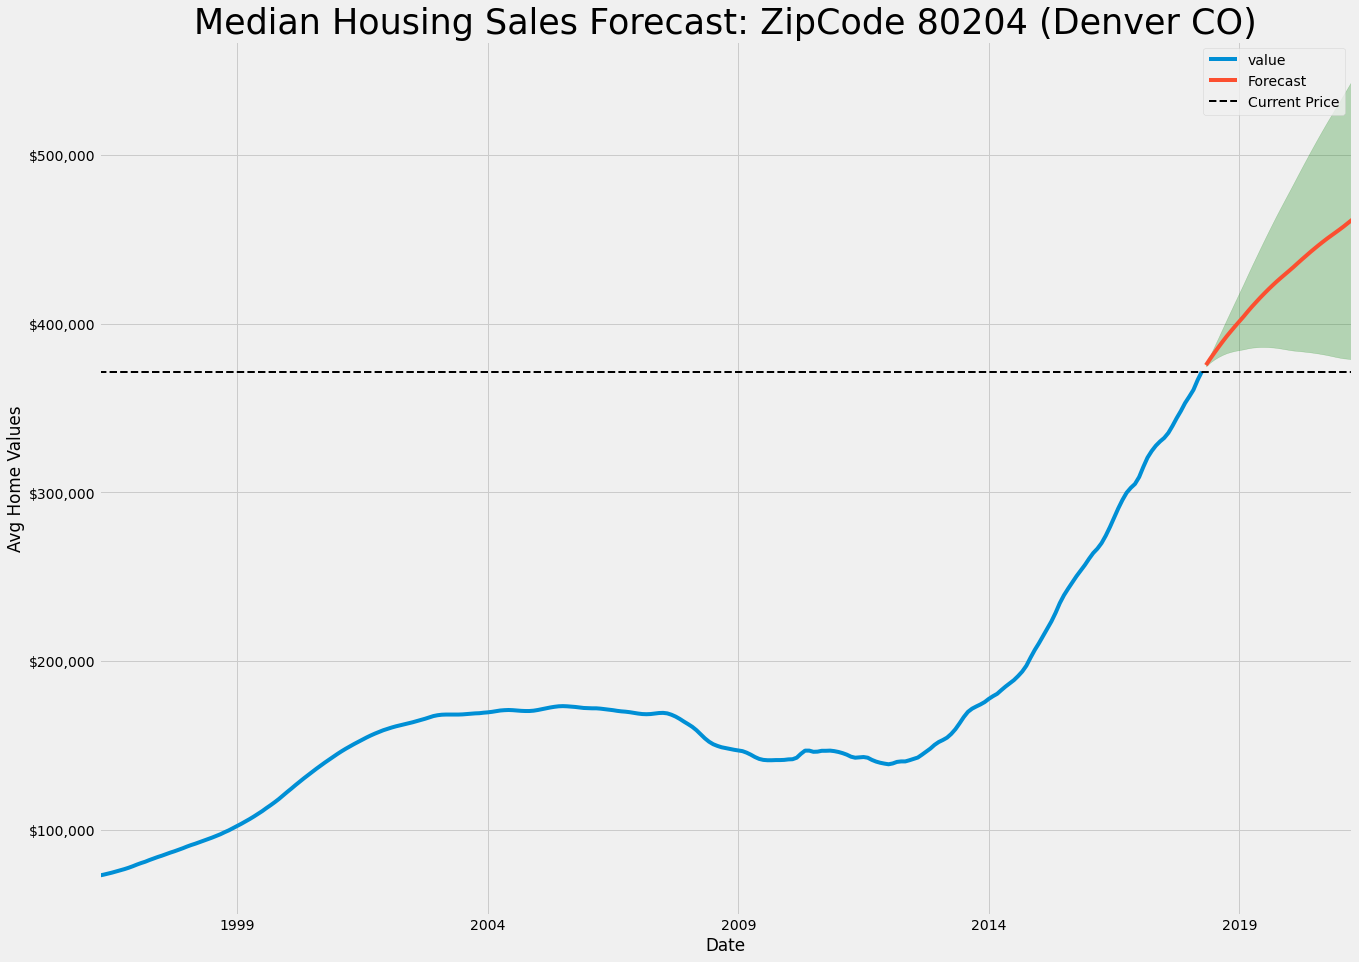

In [298]:
# Get forecast 3 yrs ahead in future (36 steps)
prediction = zip_80204_model_full.get_forecast(steps=36)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals
ax = zip_80204_ts['1996-01':].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='green', alpha=0.25)

ax.axhline(371600, ls='--', color='black', linewidth=(2), label='Current Price')

ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Values')
ax.set_title("Median Housing Sales Forecast: ZipCode 80204 (Denver CO)", fontsize = 35)
ax.yaxis.set_major_formatter(tick) 

plt.legend()
plt.show()

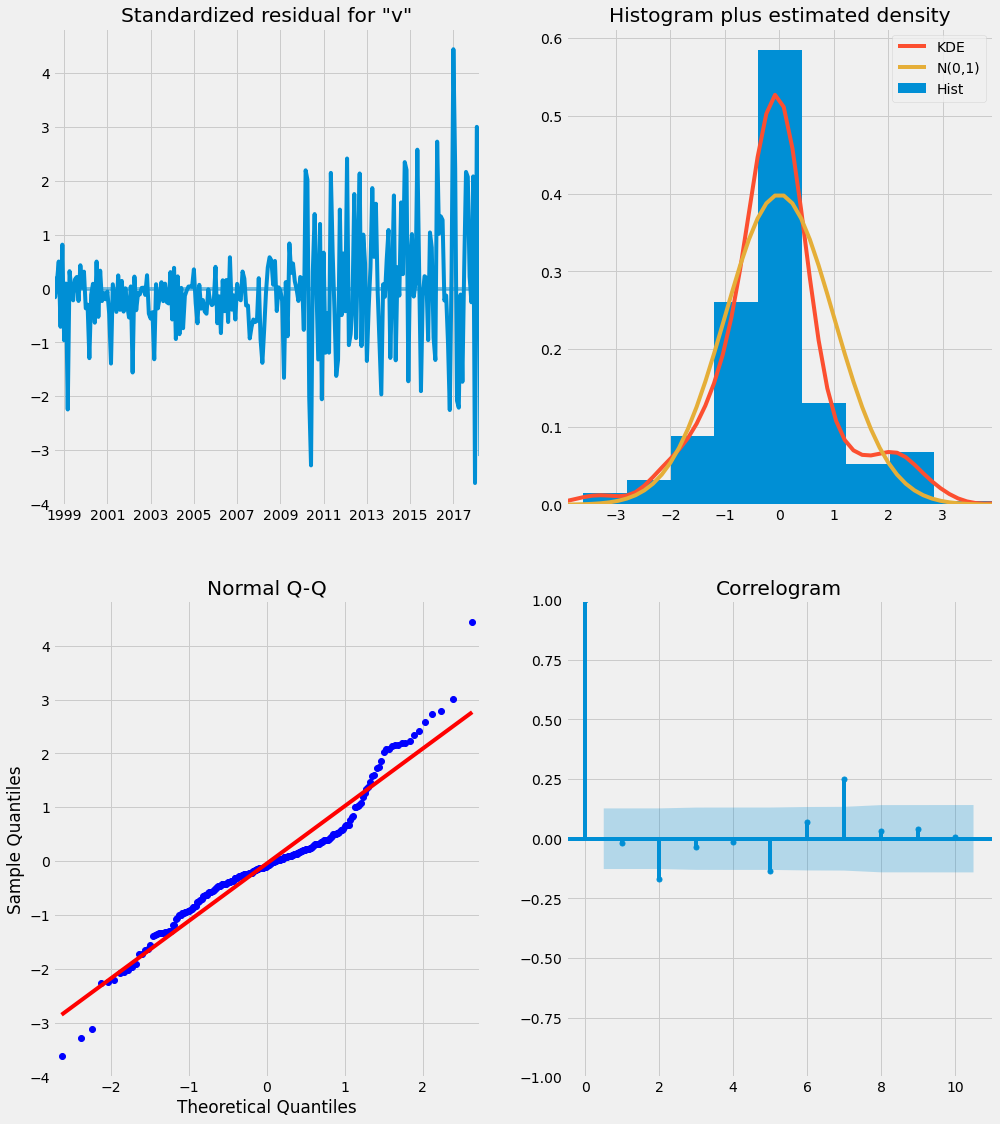

In [299]:
zip_80204_model_full.plot_diagnostics(figsize=(15, 18))
plt.show()

### Analysis:
- While this zip code is a little lower than the exact price range that I was given, it is a strong investmen, with even the lower confidence value making a slight profit. This gets a strong recommendation to invest in for the full 3 years.

### Metrics

In [300]:
zip_80204_ts.tail(1)

value
time                 
2018-04-01 371,600.00

In [301]:
analysis_df = pred_conf.resample('Y').mean()
analysis_df['mean'] = analysis_df.apply(lambda x: x.mean(), axis=1)

analysis_df['base'] = 371600
analysis_df['base'] = analysis_df['base'].astype(float)

In [302]:
analysis_df = analysis_df[['base', 'lower value', 'mean', 'upper value']]

analysis_df['Min_ROI'] = analysis_df.apply(lambda x: x['lower value'] - x['base'], axis=1)
analysis_df['Min_ROI%'] = analysis_df.apply(lambda x: x['Min_ROI'] / x['base'], axis=1)
analysis_df['Forecast_ROI'] = analysis_df.apply(lambda x: x['mean'] - x['base'], axis=1)
analysis_df['Forecast_ROI%'] = analysis_df.apply(lambda x: x['mean'] / x['base'], axis=1)
analysis_df['Max_ROI'] = analysis_df.apply(lambda x: x['upper value'] - x['base'], axis=1)
analysis_df['Max_ROI%'] = analysis_df.apply(lambda x: x['upper value'] / x['base'], axis=1)

In [303]:
zip_80204_metrics = analysis_df

## <b><u>07087 Union City NJ  </b></u>

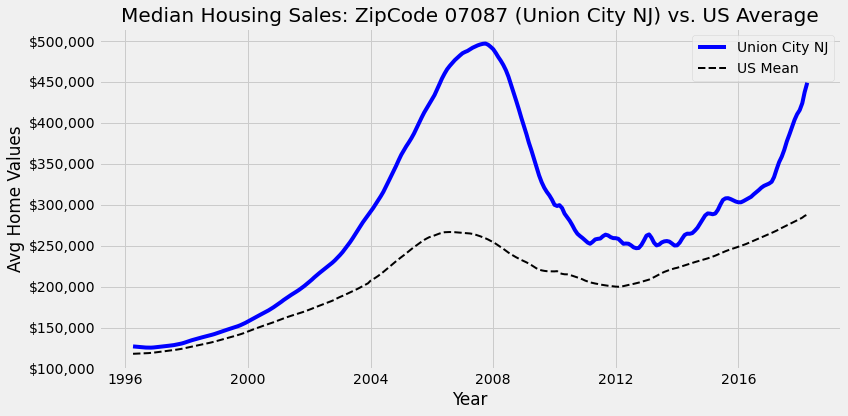

In [443]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(zip_07087_ts, label='Union City NJ', color='blue')

\
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', ls='--',
                     color='black', linewidth=(2), label='US Mean');

ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("Median Housing Sales: ZipCode 07087 (Union City NJ) vs. US Average", fontsize = 20)
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [305]:
#SARIMA Combos: ((1, 1, 1), (1, 1, 1, 12)) AIC: 4153.772501773967
zip_07087_combo_1 = ((1,1,1), (1,1,1,12))

### Model #1

In [306]:
combo = zip_07087_combo_1
combo

((1, 1, 1), (1, 1, 1, 12))

In [307]:
# Manually split data.
temp_ts = zip_07087_ts

SPLIT = int(temp_ts.shape[0]*0.8)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  212
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1584.993
Date:                            Sat, 21 May 2022   AIC                           3179.986
Time:                                    12:36:50   BIC                           3196.088
Sample:                                04-01-1996   HQIC                          3186.512
                                     - 11-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8630      0.043     20.172      0.000       0.779       0.947
ma.L1          0.6437      0.048     13.547      0.000       0.551       0.737
ar.S.L12       0.1807      0.087      2.069      0.039       0.009       0.352
ma.S.L12      -0.4898      0.070     -7.020      0.000      -0.627      -0.353
sigma2      1.852e+06   1.25e+05     14.865      0.000    1.61e+06     2.1e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.51   Jarque-Bera (JB):               329.34
Prob(Q):                              0.47   Prob(JB):                         0.00
Heteroskedasticity (H):              15.27   Skew:                             1.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [308]:
zip_07087_model_1 = sarima_model

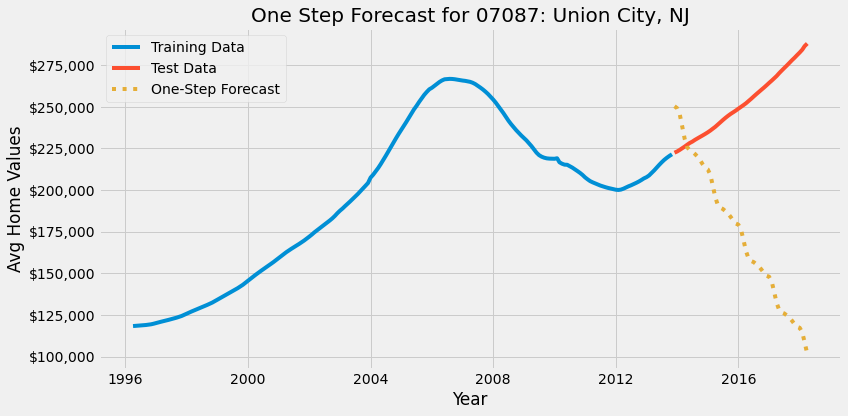

In [480]:
pred = zip_07087_model_1.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=False)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
#line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='black', label='US Mean');
ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("One Step Forecast for 07087: Union City, NJ", fontsize = 20)
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

### Analysis:
- It is not surprising that the one-step forecast continues to drop so much due to the downward trend of the training data. As I know that the price did go up, I am going to modify my train_test_split to 90% so that the model can get some of the increasing trend. 
- I will need to make sure that it isn't overfitting though.

In [310]:
y_forecasted = pred.predicted_mean
y_truth = test['value']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 29128557428.9
The Root Mean Squared Error is 170670.9


### Model 1.5 (with new train-test split)

In [311]:
combo = zip_07087_combo_1
combo

((1, 1, 1), (1, 1, 1, 12))

In [312]:
# Manually split data.
temp_ts = zip_07087_ts

SPLIT = int(temp_ts.shape[0]*0.9)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  238
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1829.401
Date:                            Sat, 21 May 2022   AIC                           3668.801
Time:                                    12:36:50   BIC                           3685.560
Sample:                                04-01-1996   HQIC                          3675.575
                                     - 01-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8345      0.041     20.194      0.000       0.753       0.915
ma.L1          0.6587      0.047     14.106      0.000       0.567       0.750
ar.S.L12       0.1982      0.063      3.127      0.002       0.074       0.322
ma.S.L12      -0.5505      0.048    -11.373      0.000      -0.645      -0.456
sigma2      2.099e+06   1.54e+05     13.670      0.000     1.8e+06     2.4e+06
===================================================================================
Ljung-Box (L1) (Q):                   3.32   Jarque-Bera (JB):               144.67
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               9.62   Skew:                             0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.86
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [313]:
zip_07087_model_1_5 = sarima_model

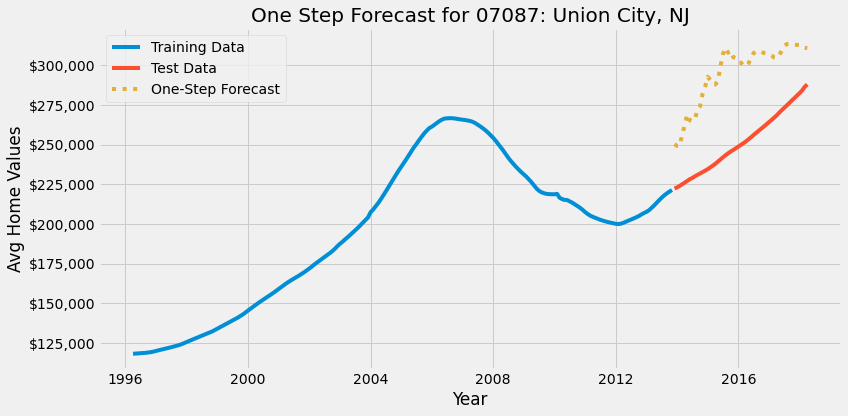

In [481]:
pred = zip_07087_model_1_5.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=False)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
#line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='black', label='US Mean');
ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("One Step Forecast for 07087: Union City, NJ", fontsize = 20)
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

- As expected, the one step forecast has evened out a bit.

In [315]:
y_forecasted = pred.predicted_mean
y_truth = test['value']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 3820762507.36
The Root Mean Squared Error is 61812.32


### Model #2

In [316]:
#SARIMA Combos: ((1, 1, 2), (1, 2, 2, 12)) AIC: 3771.3550338175914
zip_07087_combo_2 = ((1, 1, 2), (1, 2, 2, 12))

In [317]:
combo = zip_07087_combo_2 
combo

((1, 1, 2), (1, 2, 2, 12))

In [318]:
# Manually split data.
temp_ts = zip_07087_ts

SPLIT = int(temp_ts.shape[0]*0.90)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  238
Model:             SARIMAX(1, 1, 2)x(1, 2, 2, 12)   Log Likelihood               -1638.292
Date:                            Sat, 21 May 2022   AIC                           3290.584
Time:                                    12:36:56   BIC                           3313.164
Sample:                                04-01-1996   HQIC                          3299.734
                                     - 01-01-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5706      0.072      7.874      0.000       0.429       0.713
ma.L1          1.2943      0.060     21.563      0.000       1.177       1.412
ma.L2          0.6085      0.052     11.613      0.000       0.506       0.711
ar.S.L12       0.1514      0.042      3.582      0.000       0.069       0.234
ma.S.L12      -1.2616      0.067    -18.726      0.000      -1.394      -1.130
ma.S.L24       0.3513      0.059      5.991      0.000       0.236       0.466
sigma2      2.286e+06   2.04e+05     11.203      0.000    1.89e+06    2.69e+06
===================================================================================
Ljung-Box (L1) (Q):                   2.27   Jarque-Bera (JB):                72.48
Prob(Q):                              0.13   Prob(JB):                         0.00
Heteroskedasticity (H):               4.49   Skew:                             0.86
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [319]:
zip_07087_model_2 = sarima_model

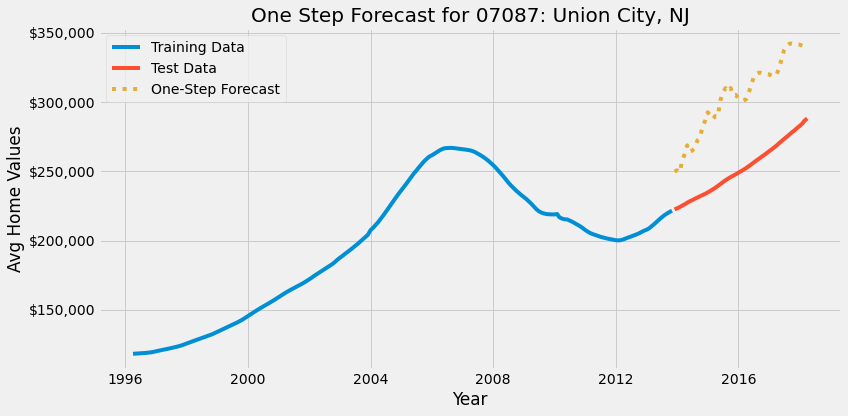

In [482]:
pred = zip_07087_model_2.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=False)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')

#line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='black', label='US Mean');
ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("One Step Forecast for 07087: Union City, NJ", fontsize = 20)

        
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [321]:
y_forecasted = pred.predicted_mean
y_truth = test['value']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 1912316377.95
The Root Mean Squared Error is 43730.04


### Decision:
- Model 2 has a lower RSME and doesn't appear to be overfit, so I will use it for my forecast.

### Prediction

In [322]:
#combo = zip_07087_combo_1
combo = zip_07087_combo_2
combo

((1, 1, 2), (1, 2, 2, 12))

In [323]:
# Running model again with FULL data

sarima_model = SARIMAX(
    zip_07087_ts,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 1, 2)x(1, 2, 2, 12)   Log Likelihood               -1878.678
Date:                            Sat, 21 May 2022   AIC                           3771.355
Time:                                    12:37:03   BIC                           3794.884
Sample:                                04-01-1996   HQIC                          3780.864
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5457      0.070      7.850      0.000       0.409       0.682
ma.L1          1.3168      0.057     23.206      0.000       1.206       1.428
ma.L2          0.6283      0.050     12.505      0.000       0.530       0.727
ar.S.L12       0.1490      0.041      3.663      0.000       0.069       0.229
ma.S.L12      -1.2606      0.066    -19.079      0.000      -1.390      -1.131
ma.S.L24       0.3543      0.059      5.998      0.000       0.239       0.470
sigma2      2.392e+06   2.04e+05     11.749      0.000    1.99e+06    2.79e+06
===================================================================================
Ljung-Box (L1) (Q):                   2.14   Jarque-Bera (JB):                47.60
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):               3.76   Skew:                             0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [324]:
zip_07087_model_full = sarima_model

In [325]:
zip_07087_ts.tail(1)

value
time                 
2018-04-01 448,900.00

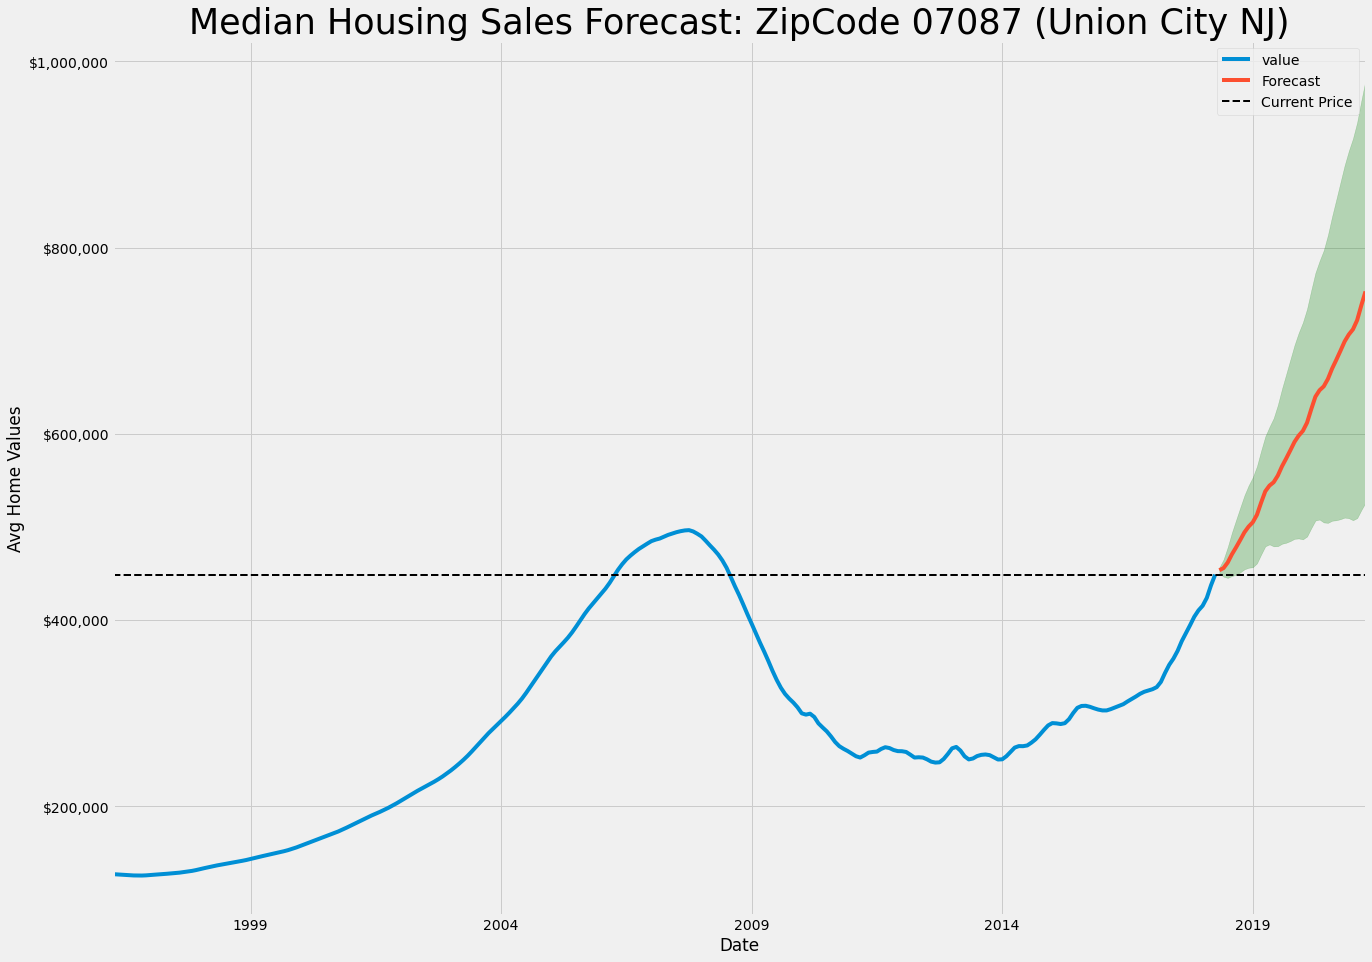

In [326]:
# Get forecast 3 yrs ahead in future (36 steps)
prediction = zip_07087_model_full.get_forecast(steps=36)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals
ax = zip_07087_ts['1996-01':].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='green', alpha=0.25)

ax.axhline(448900, ls='--', color='black', linewidth=(2), label='Current Price')

ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Values')
ax.set_title("Median Housing Sales Forecast: ZipCode 07087 (Union City NJ)", fontsize = 35)
ax.yaxis.set_major_formatter(tick) 

plt.legend()
plt.show()

### Analysis: 
- minimial losses are in the forecast window, with the potential for high gains.
- RECOMMENDED!

In [327]:
print('Forecast Values')
print(prediction.predicted_mean.resample('Y').mean())
print('----------------------------------')
print('Confidence Index')
print(pred_conf.resample('Y').mean())

Forecast Values
2018-12-31   475,146.70
2019-12-31   553,457.43
2020-12-31   656,978.95
2021-12-31   731,392.17
Freq: A-DEC, Name: predicted_mean, dtype: float64
----------------------------------
Confidence Index
            lower value  upper value
2018-12-31   450,172.27   500,121.13
2019-12-31   477,799.93   629,114.93
2020-12-31   503,549.54   810,408.37
2021-12-31   515,409.16   947,375.18


### Metrics

In [328]:
zip_07087_ts.tail(1)

value
time                 
2018-04-01 448,900.00

In [329]:
analysis_df = pred_conf.resample('Y').mean()
analysis_df['mean'] = analysis_df.apply(lambda x: x.mean(), axis=1)

analysis_df['base'] = 448900
analysis_df['base'] = analysis_df['base'].astype(float)

In [330]:
analysis_df = analysis_df[['base', 'lower value', 'mean', 'upper value']]

analysis_df['Min_ROI'] = analysis_df.apply(lambda x: x['lower value'] - x['base'], axis=1)
analysis_df['Min_ROI%'] = analysis_df.apply(lambda x: x['Min_ROI'] / x['base'], axis=1)
analysis_df['Forecast_ROI'] = analysis_df.apply(lambda x: x['mean'] - x['base'], axis=1)
analysis_df['Forecast_ROI%'] = analysis_df.apply(lambda x: x['mean'] / x['base'], axis=1)
analysis_df['Max_ROI'] = analysis_df.apply(lambda x: x['upper value'] - x['base'], axis=1)
analysis_df['Max_ROI%'] = analysis_df.apply(lambda x: x['upper value'] / x['base'], axis=1)

In [331]:
analysis_df

base  lower value       mean  upper value   Min_ROI  \
2018-12-31 448,900.00   450,172.27 475,146.70   500,121.13  1,272.27   
2019-12-31 448,900.00   477,799.93 553,457.43   629,114.93 28,899.93   
2020-12-31 448,900.00   503,549.54 656,978.95   810,408.37 54,649.54   
2021-12-31 448,900.00   515,409.16 731,392.17   947,375.18 66,509.16   

            Min_ROI%  Forecast_ROI  Forecast_ROI%    Max_ROI  Max_ROI%  
2018-12-31      0.00     26,246.70           1.06  51,221.13      1.11  
2019-12-31      0.06    104,557.43           1.23 180,214.93      1.40  
2020-12-31      0.12    208,078.95           1.46 361,508.37      1.81  
2021-12-31      0.15    282,492.17           1.63 498,475.18      2.11

In [332]:
zip_07087_metrics = analysis_df

## <b><u>90304: Inglewood CA </b></u>

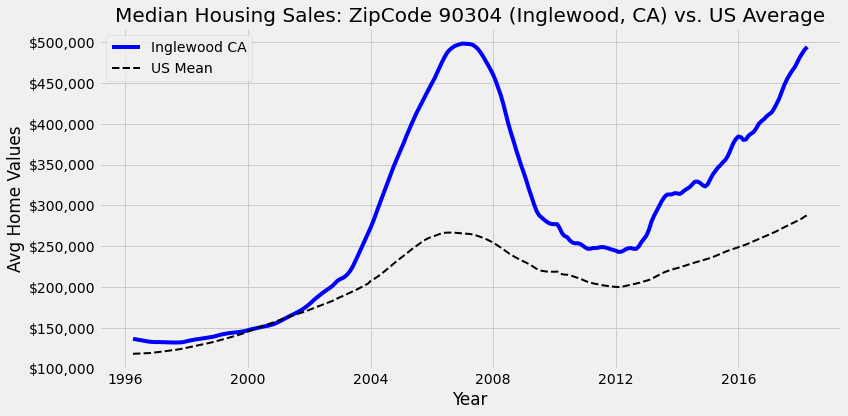

In [444]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(zip_90304_ts, label='Inglewood CA', color='blue')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', ls='--',
                     color='black', linewidth=(2), label='US Mean');

ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("Median Housing Sales: ZipCode 90304 (Inglewood, CA) vs. US Average", fontsize = 20)
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [334]:
#SARIMA Combos: ((1, 1, 1), (1, 1, 1, 12)) AIC: 4153.772501773967
zip_90304_combo_1 = ((1, 1, 1), (1, 1, 1, 12))

In [335]:
#SARIMA Combos: ((2, 2, 2), (0, 2, 2, 12)) AIC: 3738.2085627898796
zip_90304_combo_2 = ((2, 2, 2), (0, 2, 2, 12))

### Model #1

In [336]:
combo = zip_90304_combo_1
combo

((1, 1, 1), (1, 1, 1, 12))

In [337]:
# Manually split data.
temp_ts = zip_90304_ts

SPLIT = int(temp_ts.shape[0]*0.80)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  212
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1550.936
Date:                            Sat, 21 May 2022   AIC                           3111.872
Time:                                    12:37:04   BIC                           3127.974
Sample:                                04-01-1996   HQIC                          3118.397
                                     - 11-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9327      0.036     26.076      0.000       0.863       1.003
ma.L1          0.6061      0.056     10.838      0.000       0.496       0.716
ar.S.L12       0.1775      0.110      1.607      0.108      -0.039       0.394
ma.S.L12      -0.5168      0.088     -5.899      0.000      -0.688      -0.345
sigma2      1.345e+06   1.19e+05     11.288      0.000    1.11e+06    1.58e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):               258.39
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               9.01   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [338]:
zip_90304_model_1 = sarima_model

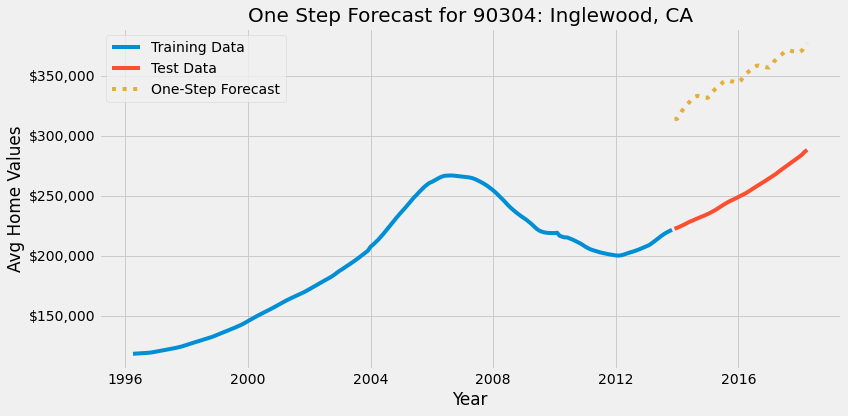

In [483]:
pred = zip_90304_model_1.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=False)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
#line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='black', label='US Mean');
ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("One Step Forecast for 90304: Inglewood, CA", fontsize = 20)
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [340]:
y_forecasted = pred.predicted_mean
y_truth = test['value']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 2802962940.02
The Root Mean Squared Error is 52943.02


### Model #2

In [341]:
#SARIMA Combos: ((2, 2, 2), (0, 2, 2, 12)) AIC: 3738.2085627898796
zip_90304_combo_2 = ((2, 2, 2), (0, 2, 2, 12))

In [342]:
combo = zip_90304_combo_2
combo

((2, 2, 2), (0, 2, 2, 12))

In [343]:
# Manually split data.
temp_ts = zip_90304_ts

SPLIT = int(temp_ts.shape[0]*0.80)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  212
Model:             SARIMAX(2, 2, 2)x(0, 2, 2, 12)   Log Likelihood               -1354.020
Date:                            Sat, 21 May 2022   AIC                           2722.041
Time:                                    12:37:09   BIC                           2743.523
Sample:                                04-01-1996   HQIC                          2730.765
                                     - 11-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8043      0.058    -13.902      0.000      -0.918      -0.691
ar.L2         -0.3452      0.040     -8.718      0.000      -0.423      -0.268
ma.L1          1.7510      0.061     28.622      0.000       1.631       1.871
ma.L2          1.0338      0.076     13.565      0.000       0.884       1.183
ma.S.L12      -1.1472      0.098    -11.749      0.000      -1.339      -0.956
ma.S.L24       0.0970      0.043      2.267      0.023       0.013       0.181
sigma2      8.613e+05   8.45e-08   1.02e+13      0.000    8.61e+05    8.61e+05
===================================================================================
Ljung-Box (L1) (Q):                   1.27   Jarque-Bera (JB):               482.11
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):               5.33   Skew:                             0.13
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.32e+28. Standard errors may be unstable.
"""

In [344]:
zip_90304_model_2 = sarima_model

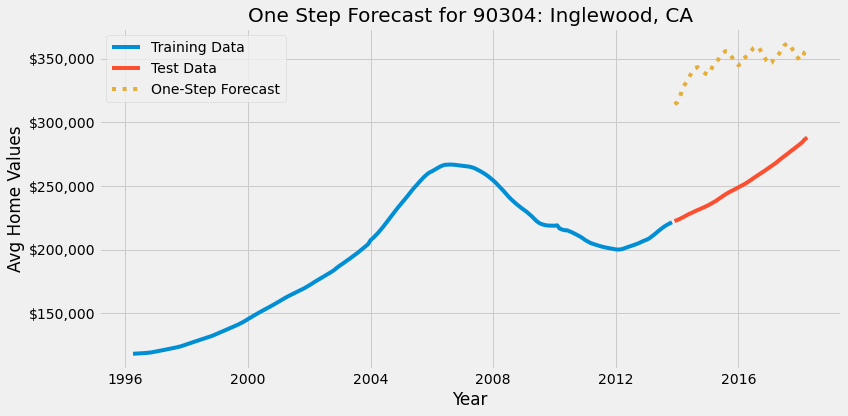

In [484]:
pred = zip_90304_model_2.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=False)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
#line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='black', label='US Mean');
ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("One Step Forecast for 90304: Inglewood, CA", fontsize = 20)
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [346]:
y_forecasted = pred.predicted_mean
y_truth = test['value']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 3669561267.0
The Root Mean Squared Error is 60576.9


### Prediction

-  Model 1 has aslightly lower RMSE and better models the test data, so I will use that one for my predictions.

In [347]:
combo = zip_90304_combo_1
#combo = zip_90304_combo_2
combo

((1, 1, 1), (1, 1, 1, 12))

In [348]:
# Running model again with FULL data

sarima_model = SARIMAX(
    zip_90304_ts,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2065.138
Date:                            Sat, 21 May 2022   AIC                           4140.276
Time:                                    12:37:10   BIC                           4157.637
Sample:                                04-01-1996   HQIC                          4147.272
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9149      0.031     29.201      0.000       0.853       0.976
ma.L1          0.3350      0.027     12.426      0.000       0.282       0.388
ar.S.L12      -0.4683      0.063     -7.447      0.000      -0.592      -0.345
ma.S.L12      -0.0416      0.038     -1.086      0.277      -0.117       0.033
sigma2      2.319e+06    1.9e+05     12.184      0.000    1.95e+06    2.69e+06
===================================================================================
Ljung-Box (L1) (Q):                   6.10   Jarque-Bera (JB):                46.21
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               8.46   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [349]:
zip_90304_model_full = sarima_model

In [350]:
zip_90304_ts.tail(1)

value
time                 
2018-04-01 494,300.00

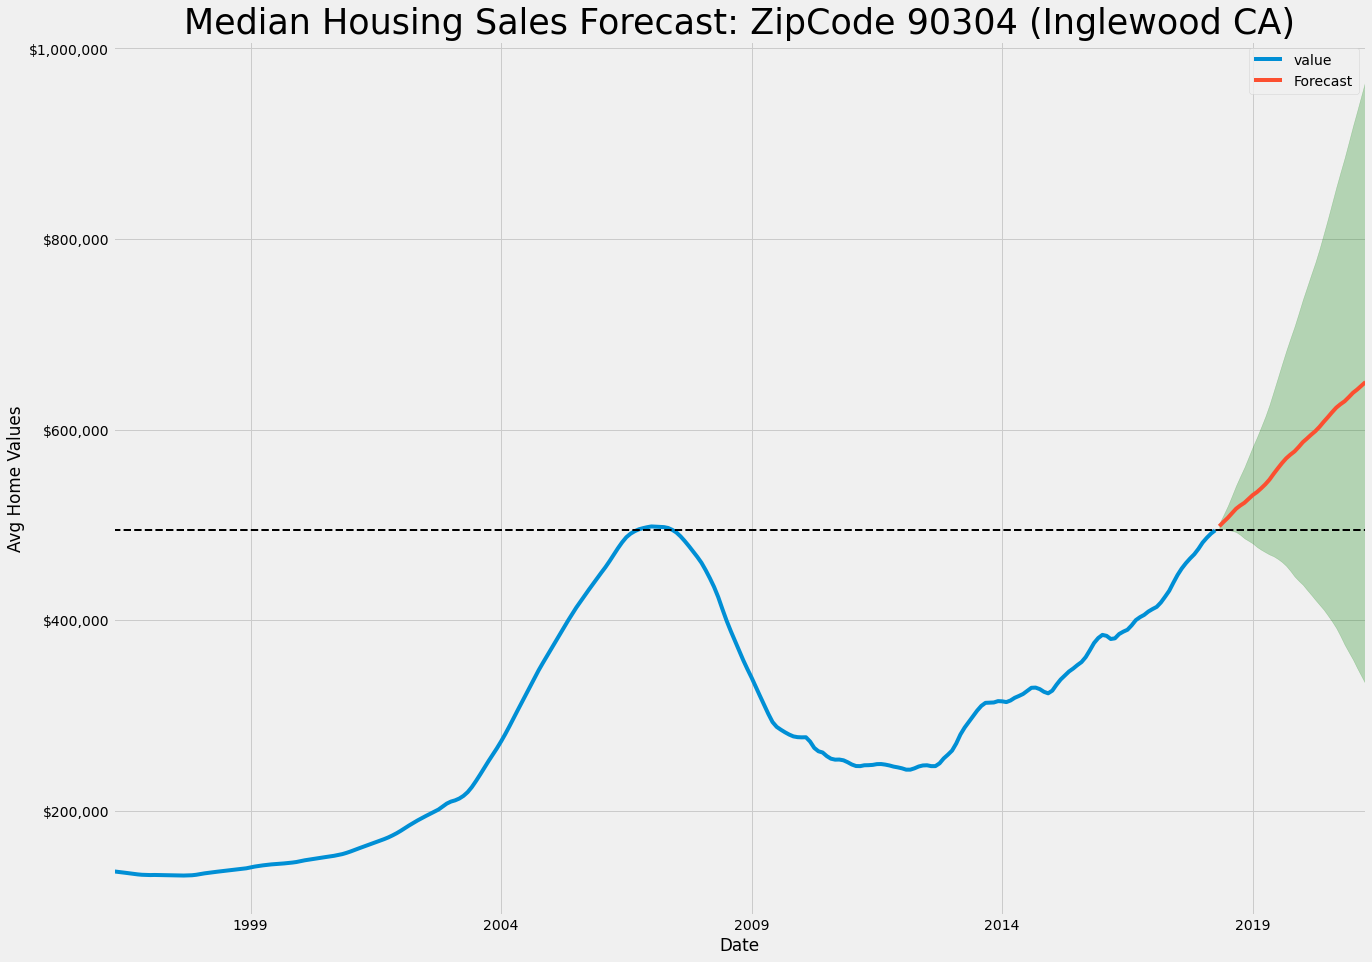

In [351]:
# Get forecast 3 yrs ahead in future (36 steps)
prediction = zip_90304_model_full.get_forecast(steps=36)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals
ax = zip_90304_ts['1996-01':].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='green', alpha=0.25)

ax.axhline(494300, ls='--', color='black', linewidth=(2))

ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Values')
ax.set_title("Median Housing Sales Forecast: ZipCode 90304 (Inglewood CA)", fontsize = 35)
ax.yaxis.set_major_formatter(tick) 

plt.legend()
plt.show()

### Analysis:
- The lower confidence level  predicts a loss, so I do not recommend investing in this zip code.
- That said, most of the confidence index is above the current value, so if the company is okay with taking on a little more risk, this would be a good investment with high potential for large ROI.

## <b><u>95918: Brown's Valley CA </b></u>

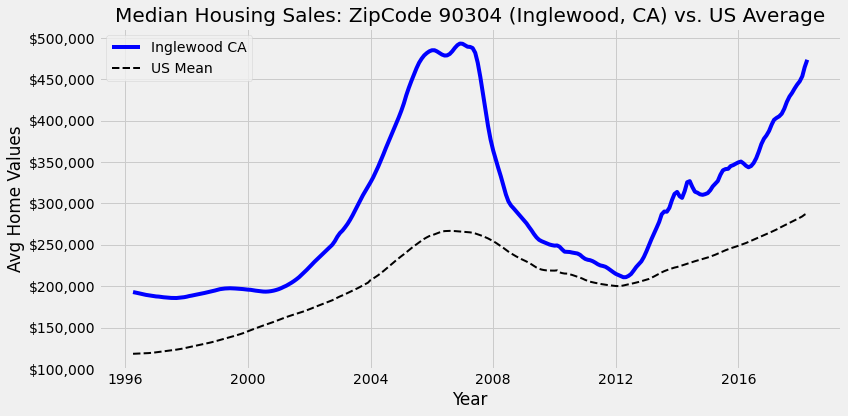

In [445]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(zip_95918_ts, label='Inglewood CA', color='blue')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', ls='--',
                     color='black', linewidth=(2), label='US Mean');

ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("Median Housing Sales: ZipCode 90304 (Inglewood, CA) vs. US Average", fontsize = 20)
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [354]:
#SARIMA Combos: ((1, 1, 1), (1, 1, 1, 12)) AIC: 4153.772501773967
zip_95918_combo_1 = ((1, 1, 1), (1, 1, 1, 12))

### Model #1

In [355]:
combo = zip_95918_combo_1
combo

((1, 1, 1), (1, 1, 1, 12))

In [356]:
# Manually split data.
temp_ts = zip_95918_ts

SPLIT = int(temp_ts.shape[0]*0.80)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  212
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1666.400
Date:                            Sat, 21 May 2022   AIC                           3342.800
Time:                                    12:37:11   BIC                           3358.901
Sample:                                04-01-1996   HQIC                          3349.325
                                     - 11-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9467      0.027     35.606      0.000       0.895       0.999
ma.L1          0.0347      0.032      1.101      0.271      -0.027       0.097
ar.S.L12      -0.7033      0.017    -42.028      0.000      -0.736      -0.670
ma.S.L12       1.6258      0.067     24.231      0.000       1.494       1.757
sigma2      1.971e+06   1.91e+05     10.330      0.000     1.6e+06    2.34e+06
===================================================================================
Ljung-Box (L1) (Q):                  59.18   Jarque-Bera (JB):               191.69
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.92   Skew:                            -0.04
Prob(H) (two-sided):                  0.01   Kurtosis:                         7.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [357]:
zip_95918_model_1 = sarima_model

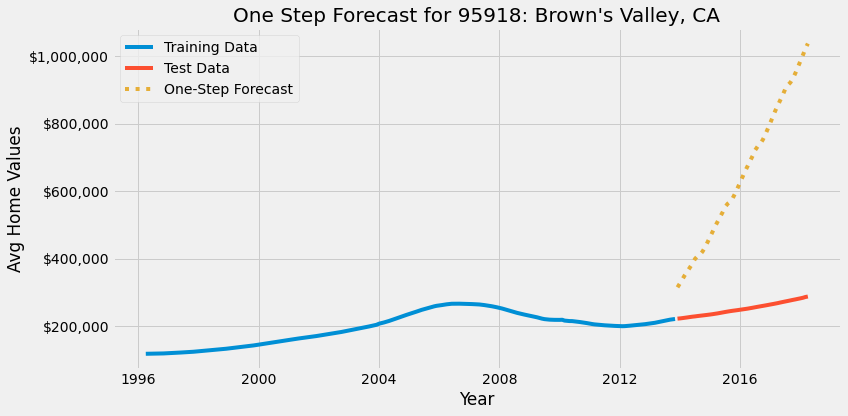

In [485]:
pred = zip_95918_model_1.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=False)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
#line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='black', label='US Mean');
ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("One Step Forecast for 95918: Brown's Valley, CA", fontsize = 20)
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [359]:
y_forecasted = pred.predicted_mean
y_truth = test['value']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 113915320918.45
The Root Mean Squared Error is 337513.44


### Model #2

In [360]:
#SARIMA Combos: ((2, 2, 0), (2, 2, 1, 12)) AIC: 3945.7191825608493
zip_95918_combo_2 = ((2, 2, 0), (2, 2, 1, 12))

In [361]:
combo = zip_95918_combo_2 
combo

((2, 2, 0), (2, 2, 1, 12))

In [362]:
# Manually split data.
temp_ts = zip_95918_ts

SPLIT = int(temp_ts.shape[0]*0.80)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                value   No. Observations:                  212
Model:             SARIMAX(2, 2, 0)x(2, 2, [1], 12)   Log Likelihood               -1410.123
Date:                              Sat, 21 May 2022   AIC                           2832.245
Time:                                      12:37:13   BIC                           2850.696
Sample:                                  04-01-1996   HQIC                          2839.738
                                       - 11-01-2013                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9010      0.094      9.615      0.000       0.717       1.085
ar.L2         -0.4662      0.092     -5.044      0.000      -0.647      -0.285
ar.S.L12      -1.1460      0.156     -7.338      0.000      -1.452      -0.840
ar.S.L24      -0.5736      0.161     -3.560      0.000      -0.889      -0.258
ma.S.L12      -0.0198      0.102     -0.194      0.846      -0.220       0.181
sigma2      4.224e+06   4.73e+05      8.923      0.000     3.3e+06    5.15e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.90   Jarque-Bera (JB):               464.10
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):              12.83   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [363]:
zip_95918_model_2 = sarima_model

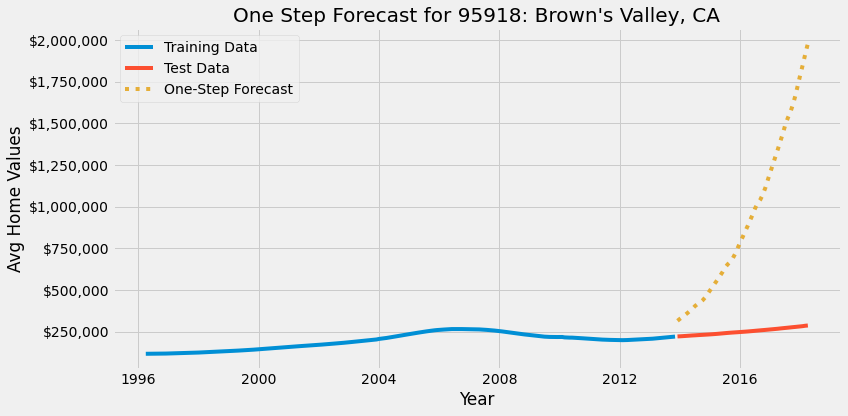

In [486]:
pred = zip_95918_model_2.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=False)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
#line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='black', label='US Mean');
ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("One Step Forecast for 95918: Brown's Valley, CA", fontsize = 20)
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [365]:
y_forecasted = pred.predicted_mean
y_truth = test['value']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 515246780918.21
The Root Mean Squared Error is 717806.92


### Analysis: 
- Both models seem to be overfit on the data and are projecting an upward trend that doesn't seem to match the known data. 
- Both also have high RSMEs relative to the other models that I have evaluated.
- I do not recommend this Zip Code, and don't even trust my models enough to run a prediction.

## <u><b>98359: Olalla WA</u></b>

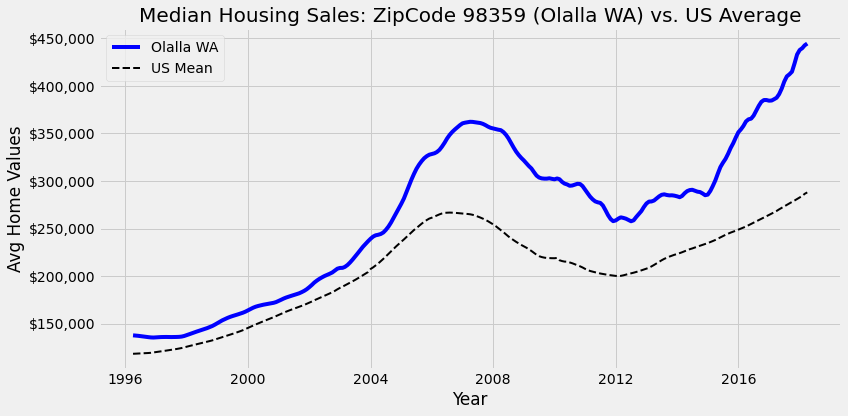

In [446]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(zip_98359_ts, label='Olalla WA', color='blue')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', ls='--',
                     color='black', linewidth=(2), label='US Mean');

ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("Median Housing Sales: ZipCode 98359 (Olalla WA) vs. US Average", fontsize = 20)
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [367]:
#sarimax_param_search(zip_98359_ts)

In [368]:
#Optimal SARIMA Combo: ((1, 1, 1), (0, 1, 1, 12)) AIC: 4034.182214906454
zip_98359_combo_1 = ((1, 1, 1), (0, 1, 1, 12))

### Model #1

In [369]:
combo = zip_98359_combo_1 
combo

((1, 1, 1), (0, 1, 1, 12))

In [370]:
# Manually split data.
temp_ts = zip_80102_ts

SPLIT = int(temp_ts.shape[0]*0.80)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  212
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -1525.927
Date:                            Sat, 21 May 2022   AIC                           3059.853
Time:                                    12:37:14   BIC                           3072.734
Sample:                                04-01-1996   HQIC                          3065.074
                                     - 11-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7912      0.039     20.334      0.000       0.715       0.867
ma.L1          0.6517      0.042     15.401      0.000       0.569       0.735
ma.S.L12      -0.4040      0.035    -11.581      0.000      -0.472      -0.336
sigma2       7.04e+05    5.8e+04     12.139      0.000     5.9e+05    8.18e+05
===================================================================================
Ljung-Box (L1) (Q):                   3.68   Jarque-Bera (JB):                 5.99
Prob(Q):                              0.06   Prob(JB):                         0.05
Heteroskedasticity (H):               4.61   Skew:                            -0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [371]:
zip_98359_model_1 = sarima_model

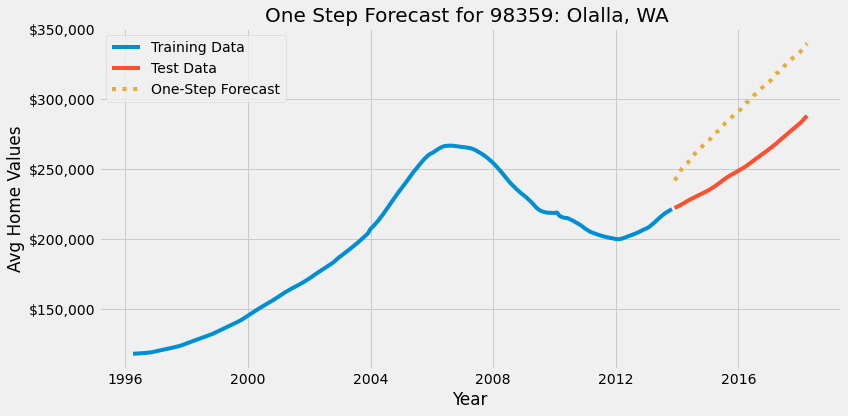

In [487]:
pred = zip_98359_model_1.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=False)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
#line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='black', label='US Mean');

ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("One Step Forecast for 98359: Olalla, WA ", fontsize = 20)
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [373]:
y_forecasted = pred.predicted_mean
y_truth = test['value']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 1997230432.36
The Root Mean Squared Error is 44690.38


### Model #2

In [374]:
#sarimax_param_search(zip_98359_ts)

In [375]:
#SARIMA Combos: ((2, 2, 2), (2, 2, 2, 12)) AIC: 3663.638994204836
zip_98359_combo_2 = ((2, 2, 2), (2, 2, 2, 12))

In [376]:
combo = zip_98359_combo_2
combo

((2, 2, 2), (2, 2, 2, 12))

In [377]:
# Manually split data.
temp_ts = zip_98359_ts

SPLIT = int(temp_ts.shape[0]*0.80)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  212
Model:             SARIMAX(2, 2, 2)x(2, 2, 2, 12)   Log Likelihood               -1330.031
Date:                            Sat, 21 May 2022   AIC                           2678.062
Time:                                    12:37:20   BIC                           2705.682
Sample:                                04-01-1996   HQIC                          2689.278
                                     - 11-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1509      0.103     11.181      0.000       0.949       1.353
ar.L2         -0.4443      0.080     -5.536      0.000      -0.602      -0.287
ma.L1         -0.4194      0.107     -3.929      0.000      -0.629      -0.210
ma.L2         -0.2772      0.085     -3.266      0.001      -0.444      -0.111
ar.S.L12      -1.0968      0.149     -7.363      0.000      -1.389      -0.805
ar.S.L24      -0.4728      0.099     -4.788      0.000      -0.666      -0.279
ma.S.L12      -0.0801      0.110     -0.729      0.466      -0.295       0.135
ma.S.L24       0.0151      0.132      0.114      0.909      -0.244       0.275
sigma2      1.047e+06   8.59e+04     12.180      0.000    8.78e+05    1.22e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.85   Jarque-Bera (JB):                48.66
Prob(Q):                              0.36   Prob(JB):                         0.00
Heteroskedasticity (H):               7.09   Skew:                            -0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [378]:
zip_98359_model_2 = sarima_model

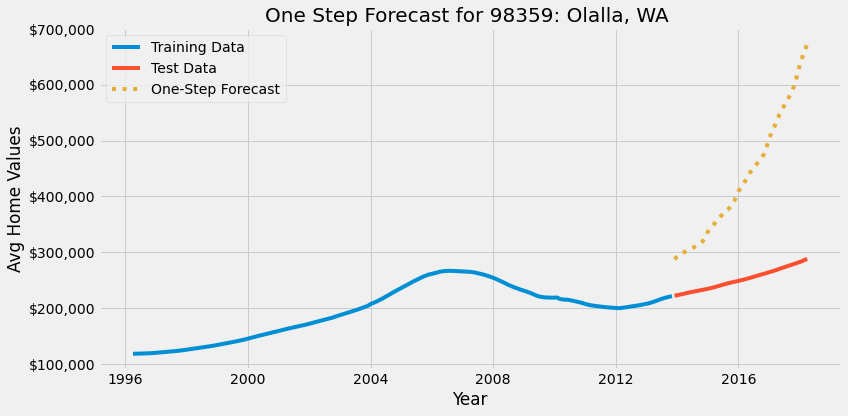

In [488]:
pred = zip_98359_model_2.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=False)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
#line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='black', label='US Mean');

ax.set_xlabel('Year')
ax.set_ylabel('Avg Home Values')
ax.set_title("One Step Forecast for 98359: Olalla, WA ", fontsize = 20)
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [380]:
y_forecasted = pred.predicted_mean
y_truth = test['value']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 11100001106.79
The Root Mean Squared Error is 105356.54


### Decision:
- Model 1 has a significantly lower RMSE, so I will use that one for predictions.

### Prediction

In [381]:
combo = zip_98359_combo_1
#combo = zip_98359_combo_2
combo

((1, 1, 1), (0, 1, 1, 12))

In [382]:
# Running model again with FULL data

sarima_model = SARIMAX(
    zip_98359_ts,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -2013.091
Date:                            Sat, 21 May 2022   AIC                           4034.182
Time:                                    12:37:21   BIC                           4048.071
Sample:                                04-01-1996   HQIC                          4039.780
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7581      0.039     19.286      0.000       0.681       0.835
ma.L1          0.6919      0.039     17.688      0.000       0.615       0.769
ma.S.L12      -0.3228      0.032    -10.096      0.000      -0.385      -0.260
sigma2       1.14e+06   5.84e+04     19.517      0.000    1.03e+06    1.25e+06
===================================================================================
Ljung-Box (L1) (Q):                   1.86   Jarque-Bera (JB):               227.44
Prob(Q):                              0.17   Prob(JB):                         0.00
Heteroskedasticity (H):               6.19   Skew:                             1.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [383]:
zip_98359_model_full = sarima_model

In [384]:
zip_98359_ts.tail(1)

value
time                 
2018-04-01 444,600.00

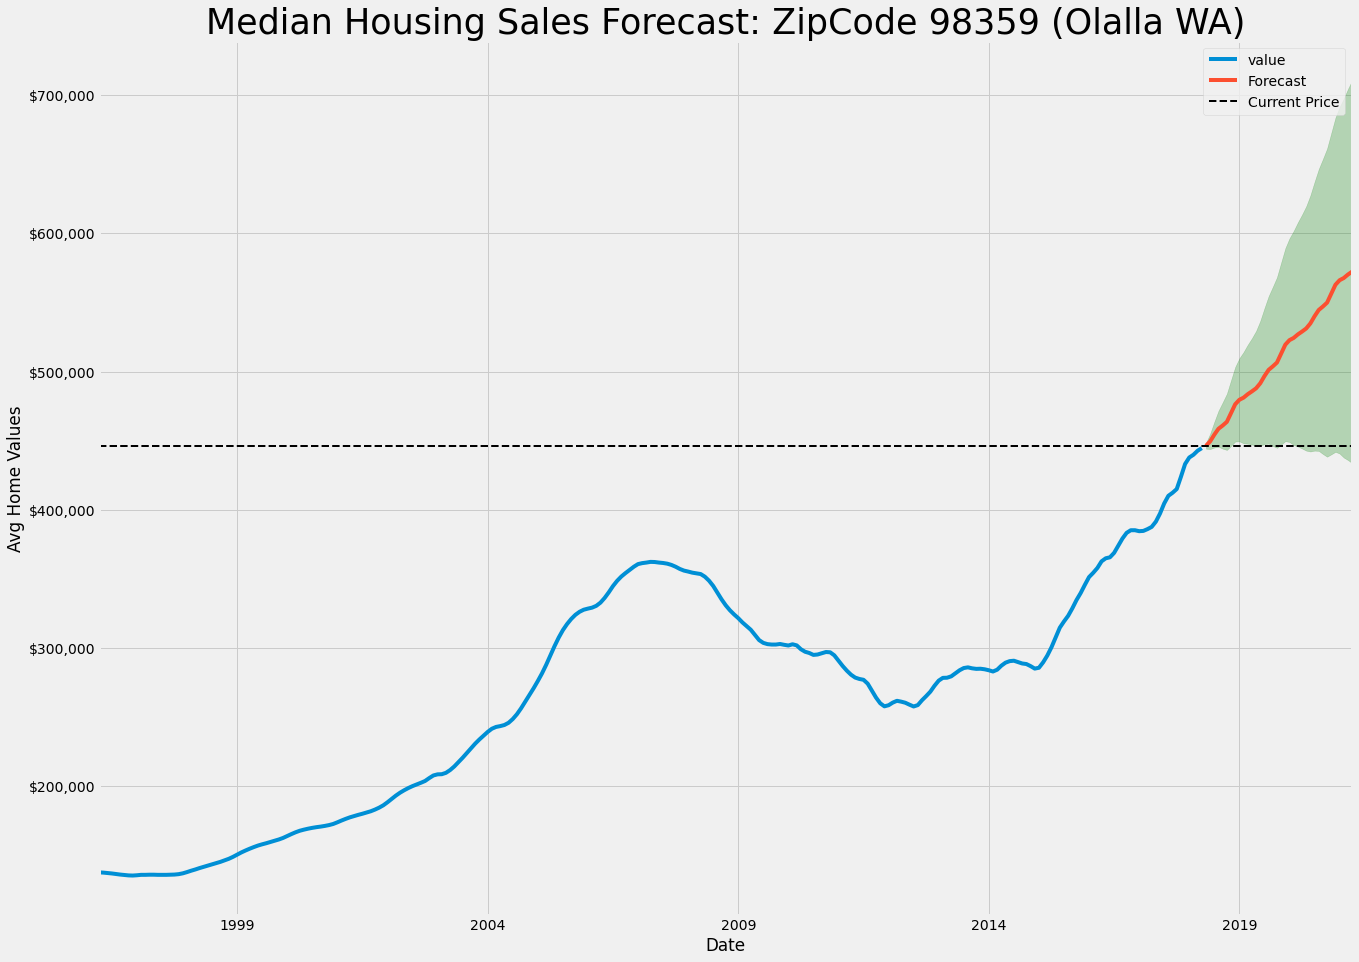

In [385]:
# Get forecast 3 yrs ahead in future (36 steps)
prediction = zip_98359_model_full.get_forecast(steps=36)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals
ax = zip_98359_ts['1996-01':].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='green', alpha=0.25)

ax.axhline(446000, ls='--', color='black', linewidth=(2), label='Current Price')

ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Values')
ax.set_title("Median Housing Sales Forecast: ZipCode 98359 (Olalla WA)", fontsize = 35)
ax.yaxis.set_major_formatter(tick) 

plt.legend()
plt.show()

### Analysis:
- Confidence interval low value has minimal losses, but basically breaking even, while there is a high chance of gains and a relatively narrow confidence window. 
- I highly recommend investing in this zip code!

### Metrics

In [386]:
zip_98359_ts.tail(1)

value
time                 
2018-04-01 444,600.00

In [387]:
analysis_df = pred_conf.resample('Y').mean()
analysis_df['mean'] = analysis_df.apply(lambda x: x.mean(), axis=1)

analysis_df['base'] = 444600
analysis_df['base'] = analysis_df['base'].astype(float)

In [388]:
analysis_df = analysis_df[['base', 'lower value', 'mean', 'upper value']]

analysis_df['Min_ROI'] = analysis_df.apply(lambda x: x['lower value'] - x['base'], axis=1)
analysis_df['Min_ROI%'] = analysis_df.apply(lambda x: x['Min_ROI'] / x['base'], axis=1)
analysis_df['Forecast_ROI'] = analysis_df.apply(lambda x: x['mean'] - x['base'], axis=1)
analysis_df['Forecast_ROI%'] = analysis_df.apply(lambda x: x['mean'] / x['base'], axis=1)
analysis_df['Max_ROI'] = analysis_df.apply(lambda x: x['upper value'] - x['base'], axis=1)
analysis_df['Max_ROI%'] = analysis_df.apply(lambda x: x['upper value'] / x['base'], axis=1)

In [389]:
analysis_df

base  lower value       mean  upper value   Min_ROI  \
2018-12-31 444,600.00   445,224.01 459,933.74   474,643.47    624.01   
2019-12-31 444,600.00   447,379.66 495,806.15   544,232.64  2,779.66   
2020-12-31 444,600.00   443,098.27 539,090.73   635,083.20 -1,501.73   
2021-12-31 444,600.00   437,052.81 569,029.36   701,005.90 -7,547.19   

            Min_ROI%  Forecast_ROI  Forecast_ROI%    Max_ROI  Max_ROI%  
2018-12-31      0.00     15,333.74           1.03  30,043.47      1.07  
2019-12-31      0.01     51,206.15           1.12  99,632.64      1.22  
2020-12-31     -0.00     94,490.73           1.21 190,483.20      1.43  
2021-12-31     -0.02    124,429.36           1.28 256,405.90      1.58

In [390]:
zip_98359_metrics = analysis_df

## <b><u>Final Analysis of Recommended Zip Codes</b></u>

### Avg Home DF

In [418]:
avg_home_df_metrics

base  lower value       mean  upper value    Min_ROI  \
2018-12-31 288,039.00   418,383.31 445,663.93   472,944.55 130,344.31   
2019-12-31 288,039.00   386,535.81 496,570.12   606,604.44  98,496.81   
2020-12-31 288,039.00   315,514.05 559,216.84   802,919.63  27,475.05   
2021-12-31 288,039.00   249,141.67 597,283.10   945,424.53 -38,897.33   

            Min_ROI%  Forecast_ROI  Forecast_ROI%    Max_ROI  Max_ROI%  
2018-12-31      0.45    157,624.93           1.55 184,905.55      1.64  
2019-12-31      0.34    208,531.12           1.72 318,565.44      2.11  
2020-12-31      0.10    271,177.84           1.94 514,880.63      2.79  
2021-12-31     -0.14    309,244.10           2.07 657,385.53      3.28

### 37046:College Grove TN

In [391]:
zip_37046_metrics

base  lower value       mean  upper value    Min_ROI  \
2018-12-31 459,800.00   468,257.69 501,253.86   534,250.03   8,457.69   
2019-12-31 459,800.00   468,612.24 571,721.86   674,831.47   8,812.24   
2020-12-31 459,800.00   455,392.58 652,309.15   849,225.72  -4,407.42   
2021-12-31 459,800.00   434,655.38 698,855.46   963,055.53 -25,144.62   

            Min_ROI%  Forecast_ROI  Forecast_ROI%    Max_ROI  Max_ROI%  
2018-12-31      0.02     41,453.86           1.09  74,450.03      1.16  
2019-12-31      0.02    111,921.86           1.24 215,031.47      1.47  
2020-12-31     -0.01    192,509.15           1.42 389,425.72      1.85  
2021-12-31     -0.05    239,055.46           1.52 503,255.53      2.09

### 02128: Boston MA

In [392]:
zip_02128_metrics

base  lower value       mean  upper value   Min_ROI  \
2018-12-31 489,900.00   498,942.37 512,514.32   526,086.27  9,042.37   
2019-12-31 489,900.00   511,264.16 557,030.40   602,796.64 21,364.16   
2020-12-31 489,900.00   522,757.43 608,620.65   694,483.87 32,857.43   
2021-12-31 489,900.00   527,880.09 641,545.46   755,210.84 37,980.09   

            Min_ROI%  Forecast_ROI  Forecast_ROI%    Max_ROI  Max_ROI%  
2018-12-31      0.02     22,614.32           1.05  36,186.27      1.07  
2019-12-31      0.04     67,130.40           1.14 112,896.64      1.23  
2020-12-31      0.07    118,720.65           1.24 204,583.87      1.42  
2021-12-31      0.08    151,645.46           1.31 265,310.84      1.54

### 80204: Denver, CO

In [393]:
zip_80204_metrics

base  lower value       mean  upper value   Min_ROI  \
2018-12-31 371,600.00   380,320.70 387,502.07   394,683.43  8,720.70   
2019-12-31 371,600.00   385,601.55 416,261.60   446,921.66 14,001.55   
2020-12-31 371,600.00   382,699.74 443,296.34   503,892.94 11,099.74   
2021-12-31 371,600.00   379,421.36 458,806.66   538,191.96  7,821.36   

            Min_ROI%  Forecast_ROI  Forecast_ROI%    Max_ROI  Max_ROI%  
2018-12-31      0.02     15,902.07           1.04  23,083.43      1.06  
2019-12-31      0.04     44,661.60           1.12  75,321.66      1.20  
2020-12-31      0.03     71,696.34           1.19 132,292.94      1.36  
2021-12-31      0.02     87,206.66           1.23 166,591.96      1.45

### 07087: Union City, NJ

In [394]:
zip_07087_metrics

base  lower value       mean  upper value   Min_ROI  \
2018-12-31 448,900.00   450,172.27 475,146.70   500,121.13  1,272.27   
2019-12-31 448,900.00   477,799.93 553,457.43   629,114.93 28,899.93   
2020-12-31 448,900.00   503,549.54 656,978.95   810,408.37 54,649.54   
2021-12-31 448,900.00   515,409.16 731,392.17   947,375.18 66,509.16   

            Min_ROI%  Forecast_ROI  Forecast_ROI%    Max_ROI  Max_ROI%  
2018-12-31      0.00     26,246.70           1.06  51,221.13      1.11  
2019-12-31      0.06    104,557.43           1.23 180,214.93      1.40  
2020-12-31      0.12    208,078.95           1.46 361,508.37      1.81  
2021-12-31      0.15    282,492.17           1.63 498,475.18      2.11

### 98359: Olalla, WA

In [395]:
zip_98359_metrics

base  lower value       mean  upper value   Min_ROI  \
2018-12-31 444,600.00   445,224.01 459,933.74   474,643.47    624.01   
2019-12-31 444,600.00   447,379.66 495,806.15   544,232.64  2,779.66   
2020-12-31 444,600.00   443,098.27 539,090.73   635,083.20 -1,501.73   
2021-12-31 444,600.00   437,052.81 569,029.36   701,005.90 -7,547.19   

            Min_ROI%  Forecast_ROI  Forecast_ROI%    Max_ROI  Max_ROI%  
2018-12-31      0.00     15,333.74           1.03  30,043.47      1.07  
2019-12-31      0.01     51,206.15           1.12  99,632.64      1.22  
2020-12-31     -0.00     94,490.73           1.21 190,483.20      1.43  
2021-12-31     -0.02    124,429.36           1.28 256,405.90      1.58

## <b><u>Recommendations</b></u>

### Recommendation #1: Top 5 ZipCodes to Invest in:
- 1. 37046 College Grove, TN
- 2. 02128 Boston, MA
- 3. 80204 Denver, CO
- 4. 07087 Union City, NJ
- 5. 98359 Olalla, WA</b>

<u><b>These Zip Codes completely meet the criteria that I was given:</u></b>
- <b>Cost of Entry:</b> Average Home Values around 500,000 
-- (currently 370,000 - 489,000)
- <b>Geographic Diversity:</b> Each is in a different State.
- <b>High ROI:</b> Each is forecasted to have a high return on investment over the next 3 years.
-- Mean Forecast Values for Forecast Year 3: 1.2% ROI - 1.6% ROI.
-- Mean Forecast ROI Amounts for Forecast Year 3: 87,000 - 282,000.
- <b>Low Risk:</b> Each has been forecast with a low risk of losing money over the next 3 years.
-- Maximum Forecast Loss at Forecast Year 3 : -5% ROI
- <b>Timing:</b> All forecasts were for 3 years.

### Recommendation #2: ZipCodes for Shorter investment
ZipCodes that showed a good return with low risk for 1 or 2 years.
- 1. 29403 Charleston SC
- 2. 98043 Mountlake Terrace WA

These Zip Codes still show a lot of potental, but need to be watched more closely. They all show great potentional for one or even two years of investment, but then the third year forecast becomes more uncertain.

I am in confident in recommending both of these Zip Codes during that shorter investment window, and then running models again as more data comes in.


### Recommendation #3: Model more Zip Codes.
I was limited by time and resources available to me. I recommend running this model on more zipcodes in more states, and at other price points to find more great investment opportunities.

### Recommendation #4: ACT NOW!
- I used the most recent data that I had access to, but these recommended zipcodes are all rapidly increasing in value. The longer you wait, the higher the cost of entry is going to be.

## <b> Conclusion </b>

- Analyzing the past performance over the last 3 years proved to be a good way to identify zip codes that would continue to perform well 3 years into the future.
- While not all Zip Codes that I identified and targetted ended up being recommended, I only had to model 15 Zip Codes in order to get my 5 "best" Zip Codes to recommend.
- In this process, I also ended up finding 2-3 Zip Codes that nearly met all criteria and became an alternative recommendation.

## <b> Archive </b>

In [398]:
#code to keep from running the archive
archive = break_df

NameError: name 'break_df' is not defined

###  84757 New Harmony UT

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(zip_84757_ts, label='Inglewood CA', color='blue')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', ls='--',
                     color='black', linewidth=(2), label='US Mean');
ax.set_title("Median Housing Sales: ZipCode 84757 (New Harmony, UT) vs. US Average", fontsize = 20)
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [ ]:
sarimax_param_search(zip_84757_ts)

In [399]:
#SARIMA Combos: ((1, 1, 1), (1, 1, 1, 12)) AIC: 4118.665538593098
zip_84757_combo_1 = ((1, 1, 1), (1, 1, 1, 12))

In [400]:
combo = zip_84757_combo_1
combo

((1, 1, 1), (1, 1, 1, 12))

In [401]:
# Manually split data.
temp_ts = zip_84757_ts

SPLIT = int(temp_ts.shape[0]*0.80)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  212
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1603.914
Date:                            Sat, 21 May 2022   AIC                           3217.827
Time:                                    12:41:18   BIC                           3233.929
Sample:                                04-01-1996   HQIC                          3224.353
                                     - 11-01-2013                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9227      0.032     29.118      0.000       0.861       0.985
ma.L1          0.3339      0.024     13.888      0.000       0.287       0.381
ar.S.L12      -0.4651      0.068     -6.803      0.000      -0.599      -0.331
ma.S.L12      -0.0323      0.036     -0.892      0.372      -0.103       0.039
sigma2       2.22e+06   2.07e+05     10.743      0.000    1.82e+06    2.63e+06
===================================================================================
Ljung-Box (L1) (Q):                  33.94   Jarque-Bera (JB):                26.44
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.43   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [402]:
zip_84757_model_1 = sarima_model

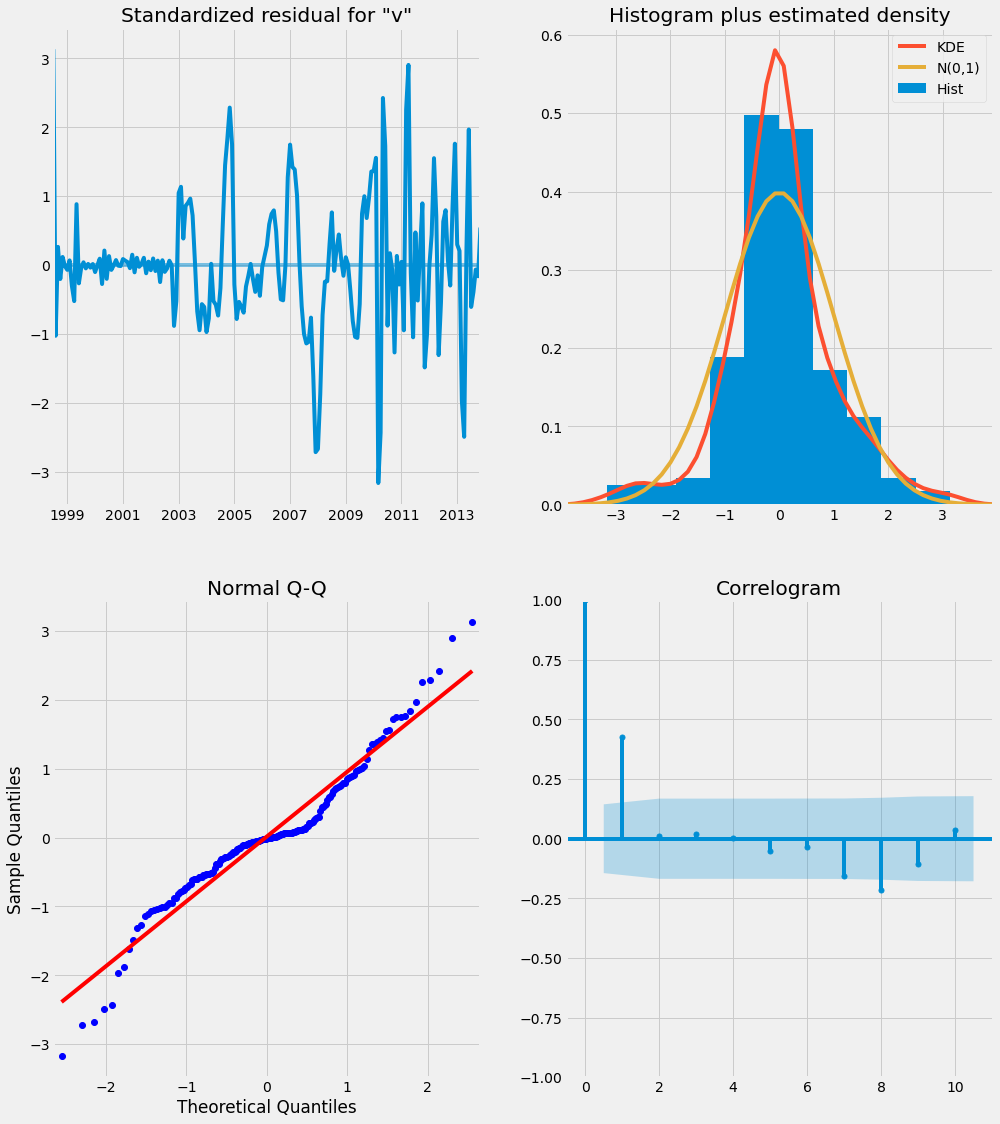

In [403]:
zip_84757_model_1.plot_diagnostics(figsize=(15, 18))
plt.show()

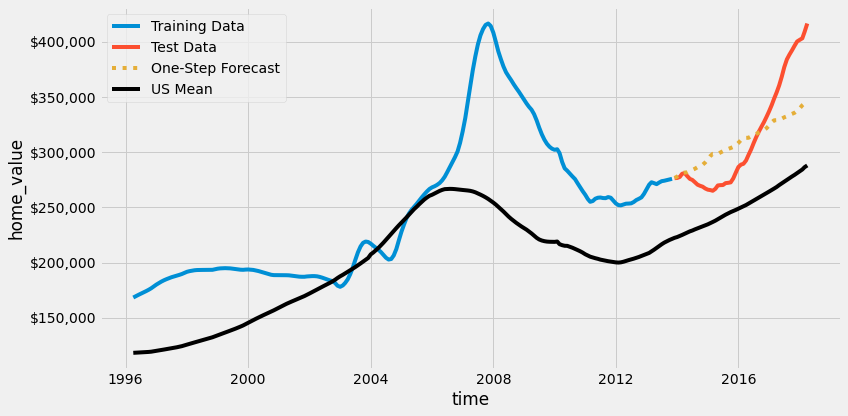

In [404]:
pred = zip_84757_model_1.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=False)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='black', label='US Mean');
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

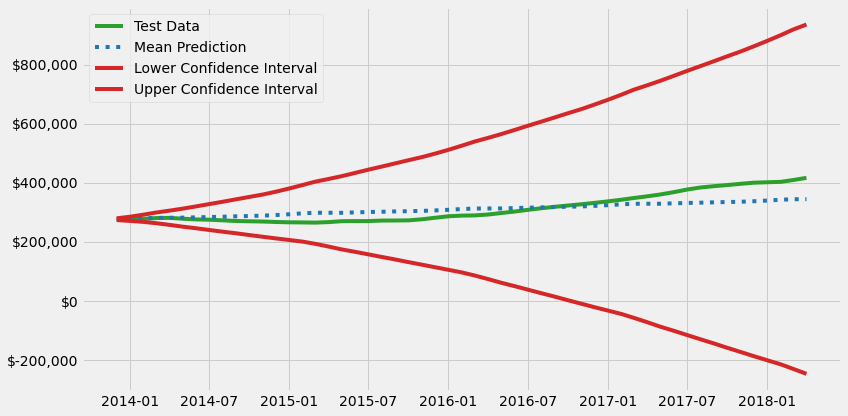

In [405]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test, label='Test Data', color='tab:green')
ax.plot(pred.predicted_mean, 
        label='Mean Prediction',
        color='tab:blue', 
        ls=':')
ax.plot(pred.conf_int()['lower value'], 
        label='Lower Confidence Interval', 
        color='tab:red')
ax.plot(pred.conf_int()['upper value'], 
        label='Upper Confidence Interval', 
        color='tab:red')
ax.yaxis.set_major_formatter(tick) 
ax.legend()
fig.tight_layout()

In [406]:
y_forecasted = pred.predicted_mean
y_truth = test['value']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error is 1028452565.62
The Root Mean Squared Error is 32069.5


### Predictions


In [407]:
combo = zip_84757_combo_1
#combo = zip_84757_combo_2
combo

((1, 1, 1), (1, 1, 1, 12))

In [408]:
# Running model again with FULL data

sarima_model = SARIMAX(
    zip_84757_ts,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              value   No. Observations:                  265
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -2054.333
Date:                            Sat, 21 May 2022   AIC                           4118.666
Time:                                    12:41:20   BIC                           4136.027
Sample:                                04-01-1996   HQIC                          4125.662
                                     - 04-01-2018                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8701      0.044     19.805      0.000       0.784       0.956
ma.L1          0.8236      0.048     17.077      0.000       0.729       0.918
ar.S.L12       0.1294      0.029      4.445      0.000       0.072       0.186
ma.S.L12      -0.3944      0.028    -13.928      0.000      -0.450      -0.339
sigma2      2.436e+06   2.34e+05     10.421      0.000    1.98e+06    2.89e+06
===================================================================================
Ljung-Box (L1) (Q):                   2.65   Jarque-Bera (JB):                60.72
Prob(Q):                              0.10   Prob(JB):                         0.00
Heteroskedasticity (H):               2.33   Skew:                            -0.05
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [409]:
zip_84757_model_full = sarima_model

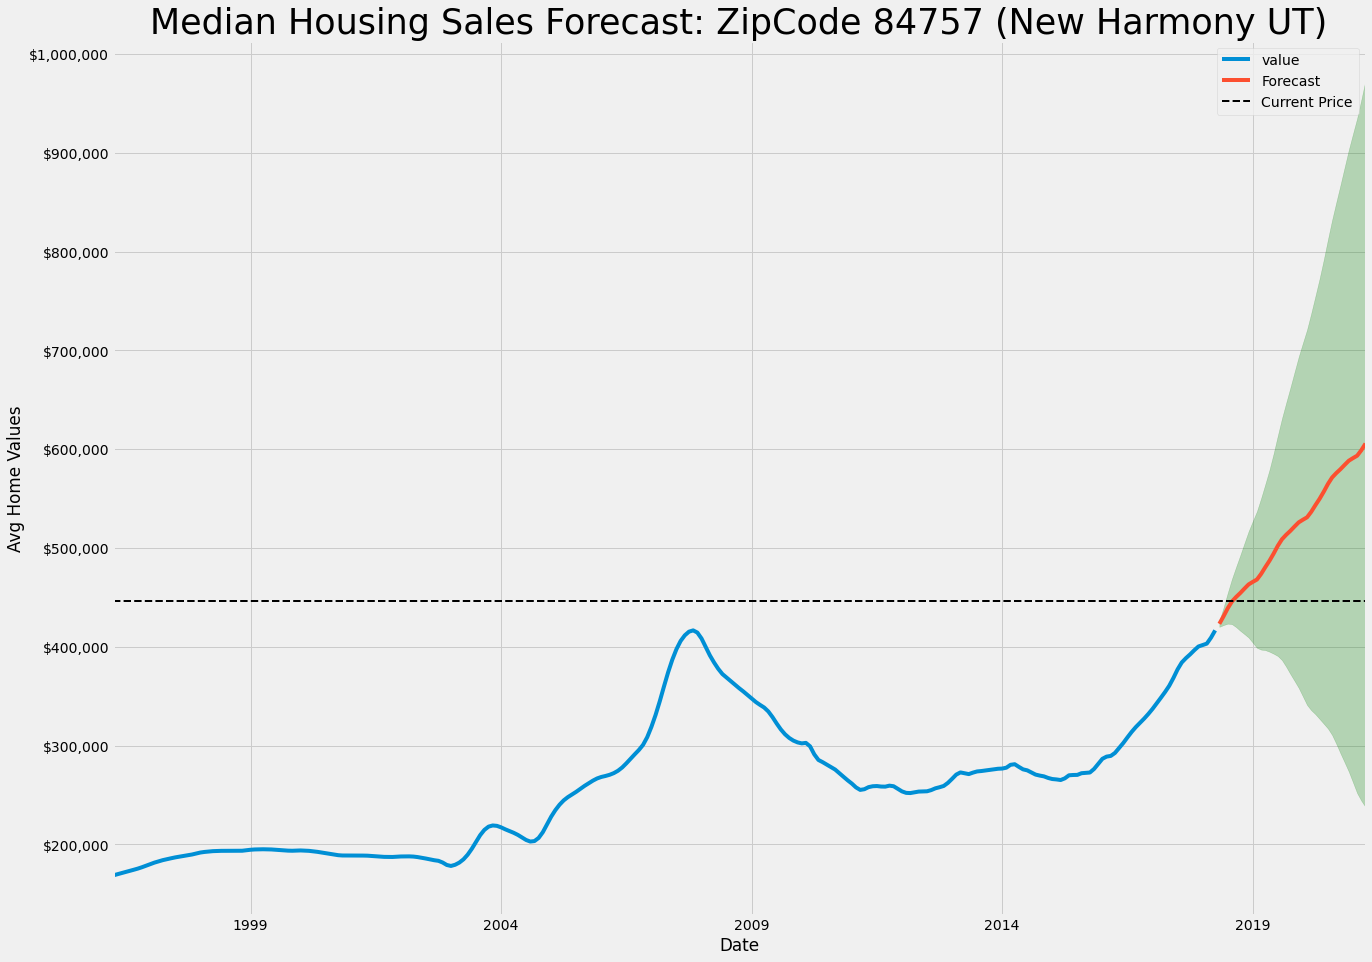

In [410]:
# Get forecast 3 yrs ahead in future (36 steps)
prediction = zip_84757_model_full.get_forecast(steps=36)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals
ax = zip_84757_ts['1996-01':].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='green', alpha=0.25)

ax.axhline(446000, ls='--', color='black', linewidth=(2), label='Current Price')

ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Values')
ax.set_title("Median Housing Sales Forecast: ZipCode 84757 (New Harmony UT)", fontsize = 35)
ax.yaxis.set_major_formatter(tick) 

plt.legend()
plt.show()

### Analysis: Too much potentional for loss. 

### 89704: Carson City NV

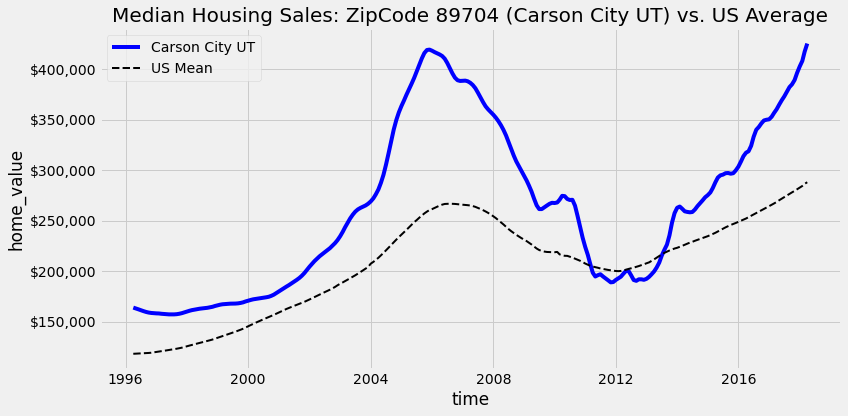

In [411]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(zip_89704_ts, label='Carson City UT', color='blue')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', ls='--',
                     color='black', linewidth=(2), label='US Mean');
ax.set_title("Median Housing Sales: ZipCode 89704 (Carson City UT) vs. US Average", fontsize = 20)
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [412]:
sarimax_param_search(zip_89704_ts)

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 0, 0), (0, 0, 0, 12)) AIC: 7364.6900394668855
SARIMA Combos: ((0, 0, 0), (0, 0, 1, 12)) AIC: 6876.103561824217
SARIMA Combos: ((0, 0, 0), (0, 0, 2, 12)) AIC: 6536.657729806906
SARIMA Combos: ((0, 0, 0), (0, 1, 0, 12)) AIC: 6064.732638844379


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 0, 0), (0, 1, 1, 12)) AIC: 5789.213584393949


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No fre

SARIMA Combos: ((0, 0, 0), (0, 1, 2, 12)) AIC: 5448.637267732403


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


SARIMA Combos: ((0, 0, 0), (0, 2, 2, 12)) AIC: 5179.051990243945


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No fre

SARIMA Combos: ((0, 0, 1), (0, 2, 2, 12)) AIC: 4944.479121224677


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 0), (0, 0, 1, 12)) AIC: 4879.106803799439
SARIMA Combos: ((0, 1, 0), (0, 0, 2, 12)) AIC: 4657.704283396381


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 0), (0, 1, 2, 12)) AIC: 4481.904883422179


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 0), (0, 2, 2, 12)) AIC: 4400.232727120552


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 0), (1, 2, 2, 12)) AIC: 4322.174566500007


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 0), (2, 2, 1, 12)) AIC: 4310.995791218638


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


SARIMA Combos: ((0, 1, 0), (2, 2, 2, 12)) AIC: 4304.818733830032


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 1), (0, 1, 2, 12)) AIC: 4244.502561298721


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 1), (0, 2, 2, 12)) AIC: 4114.445375174929


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 1), (1, 2, 2, 12)) AIC: 4084.658233135877


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 2), (0, 1, 2, 12)) AIC: 3951.051552528363


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 1, 2), (1, 1, 2, 12)) AIC: 3942.606917182472


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 2, 1), (0, 1, 2, 12)) AIC: 3932.941751441068


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 2, 2), (0, 1, 2, 12)) AIC: 3893.7157013915594


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((0, 2, 2), (0, 2, 2, 12)) AIC: 3886.6725493297313


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No fre

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No fre

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No fre

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 2), (0, 1, 2, 12)) AIC: 3871.6861001402203


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

SARIMA Combos: ((1, 1, 2), (1, 1, 2, 12)) AIC: 3864.4995982222354


/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequen

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No fre

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No fre

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No fre

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No fre

/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jonathanholt/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No fre

KeyboardInterrupt: 

In [ ]:
#SARIMA Combos: ((1, 1, 1), (1, 1, 1, 12)) AIC: 4197.0981049301245
zip_89704_combo_1 = ((1, 1, 1), (1, 1, 1, 12))

In [ ]:
combo = zip_89704_combo_1
combo

In [ ]:
# Manually split data.
temp_ts = zip_89704_ts

SPLIT = int(temp_ts.shape[0]*0.8)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

In [ ]:
zip_89704_model_1 = sarima_model

In [ ]:
zip_89704_model_1.plot_diagnostics(figsize=(15, 18))
plt.show()

In [ ]:
pred = zip_89704_model_1.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=False)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='black', label='US Mean');
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

### Model #2

### 80102 Bennett CO

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(zip_80102_ts, label='Inglewood CA', color='blue')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', ls='--',
                     color='black', linewidth=(2), label='US Mean');
ax.set_title("Median Housing Sales: ZipCode 90304 (Inglewood, CA) vs. US Average", fontsize = 20)
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [ ]:
#sarimax_param_search(zip_80102_ts)

In [ ]:
#SARIMA Combos: ((1, 1, 1), (0, 1, 1, 12)) AIC: 3996.025968264351
zip_80102_combo_1 = ((1, 1, 1), (0, 1, 1, 12))

In [ ]:
combo = zip_80102_combo_1
combo

In [ ]:
# Manually split data.
temp_ts = zip_80102_ts

SPLIT = int(temp_ts.shape[0]*0.80)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

In [ ]:
zip_80102_model_1 = sarima_model

In [ ]:
zip_80102_model_1.plot_diagnostics(figsize=(15, 18))
plt.show()

In [ ]:
pred = zip_80102_model_1.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=False)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='black', label='US Mean');
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test, label='Test Data', color='tab:green')
ax.plot(pred.predicted_mean, 
        label='Mean Prediction',
        color='tab:blue', 
        ls=':')
ax.plot(pred.conf_int()['lower value'], 
        label='Lower Confidence Interval', 
        color='tab:red')
ax.plot(pred.conf_int()['upper value'], 
        label='Upper Confidence Interval', 
        color='tab:red')
ax.yaxis.set_major_formatter(tick) 
ax.legend()
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(test, label='Test Data', color='tab:green')
ax.plot(pred.predicted_mean, 
        label='Mean Prediction',
        color='tab:blue', 
        ls=':')
ax.plot(pred.conf_int()['lower value'], 
        label='Lower Confidence Interval', 
        color='tab:red')
ax.plot(pred.conf_int()['upper value'], 
        label='Upper Confidence Interval', 
        color='tab:red')
ax.yaxis.set_major_formatter(tick) 
ax.legend()
fig.tight_layout()

### Model #2

In [ ]:
#SARIMA Combos: ((1, 1, 2), (1, 2, 2, 12)) AIC: 3638.8768820998457
zip_80102_combo_2 = ((1, 1, 2), (1, 2, 2, 12))

In [ ]:
combo = zip_80102_combo_2
combo

In [ ]:
# Manually split data.
temp_ts = zip_80102_ts

SPLIT = int(temp_ts.shape[0]*0.80)
train, test = temp_ts[:SPLIT], temp_ts[SPLIT:]

# Model
sarima_model = SARIMAX(
    train,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

In [ ]:
zip_80102_model_2 = sarima_model

In [ ]:
# Running model again with FULL data

sarima_model = SARIMAX(
    zip_90304_ts,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

In [ ]:
pred = zip_80102_model_2.get_prediction(
    start=test.index.min(), 
    end=test.index.max(), 
    dynamic=False)

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(train, label='Training Data')
ax.plot(test, label='Test Data')
ax.plot(pred.predicted_mean, label='One-Step Forecast', ls=':')
line1 = sns.lineplot(data=avg_home_df, x='time', y='home_value', color='black', label='US Mean');
ax.legend()
ax.yaxis.set_major_formatter(tick) 
fig.tight_layout()

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = test['value']
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error is {}'.format(round(np.sqrt(mse), 2)))

### Prediction

In [ ]:
combo = zip_80102_combo_1
combo = zip_80102_combo_2
combo

In [ ]:
# Running model again with FULL data

sarima_model = SARIMAX(
    zip_80102_ts,
    order=combo[0],
    seasonal_order=combo[1],
    enforce_stationarity=False,
    enforce_invertibility=False).fit()
sarima_model.summary()

In [ ]:
zip_80102_model_full = sarima_model

In [ ]:
# Get forecast 3 yrs ahead in future (36 steps)
prediction = zip_80102_model_full.get_forecast(steps=36)

# Get confidence intervals of forecasts
pred_conf = prediction.conf_int()

# Plot future predictions with confidence intervals
ax = zip_37046_ts['1996-01':].plot(label='observed', figsize=(20, 15))
prediction.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='green', alpha=0.25)

ax.axhline(470000, ls='--', color='black', linewidth=(2), label='Current Price')

ax.set_xlabel('Date')
ax.set_ylabel('Avg Home Values')
ax.set_title("Median Housing Sales Forecast: ZipCode 95918 (Brown's Valley CA)", fontsize = 35)
ax.yaxis.set_major_formatter(tick) 

plt.legend()
plt.show()

### Advanced Sarima Combos

In [ ]:
#SARIMA Combos: ((2, 2, 2), (2, 2, 2, 12)) AIC: 3577.2395803210907
zip_98403_combo_2 = ((2, 2, 2), (2, 2, 2, 12))
#SARIMA Combos: ((2, 2, 2), (0, 2, 2, 12)) AIC: 3572.582171627717
zip_02128_combo_2 = ((2, 2, 2), (0, 2, 2, 12))
#SARIMA Combos: ((1, 1, 2), (1, 2, 2, 12)) AIC: 3771.3550338175914
zip_07087_combo_2 = ((1, 1, 2), (1, 2, 2, 12))
#SARIMA Combos: ((2, 2, 2), (0, 2, 2, 12)) AIC: 3738.2085627898796
zip_90304_combo_2 = ((2, 2, 2), (0, 2, 2, 12))
#SARIMA Combos: ((2, 2, 0), (2, 2, 1, 12)) AIC: 3945.7191825608493
zip_95918_combo_2 = ((2, 2, 0), (2, 2, 1, 12))